# General DA fittings and Fokker-Planck comparisons with lmfit(Hénon map with octupolar kick $\mu$)

## Imports

In [1]:
# %matplotlib widget

In [1]:
# Base libraries
import math
import numpy as np
import scipy.integrate as integrate
from scipy.special import erf
import pickle
import itertools
from scipy.optimize import curve_fit

from numba import njit, prange

from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from math import gcd

import pandas as pd

from scipy.special import lambertw
from scipy.interpolate import interp1d

import os
import re

# Personal libraries
import sixtrackwrap as sx
import crank_nicolson_numba.nekhoroshev as nk
import henon_map as hm

# Personal modules
import fit_utils as fit

# Lmfit
from lmfit import Minimizer, Parameters, report_fit

# Let's get freaky
import multiprocessing

Sixtracklib module not found! Loading dummy functions!


/home/STUDENTI/carlo.montanari3/loss_studies/notebooks/fit_utils.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


*if we want quiet operations... even though it's not a good practice at all...*

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
PROCESSES = 32

In [3]:
def wrap_fit(f, turn, da, eps, mu):
    for i in range(20):
        try:
            r1, r2 = f(turn, da)
        except ValueError:
            continue
        else:
            return r1, r2, eps, mu
    raise ValueError
    
def wrap_fit_err(f, turn, da, err, eps, mu):
    for i in range(20):
        try:
            r1, r2 = f(turn, da, err)
        except ValueError:
            continue
        else:
            return r1, r2, eps, mu
    raise ValueError

def wrap_fp_fit(f, turn, loss, I0, I_max, k, eps, mu):
    r1, r2 = f(turn, loss, 1.0, I0, I_max, 1, k, 0.26, "lstsqr")
    return r1, r2, eps, mu

def wrap_fp_fit_poly(f, turn, loss, I0, I_max, exp, eps, mu):
    r1, r2 = f(turn, loss, 1.0, I0, I_max, 1, exp, "lstsqr")
    return r1, r2, eps, mu

def wrap_fp(params, turns, losses, dt, I0, I_max, iter_step, iter_mult, actual_iters, epsilon, mu):
    engine, t, point_s, point_t, iter_step = fit.fp_lmfit(
        params,
        turns,
        losses,
        dt,
        I0,
        I_max,
        iter_step,
        False,
        True
    )
    return fit.new_fp(engine, t, iter_mult, point_s, point_t, iter_step, actual_iters), epsilon, mu

def wrap_fp_poly(params, turns, losses, dt, I0, I_max, iter_step, iter_mult, actual_iters, epsilon, mu):
    engine, t, point_s, point_t, iter_step = fit.fp_lmfit_poly(
        params,
        turns,
        losses,
        dt,
        I0,
        I_max,
        iter_step,
        False,
        True
    )
    return fit.new_fp(engine, t, iter_mult, point_s, point_t, iter_step, actual_iters), epsilon, mu

def wrap_fp_poly_istar(params, turns, losses, dt, I0, I_max, iter_step, iter_mult, actual_iters, epsilon, mu):
    engine, t, point_s, point_t, iter_step = fit.fp_lmfit_poly_istar(
        params,
        turns,
        losses,
        dt,
        I0,
        I_max,
        iter_step,
        False,
        True
    )
    return fit.new_fp(engine, t, iter_mult, point_s, point_t, iter_step, actual_iters), epsilon, mu

In [4]:
def chi2(est, original):
    return np.sum(np.power((est - original)/original, 2))

In [5]:
# Lmfit
from lmfit import Minimizer, Parameters, report_fit

def fit_model_2_fixed_n0(turns, DA, err=None):
    params = Parameters()
    params.add("rho", value=1, min=0, vary=True)
    params.add("n0", value=1, vary=False)
    params.add("k", value=1, min=0, vary=True)
    if err is None:
        minner = Minimizer(fit.model_2_lmfit, params, fcn_args=(turns, DA))
    else:
        minner = Minimizer(fit.model_2_lmfit, params, fcn_args=(turns, DA, err))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

## Load data and setup original DA

In [6]:
savepath = "../data/"

sigma = 0.15
turn_samples = 1000
min_turns = 1000
max_turns = 5000000
turn_sampling = np.linspace(min_turns, max_turns, turn_samples, dtype=np.int)[::-1]
# Do we want to load ALL the Hénon data files or should we skip some?
skipper = 1

cut_point = 0.9

def sorterer(s):
    ints = re.findall(r'-?\d+', s)
    value = int(ints[0]) * 1000 + int(ints[1]) + 500
    return value

files = list(sorted(list(filter(lambda f: "henon_ter_eps_" in f and "unif" not in f and "hdf5" in f and "mu" in f, os.listdir(savepath))), key=sorterer))[::skipper]

In [7]:
def select_some(f_list):
    sel_list = []
    for i in range(len(f_list)):
        ints = re.findall(r'[-+]?[0-9]*\.?[0-9]+', f_list[i])
        epsilon = float(ints[0])
        mu = float(ints[1])
        if epsilon > 32.0 or epsilon == 2.0 or epsilon == 8.0 or epsilon == 10.0:
            pass
        else:
            sel_list.append(f_list[i])
    return sel_list
            
files = select_some(files)

In [8]:
epsilons = []
mus = []

real_DAs = []
real_DAs_err = []
gaussian_DAs = []

radiuses_alpha = []

real_losses = []
gaussian_losses = []

loss_from_DA = []
DA_from_loss = []

In [9]:
def callback(results):
    epsilons.append(results[0])
    mus.append(results[1])
    real_DAs.append(results[2])
    real_DAs_err.append(results[3])
    d_r = results[4]
    gaussian_losses.append(results[5])
    radiuses_alpha.append(results[6])
    loss_from_DA.append(results[7])
    DA_from_loss.append(results[8])
    print(results[0], results[1])

def just_filename(f):
    ints = re.findall(r'[-+]?[0-9]*\.?[0-9]+', f)
    epsilon = float(ints[0])
    mu = float(ints[1])
    """
    if mu == 87:
        mu = 87.5
    elif mu == -87:
        mu = -87.5
    elif mu == 62:
        mu = 62.5
    elif mu == -62:
        mu = -62.5
    elif mu == 37:
        mu = 37.5
    elif mu == -37:
        mu = -37.5
    elif mu == 12:
        mu = 12.5
    elif mu == -12:
        mu = -12.5
    mu = mu / 100
    """
    return epsilon, mu

def preprocess(f):
    ints = re.findall(r'[-+]?[0-9]*\.?[0-9]+', f)
    epsilon = float(ints[0])
    mu = float(ints[1])
    """
    if mu == 87:
        mu = 87.5
    elif mu == -87:
        mu = -87.5
    elif mu == 62:
        mu = 62.5
    elif mu == -62:
        mu = -62.5
    elif mu == 37:
        mu = 37.5
    elif mu == -37:
        mu = -37.5
    elif mu == 12:
        mu = 12.5
    elif mu == -12:
        mu = -12.5
    mu = mu / 100
    """
    engine = hm.uniform_radial_scanner(savepath + f)
    #print(epsilon)
    d_r = engine.dr
    DA, DA_err, radiuses = engine.compute_DA_standard(turn_sampling, True)
    #print(epsilon, "Done DA")
    #engine.assign_weights(hm.assign_symmetric_gaussian(sigma))
    engine.assign_weights_from_file(savepath + "weights_mu.hdf5") 
    loss = engine.compute_loss(turn_sampling, cut_point, True)
    #print(epsilon, "Done Loss")
    loss_from_DA = hm.from_DA_to_loss_sym_gauss(sigma, DA, cut_point)
    DA_from_loss = hm.from_loss_to_DA_sym_gauss(sigma, loss, cut_point)
    #print(epsilon, "Done inversion")
    return(epsilon, mu, DA, DA_err, d_r, loss, radiuses[:, :, 0, 0], loss_from_DA, DA_from_loss)

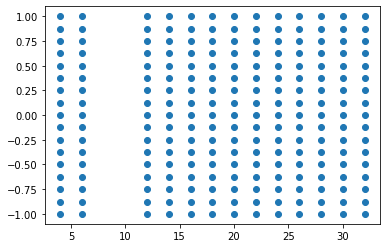

In [10]:
plt.figure()
temp_fnames = [just_filename(f) for f in files]
plt.scatter([t[0] for t in temp_fnames], [t[1] for t in temp_fnames])

In [11]:
# missing parts?
t_eps = set([t[0] for t in temp_fnames])
t_mus = set([t[1] for t in temp_fnames])
all_expected = list(itertools.product(t_eps, t_mus))

for t in temp_fnames:
    all_expected.remove(t)

# Let's get the output in a convenient form...
for t in all_expected:
    print("20 1000 5000000 {} 1.0 0.0 {}".format(int(t[0]), t[1]))

In [12]:
e = hm.uniform_radial_scanner(savepath + files[0])
e.create_weights_in_dataset(savepath + "weights_mu.hdf5", hm.assign_symmetric_gaussian(sigma))
del e

assigning weights: 100%|██████████| 100/100 [00:02<00:00, 38.17it/s]


In [13]:
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(preprocess, args=(f,), callback=callback) for f in files[:]]
    pool.close()
    pool.join()
    
TMP = sorted(zip(epsilons, mus, real_DAs, real_DAs_err, gaussian_losses, radiuses_alpha, loss_from_DA, DA_from_loss), key=lambda x: x[0] * 1000 + x[1])

epsilons = [T[0] for T in TMP]
mus = [T[1] for T in TMP]
real_DAs = [T[2] for T in TMP]
real_DAs_err = [T[3] for T in TMP]
gaussian_losses = [T[4] for T in TMP]
radiuses_alpha = [T[5] for T in TMP]
loss_from_DA = [T[6] for T in TMP]
DA_from_loss = [T[7] for T in TMP]

epsilon_set = set(epsilons)
mu_set = set(mus)

6.0 0.75
4.0 -0.375
4.0 0.75
4.0 0.375
4.0 0.5
6.0 1.0
4.0 0.25
4.0 1.0
4.0 -0.875
6.0 0.875
4.0 0.875
6.0 -0.125
6.0 0.125
6.0 0.0
4.0 -0.125
6.0 -1.0
6.0 -0.375
4.0 0.125
12.0 0.0
6.0 -0.25
6.0 -0.625
6.0 -0.875
4.0 -0.75
6.0 0.25
4.0 -0.625
6.0 -0.75
4.0 -1.0
6.0 -0.5
6.0 0.5
6.0 0.375
4.0 0.625
6.0 0.625
12.0 -1.0
12.0 0.125
12.0 0.625
12.0 1.0
12.0 0.75
12.0 0.375
14.0 0.375
14.0 0.625
12.0 -0.375
12.0 -0.875
14.0 0.5
12.0 -0.625
12.0 -0.75
12.0 0.25
14.0 -0.125
12.0 0.875
14.0 0.75
14.0 -0.625
14.0 -0.75
14.0 -0.875
14.0 0.25
12.0 0.5
12.0 -0.125
14.0 -0.5
14.0 0.875
14.0 0.0
14.0 0.125
14.0 1.0
16.0 0.875
14.0 -0.25
14.0 -1.0
14.0 -0.375
16.0 0.75
16.0 0.375
16.0 0.25
16.0 0.625
16.0 -0.125
16.0 -0.75
16.0 -1.0
16.0 0.5
16.0 -0.25
16.0 0.0
18.0 0.75
16.0 -0.625
16.0 -0.375
16.0 0.125
16.0 -0.875
16.0 -0.5
18.0 0.25
16.0 1.0
18.0 0.0
18.0 -0.625
18.0 -0.25
18.0 -0.125
18.0 0.625
18.0 1.0
18.0 -0.5
18.0 -0.875
18.0 -1.0
18.0 -0.375
18.0 0.875
18.0 0.125
18.0 -0.75
18.0 0.5
20.0 0.

### Save data (since it takes a long time to generate)

In [14]:
with open("../data/octo_henon_loss_data.pkl", "wb") as f:
    pickle.dump(
        {
            "sigma": sigma,
            "turn_samples": turn_samples,
            "min_turns": min_turns,
            "max_turns": max_turns,
            "epsilons": epsilons,
            "mus": mus,
            "epsilon_set": epsilon_set,
            "mu_set": mu_set,
            "real_losses": real_losses,
            "gaussian_losses": gaussian_losses,
            "real_DAs": real_DAs,
            "real_DAs_err": real_DAs_err,
            "gaussian_DAs": gaussian_DAs,
            "radiuses_alpha": radiuses_alpha,
            "DA_from_loss": DA_from_loss,
            "loss_from_DA": loss_from_DA
        },
        f
    )

### Load data (if it was already computed before)

In [10]:
with open("../data/octo_henon_loss_data.pkl", "rb") as f:
    dictionary = pickle.load(f)
    sigma = dictionary["sigma"]
    turn_samples = dictionary["turn_samples"]
    min_turns = dictionary["min_turns"]
    max_turns = dictionary["max_turns"]
    epsilons = dictionary["epsilons"]
    mus = dictionary["mus"]
    epsilon_set = dictionary["epsilon_set"]
    mu_set = dictionary["mu_set"]
    real_losses = dictionary["real_losses"]
    gaussian_losses = dictionary["gaussian_losses"]
    real_DAs = dictionary["real_DAs"]
    real_DAs_err = dictionary["real_DAs_err"]
    gaussian_DAs = dictionary["gaussian_DAs"]
    radiuses_alpha = dictionary["radiuses_alpha"]
    DA_from_loss = dictionary["DA_from_loss"]
    loss_from_DA = dictionary["loss_from_DA"]

fix a bit the format...

In [11]:
epsilons = np.asarray(epsilons)
mus = np.asarray(mus)

## Plot the various stability maps (for $\theta_1 = \theta_2 = 0$)

In [16]:
cmap = matplotlib.cm.get_cmap('viridis')

for i, radius in tqdm(enumerate(radiuses_alpha), total=len(radiuses_alpha)):
    for j in np.linspace(0, turn_samples-1, 100, dtype=np.int)[::-1]:
        coordx = radius[j] * np.cos(np.linspace(0, np.pi/2, len(radius[j])))
        coordy = radius[j] * np.sin(np.linspace(0, np.pi/2, len(radius[j])))
        coordx = np.append(coordx, [0.0])
        coordy = np.append(coordy, [0.0])
        
        plt.fill(coordx, coordy, color=cmap(1 - j/(turn_samples-1)))
    plt.xlabel("$X [a.u.]$")
    plt.ylabel("$Y [a.u.]$")
    plt.xlim(left=0.0)
    plt.ylim(bottom=0.0)
    plt.title("Stability map with $\\theta_1=\\theta_2=0, (\\varepsilon={}, \\mu={})$".format(epsilons[i], mus[i]))
    
    norm = matplotlib.colors.Normalize(vmin=min_turns, vmax=max_turns)
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.tight_layout()
    plt.savefig("../img/octo_stabplot_mu_{}_eps_{}.png".format(epsilons[i], mus[i]), dpi=600)
    plt.close()

## Visualize the various DA and Loss plots

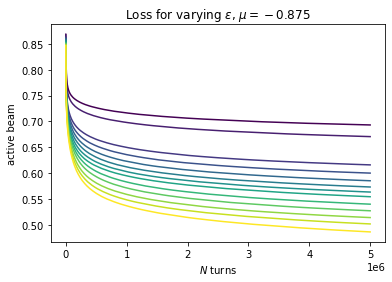

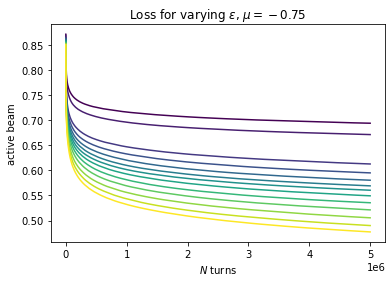

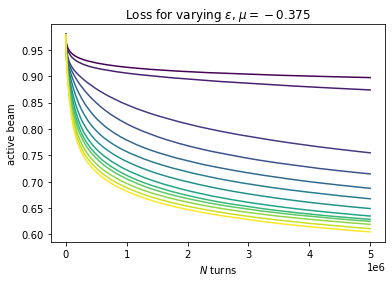

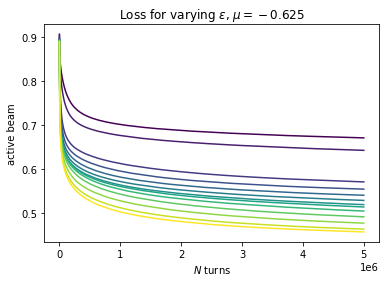

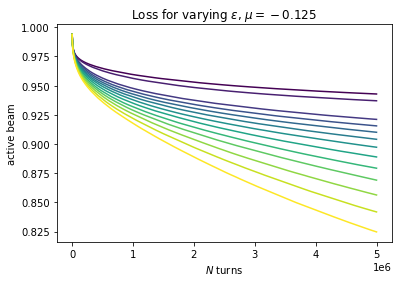

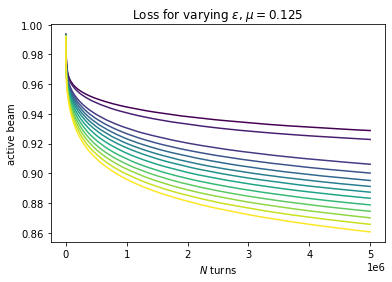

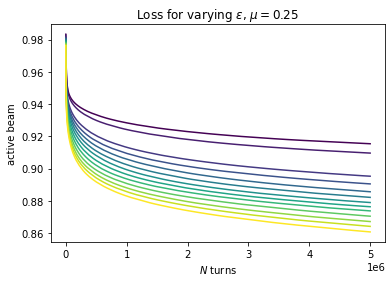

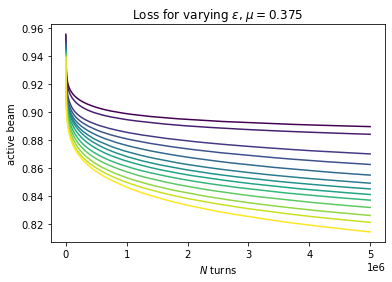

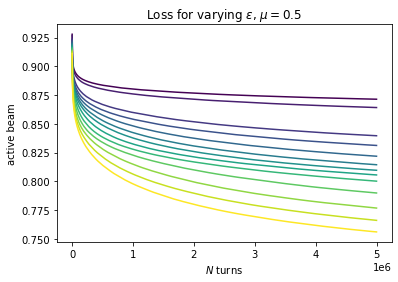

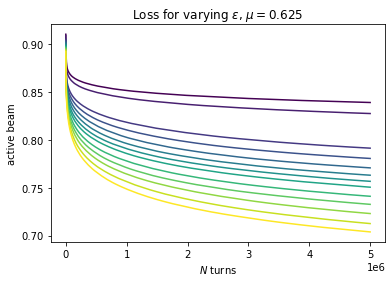

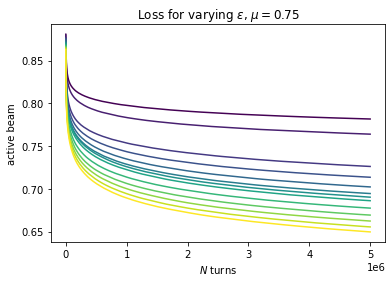

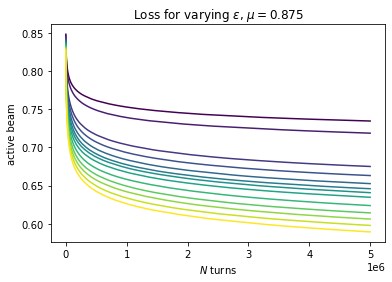

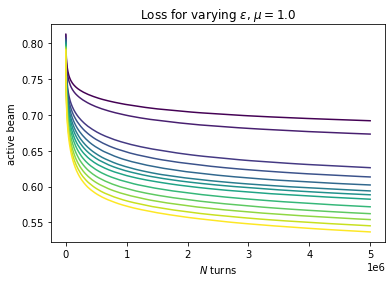

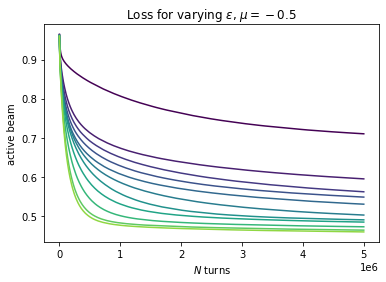

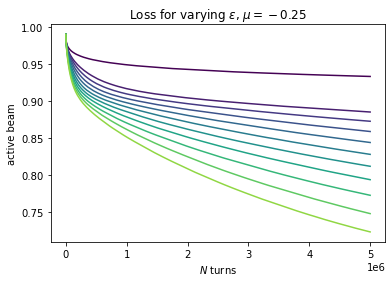

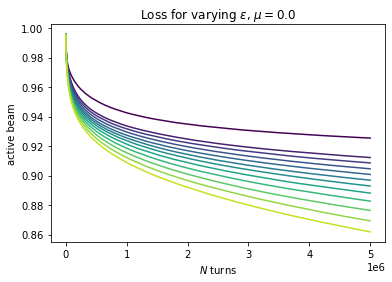

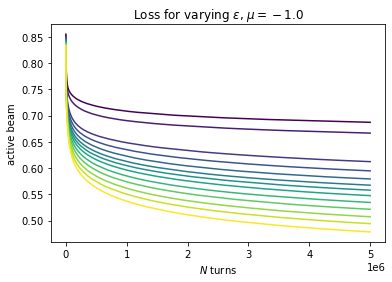

In [17]:
for mu in mu_set:
    plt.figure()
    cmap = matplotlib.cm.get_cmap('viridis')
    index = np.linspace(0, 1, len(epsilon_set))
    j = 0
    for i in range(len(gaussian_losses)):
        if mus[i] == mu:
            plt.plot(turn_sampling, gaussian_losses[i], c=cmap(index[j]))
            j += 1
    plt.xlabel("$N$ turns")
    plt.ylabel("active beam")
    plt.title("Loss for varying $\\epsilon$, $\\mu={}$".format(mu))
    plt.savefig("../img/octo_loss_mu_{}.png".format(mu), dpi=600)

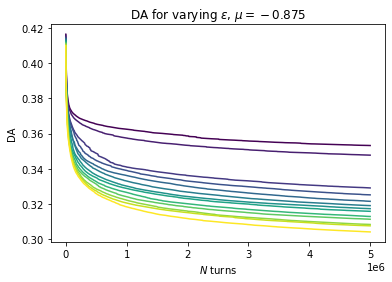

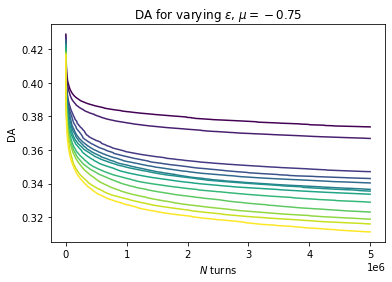

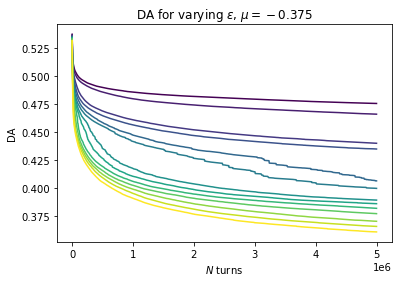

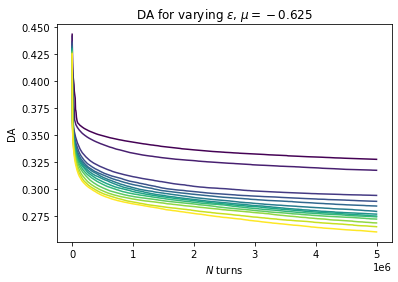

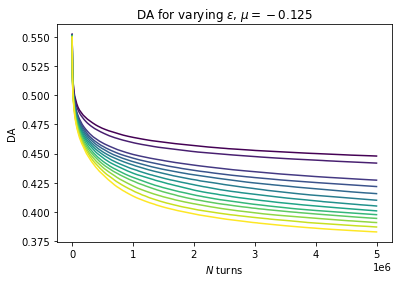

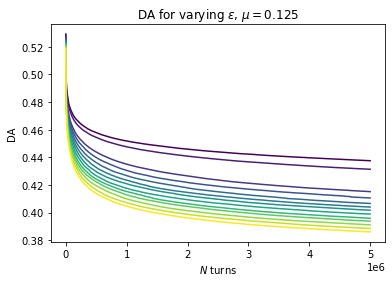

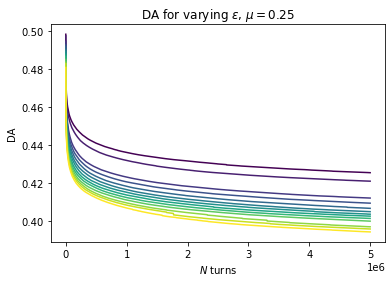

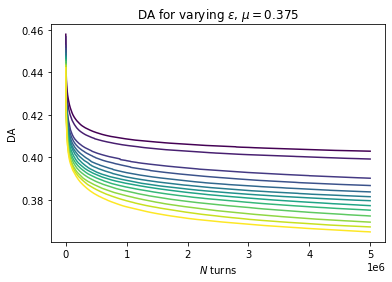

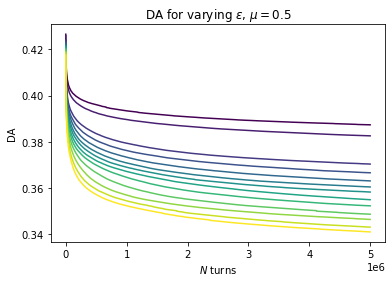

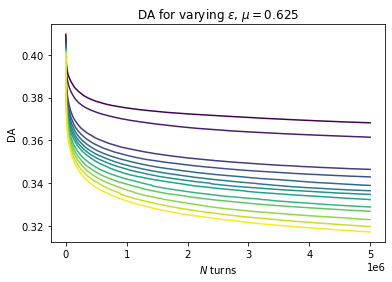

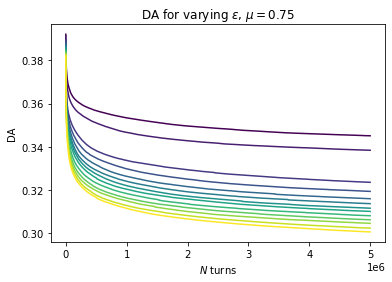

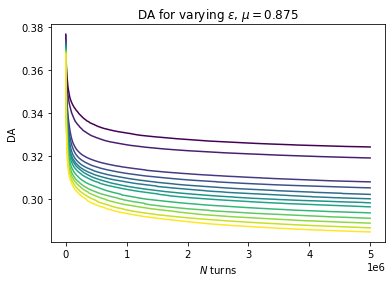

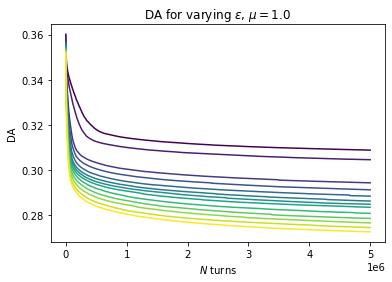

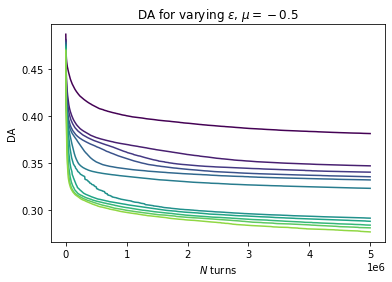

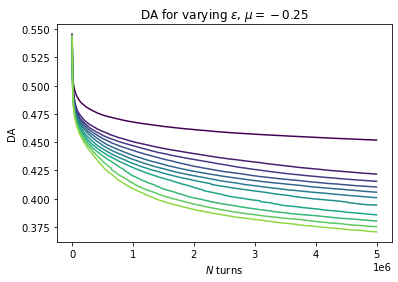

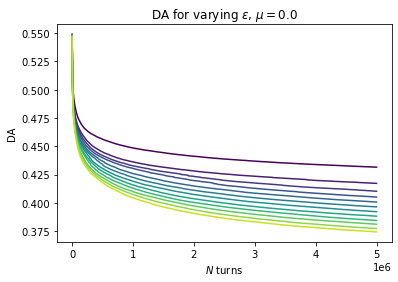

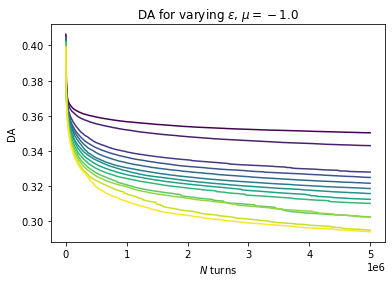

In [18]:
for mu in mu_set:
    plt.figure()
    cmap = matplotlib.cm.get_cmap('viridis')
    index = np.linspace(0, 1, len(epsilon_set))
    j = 0
    for i in range(len(gaussian_losses)):
        if mus[i] == mu:
            plt.plot(turn_sampling, real_DAs[i], c=cmap(index[j]))
            j += 1
    plt.xlabel("$N$ turns")
    plt.ylabel("DA")
    plt.title("DA for varying $\\epsilon$, $\\mu={}$".format(mu))
    plt.savefig("../img/octo_DA_mu_{}.png".format(mu), dpi=600)

### Visualize the difference in DA/reconstructed DA and loss/reconstructed loss

<ipython-input-22-bc444e047141>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, sharex=True)
<ipython-input-22-bc444e047141>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 1, sharex=True)
<ipython-input-22-bc444e047141>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

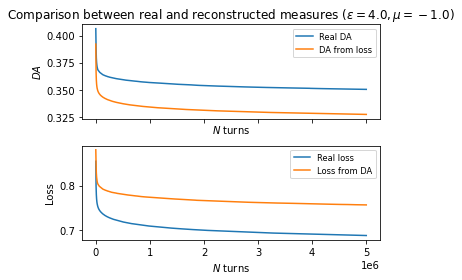

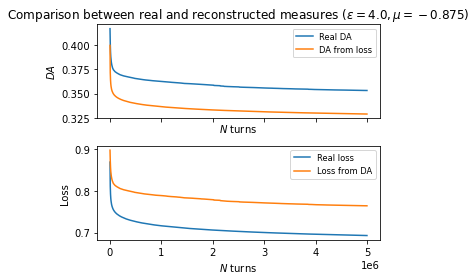

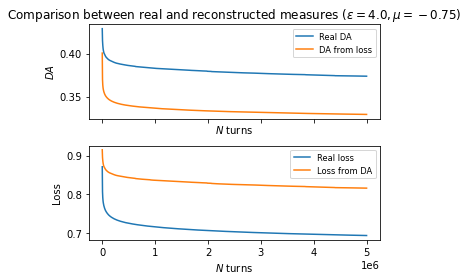

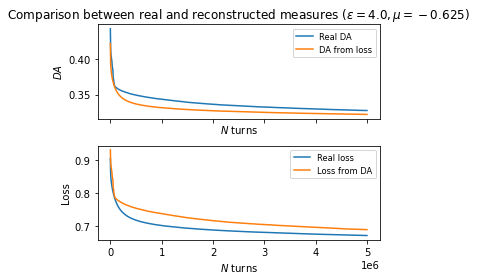

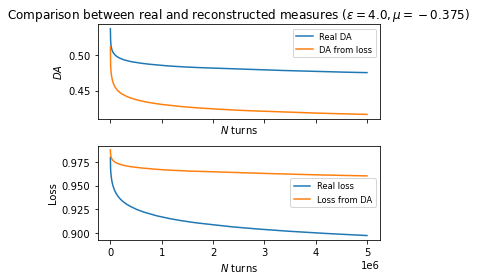

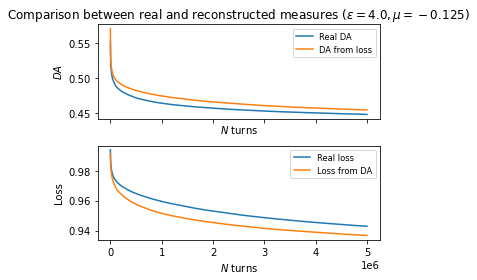

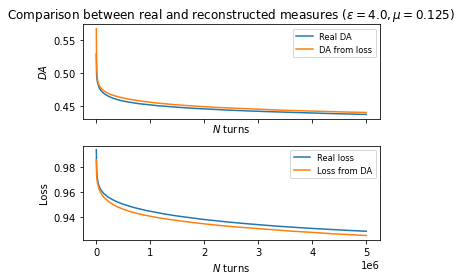

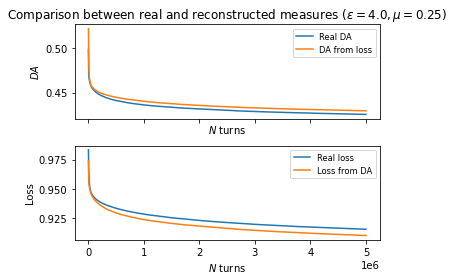

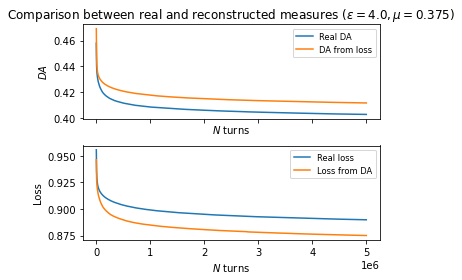

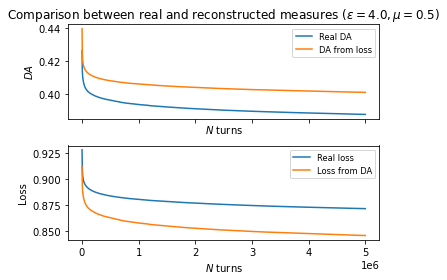

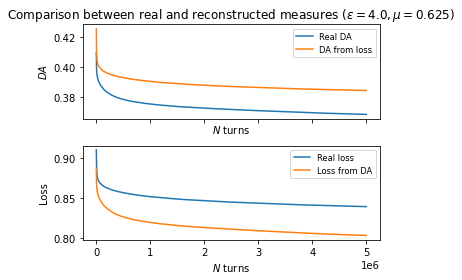

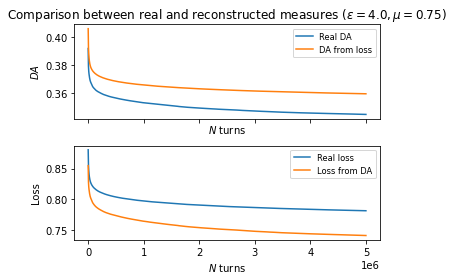

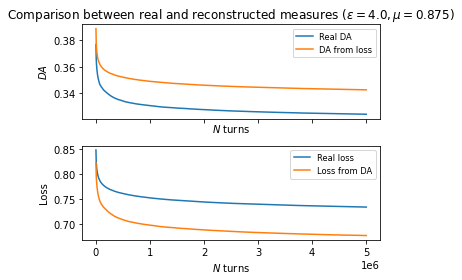

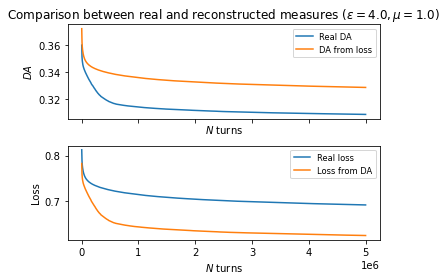

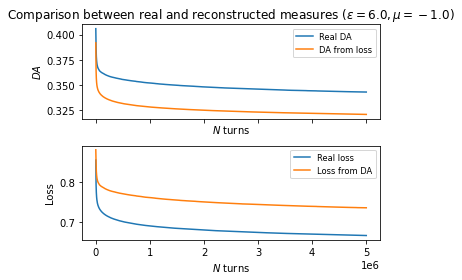

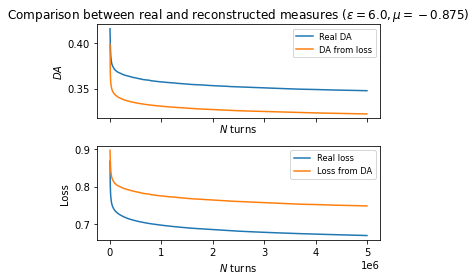

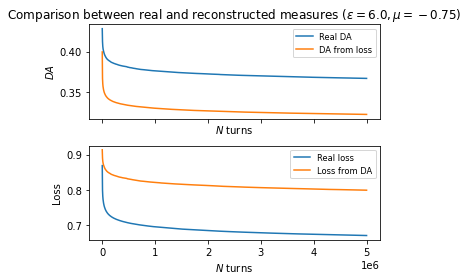

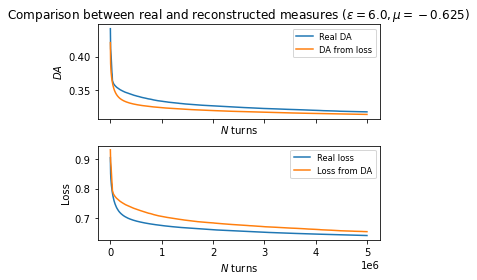

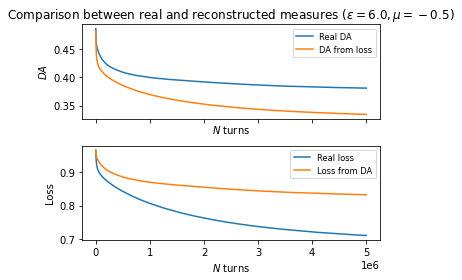

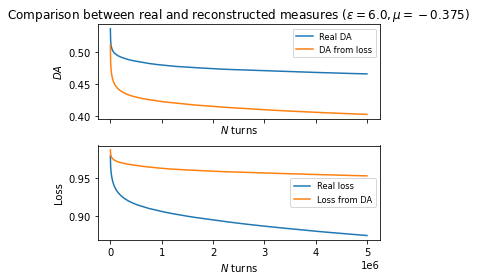

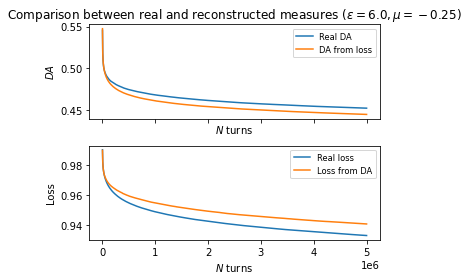

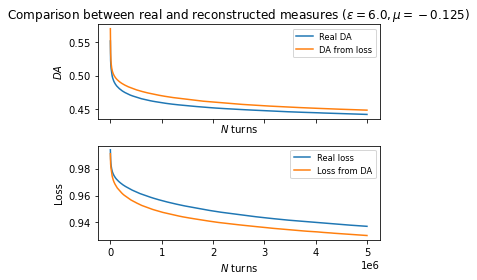

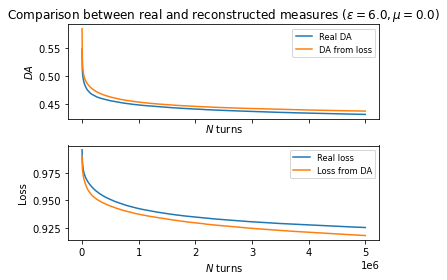

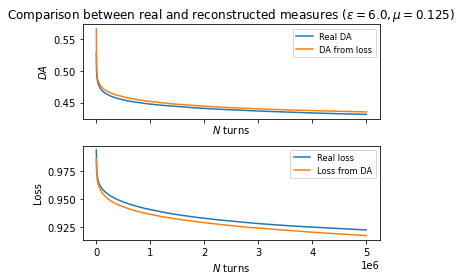

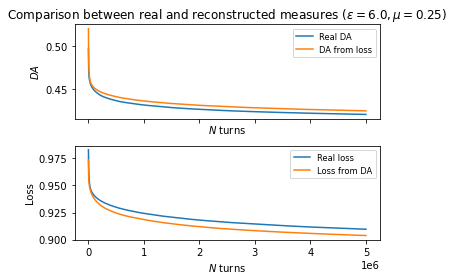

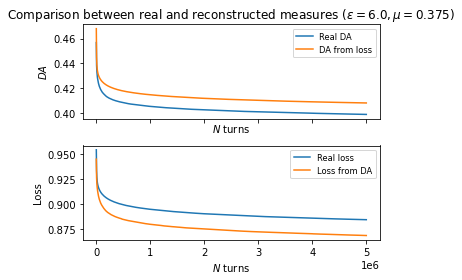

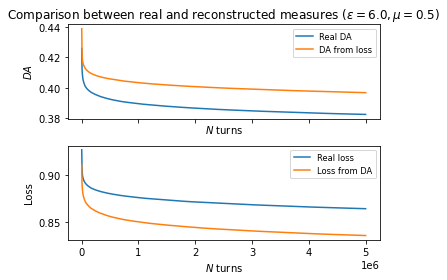

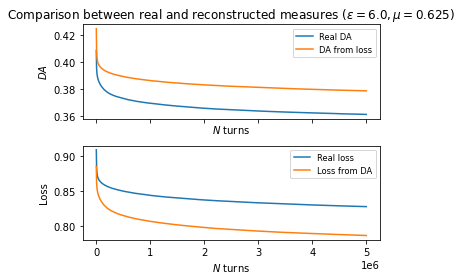

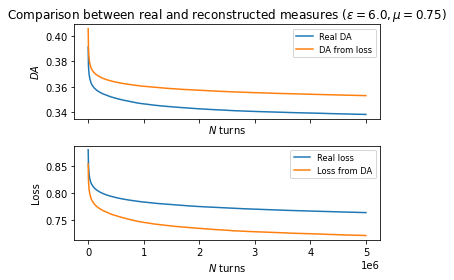

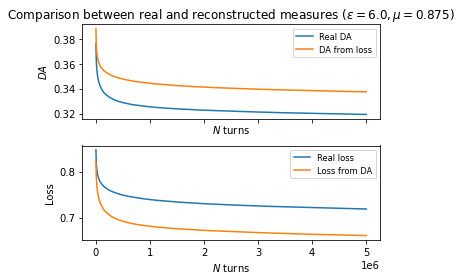

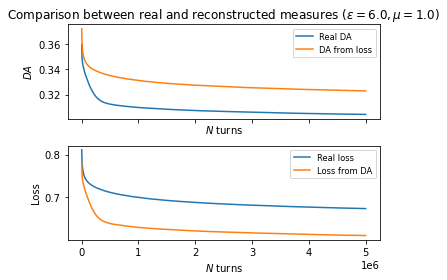

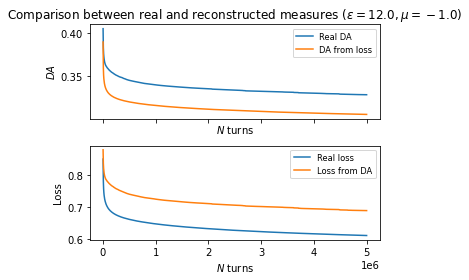

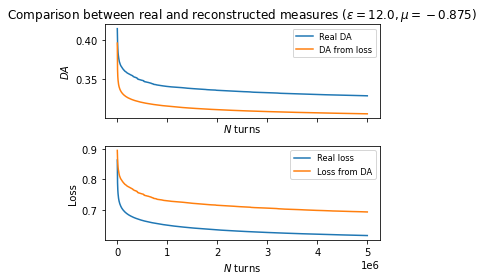

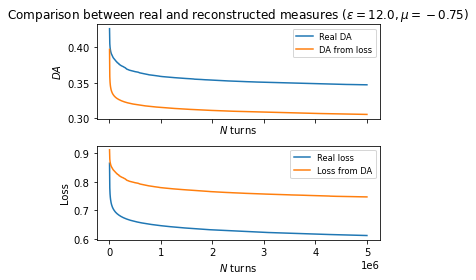

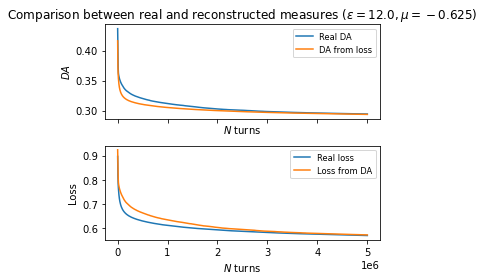

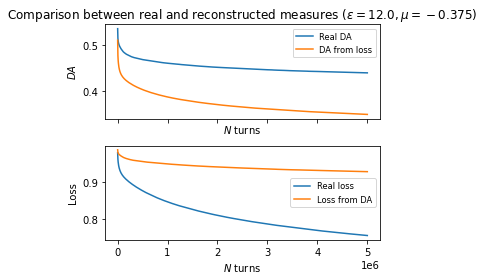

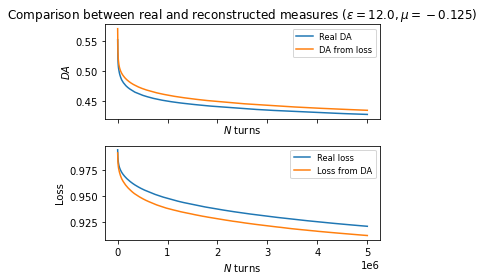

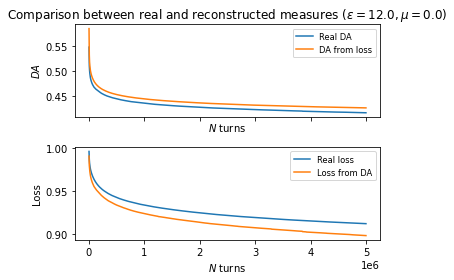

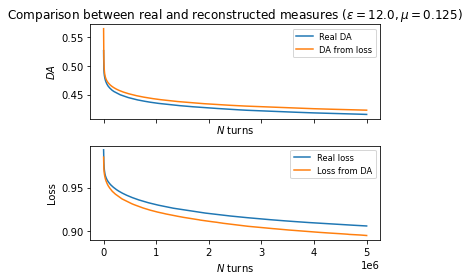

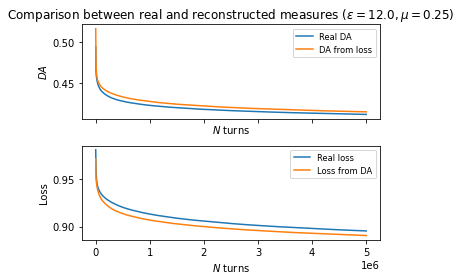

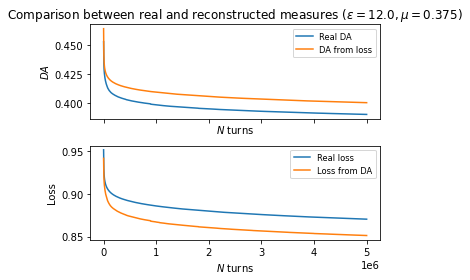

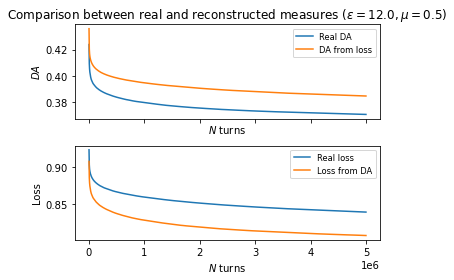

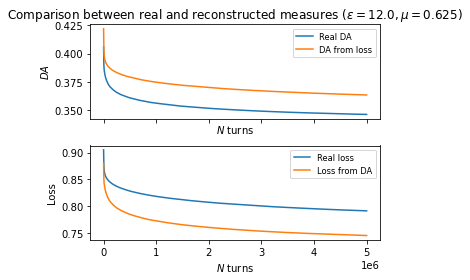

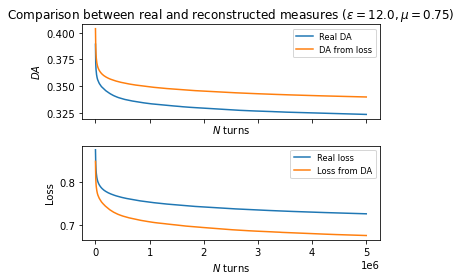

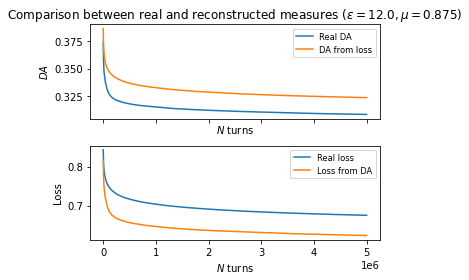

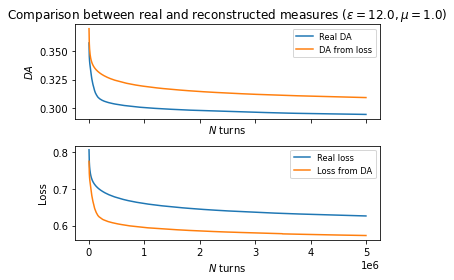

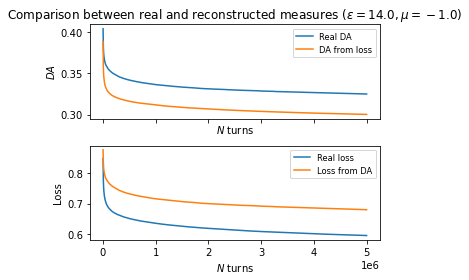

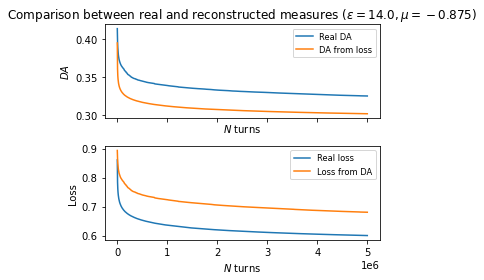

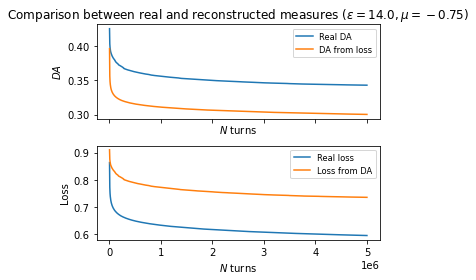

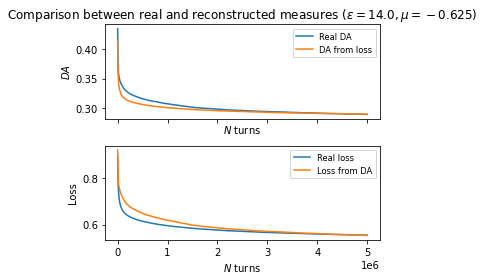

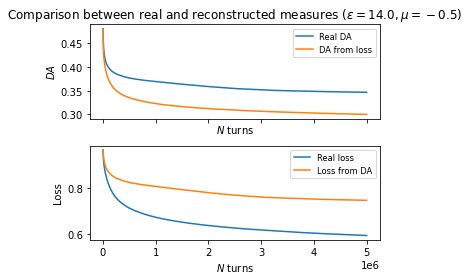

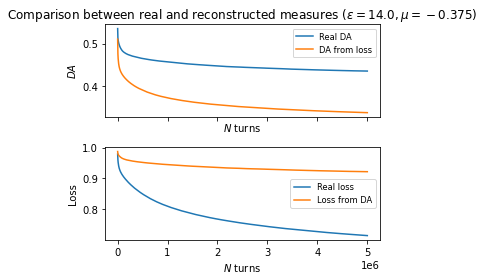

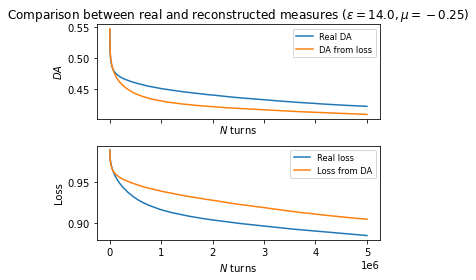

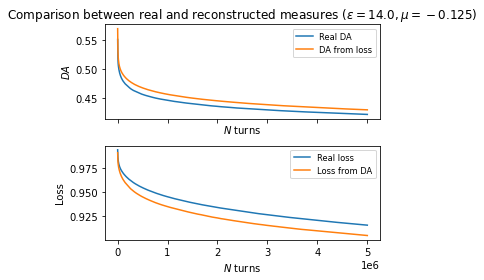

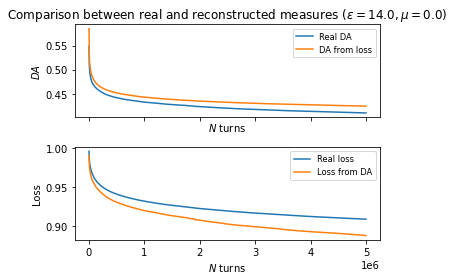

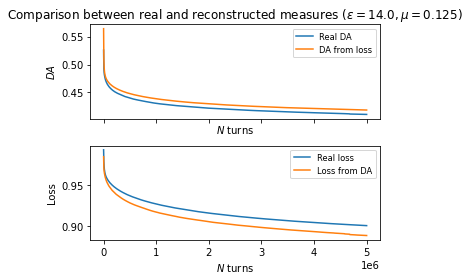

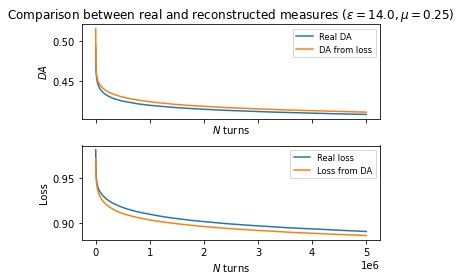

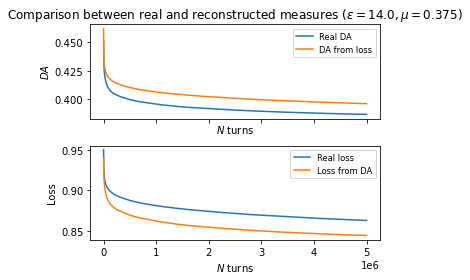

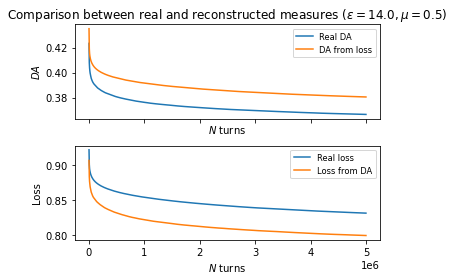

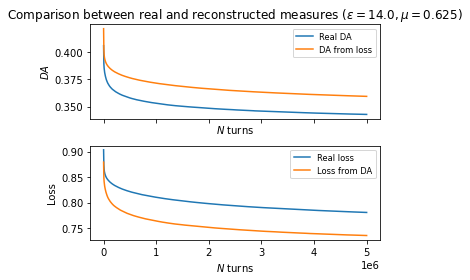

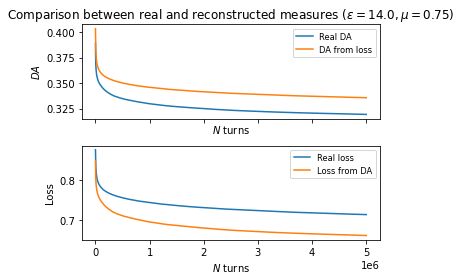

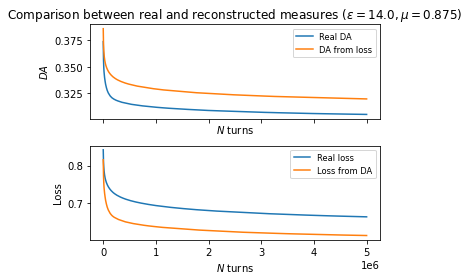

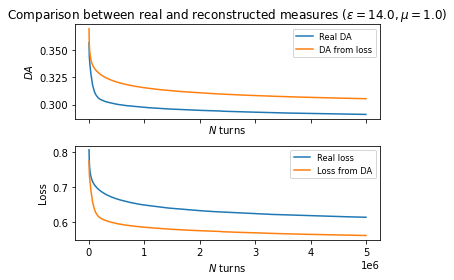

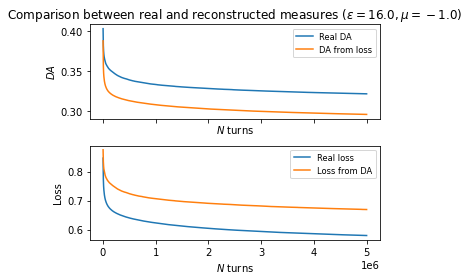

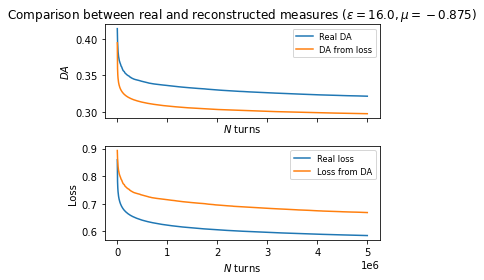

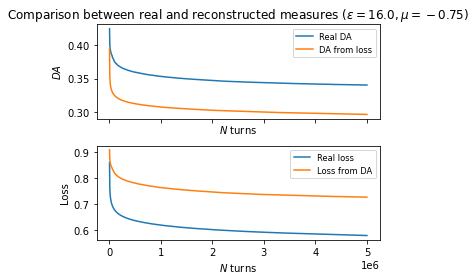

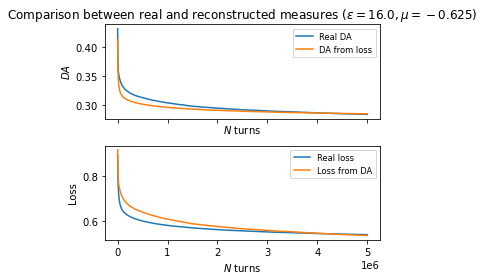

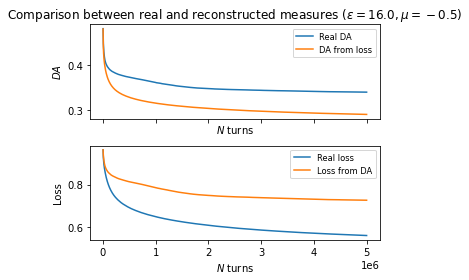

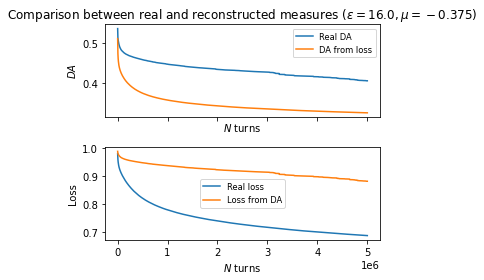

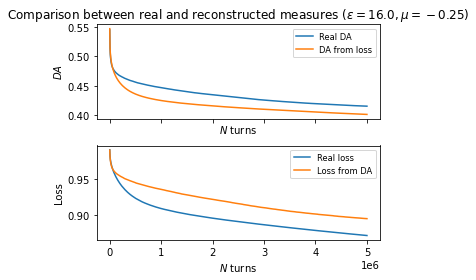

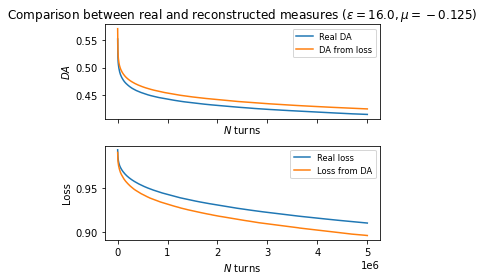

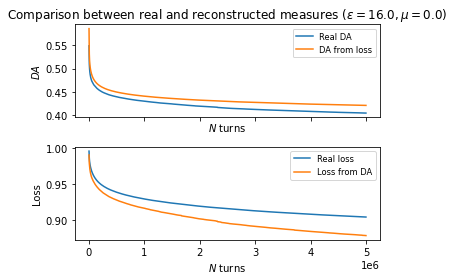

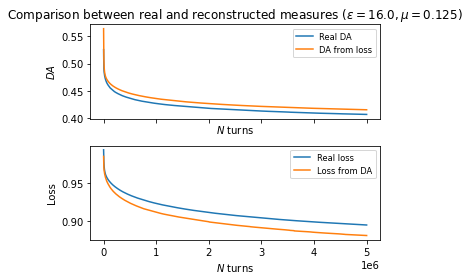

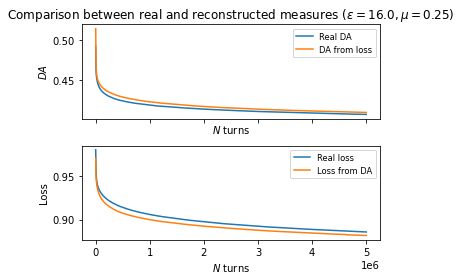

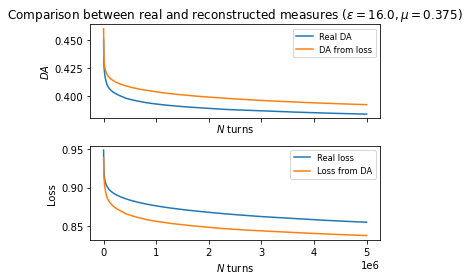

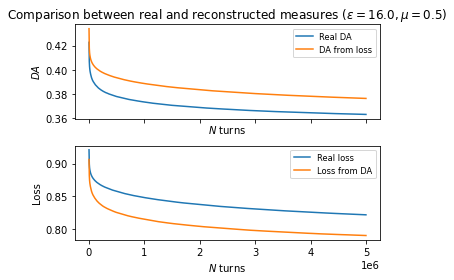

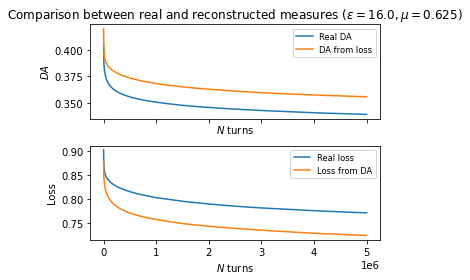

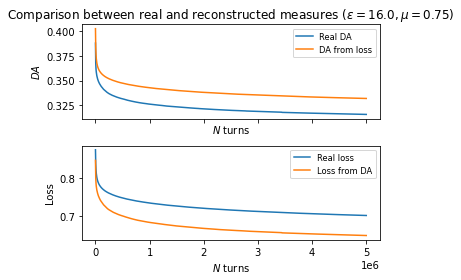

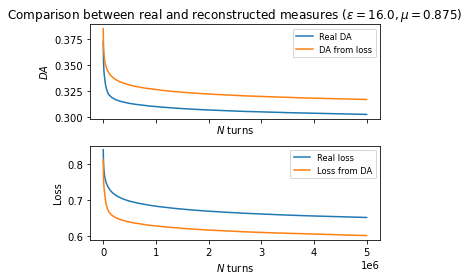

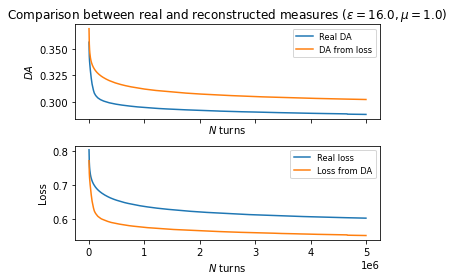

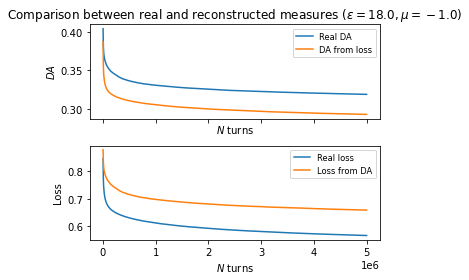

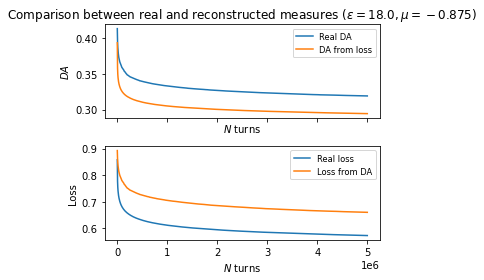

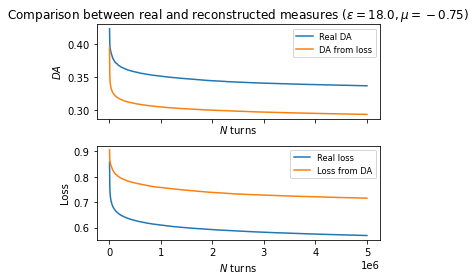

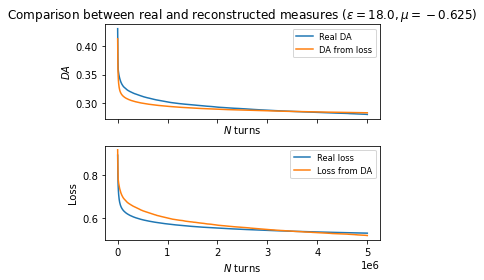

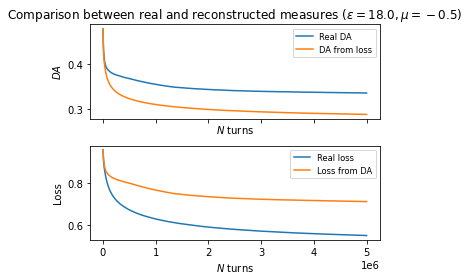

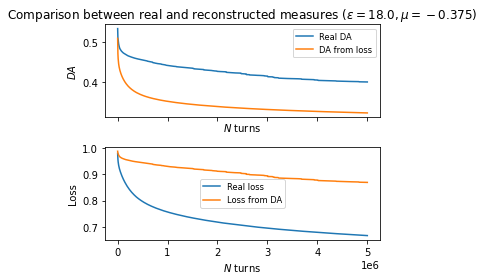

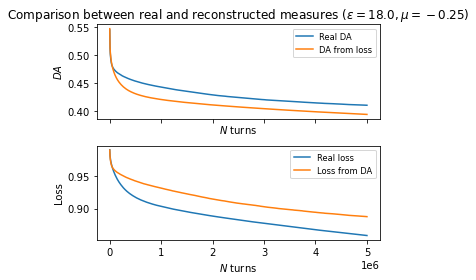

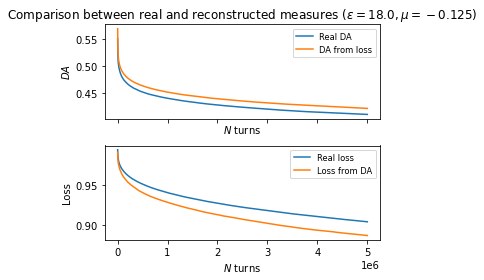

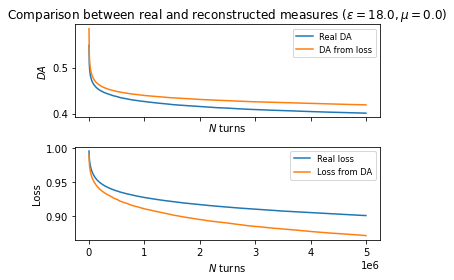

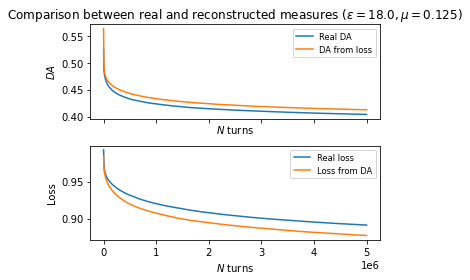

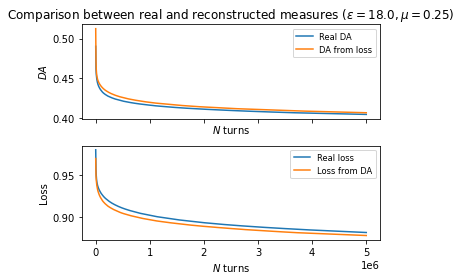

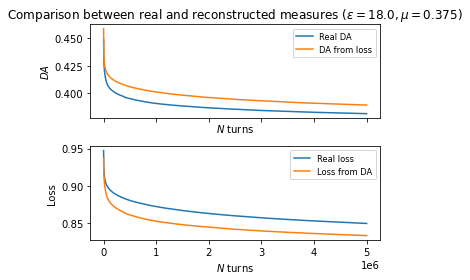

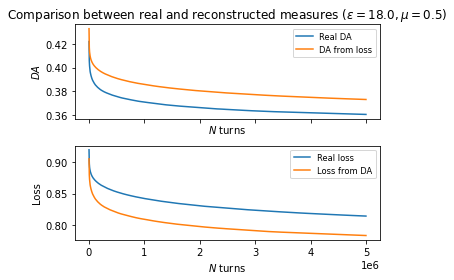

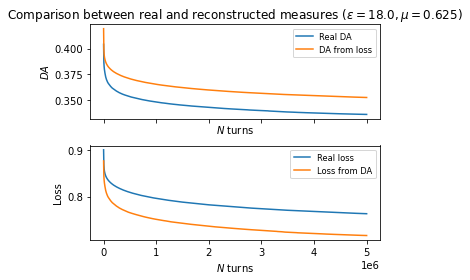

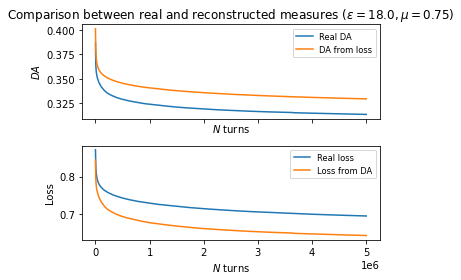

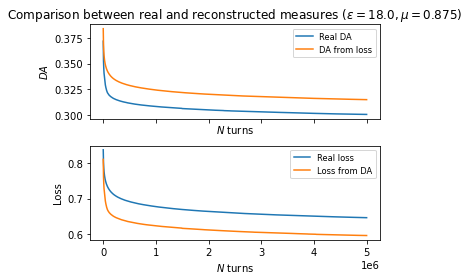

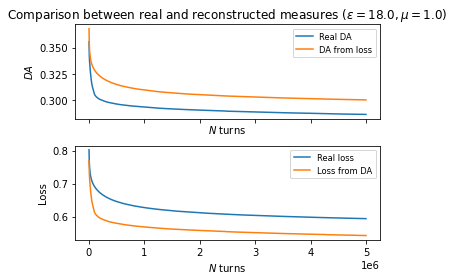

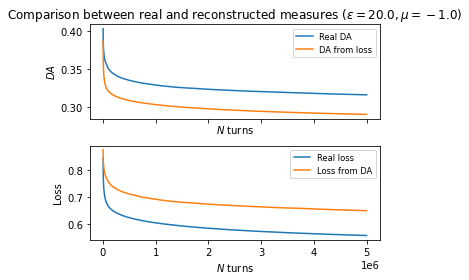

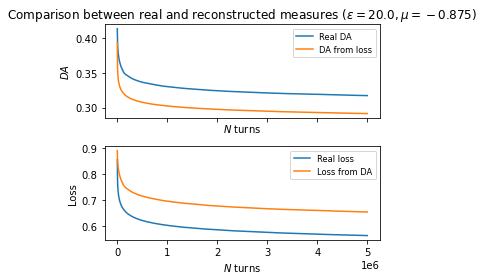

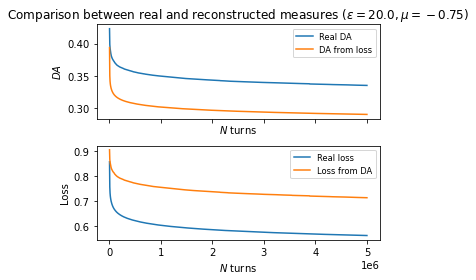

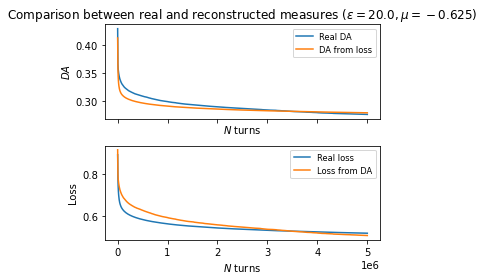

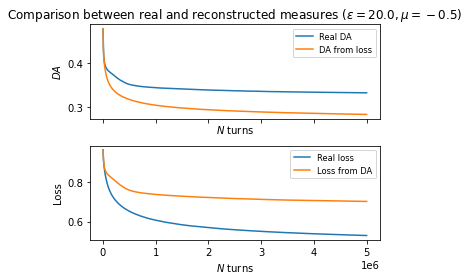

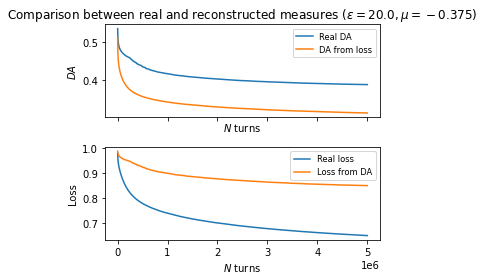

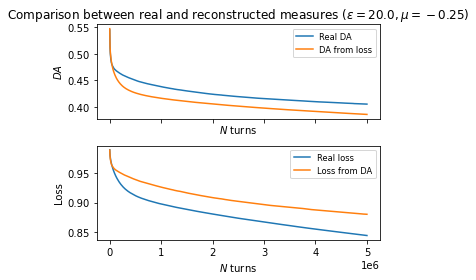

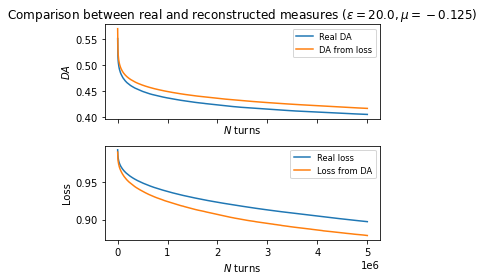

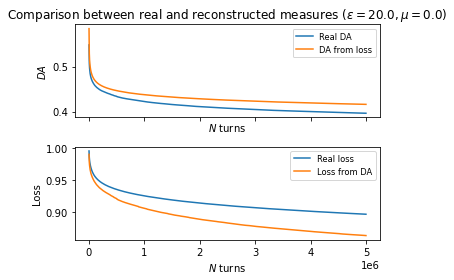

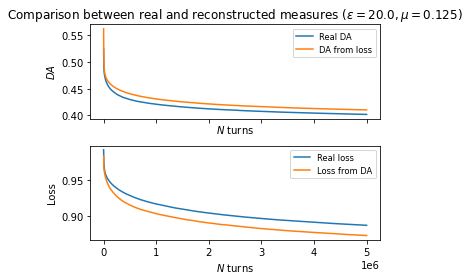

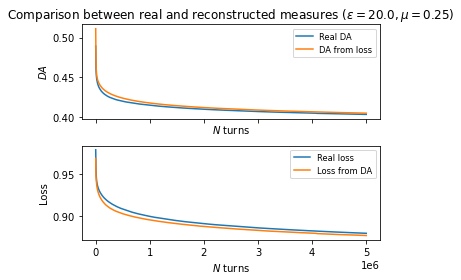

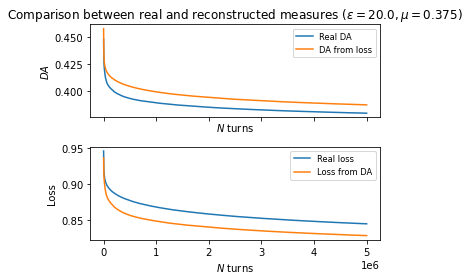

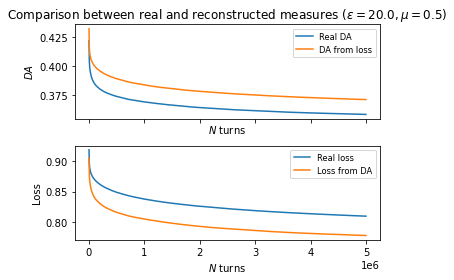

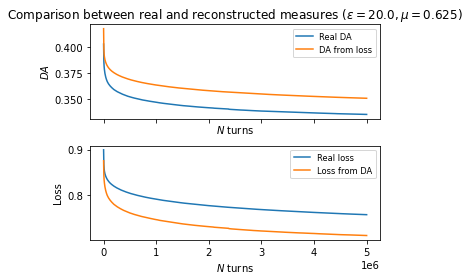

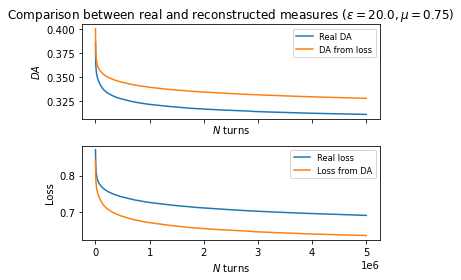

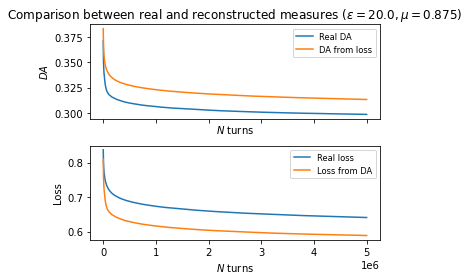

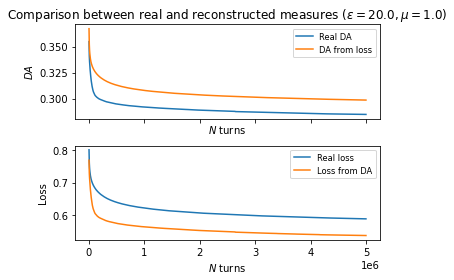

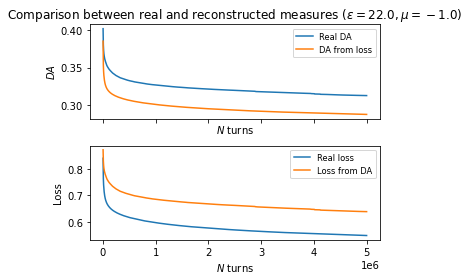

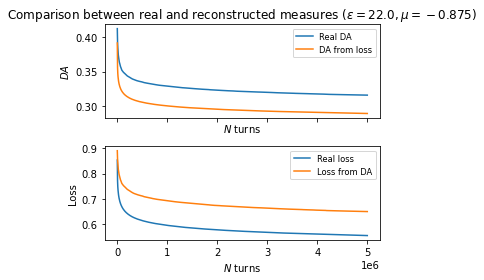

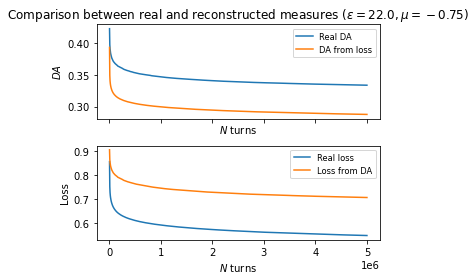

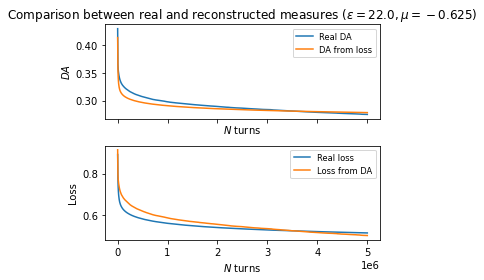

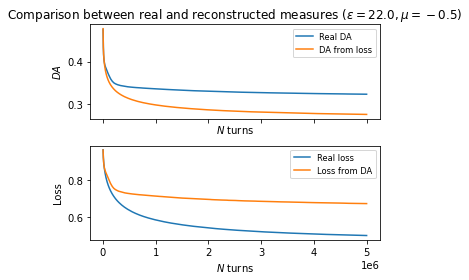

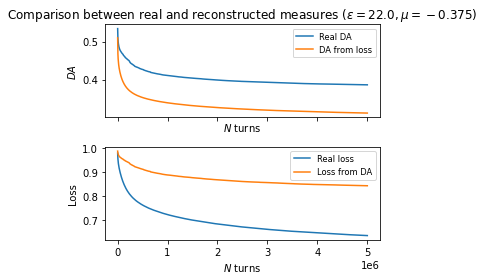

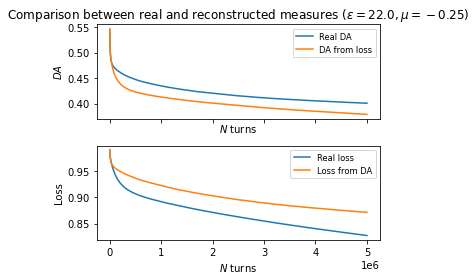

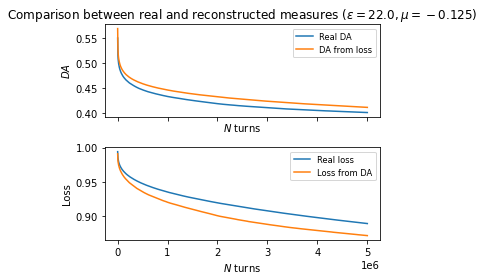

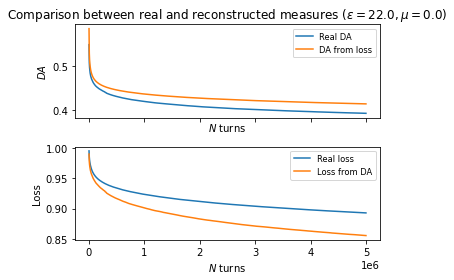

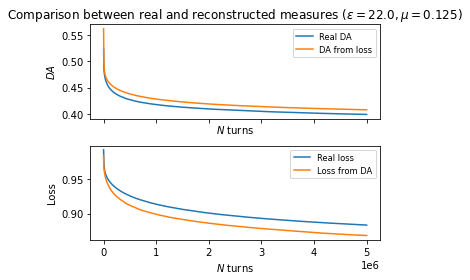

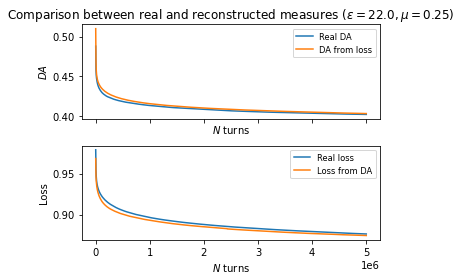

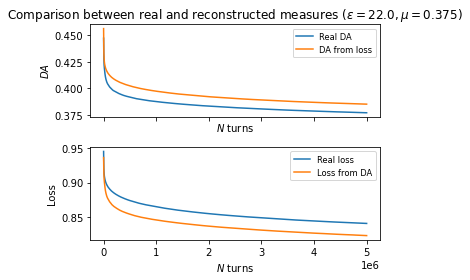

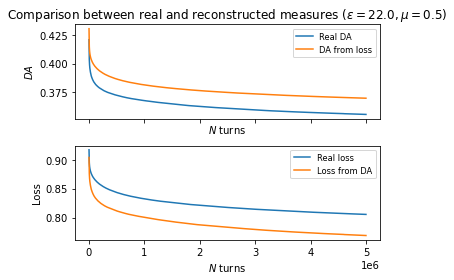

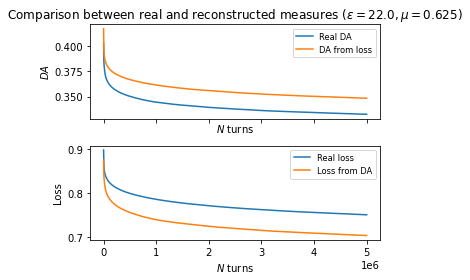

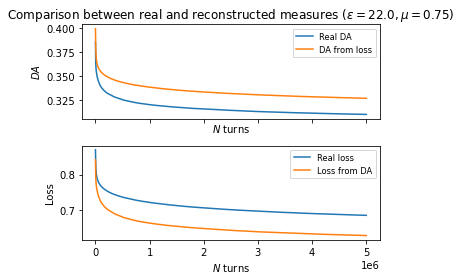

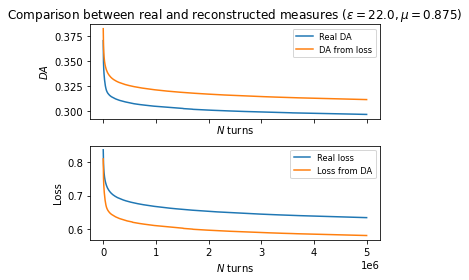

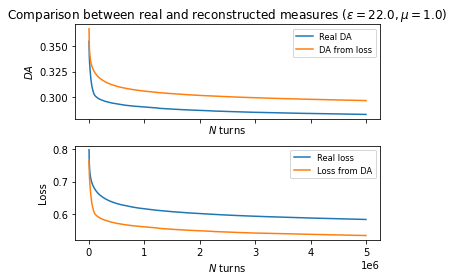

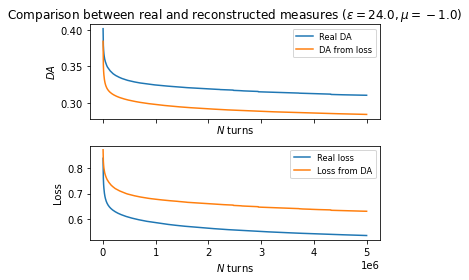

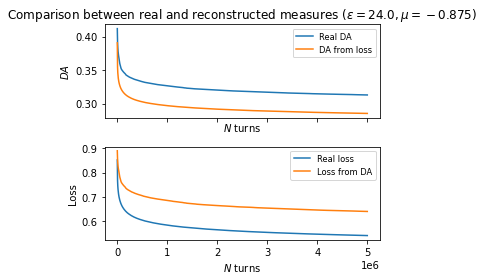

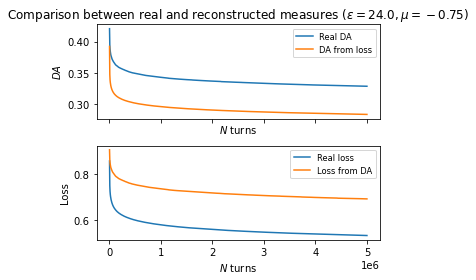

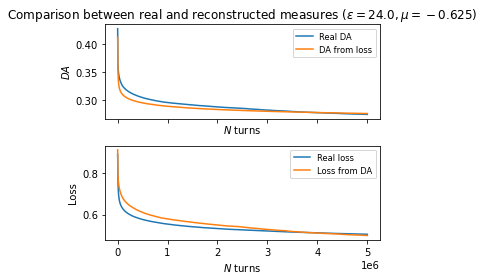

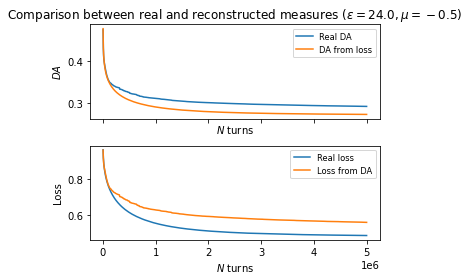

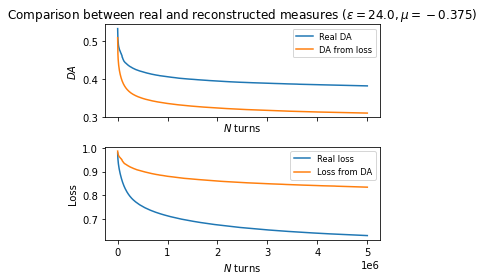

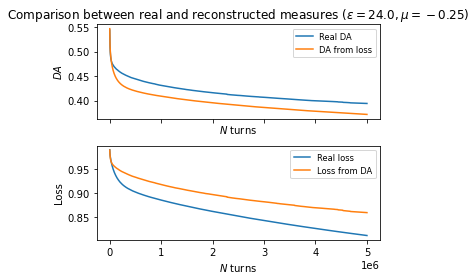

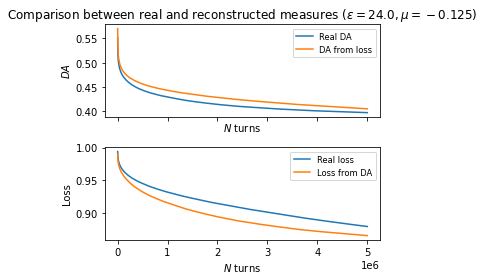

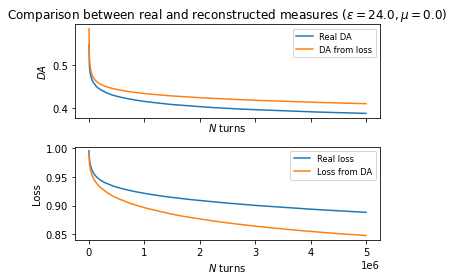

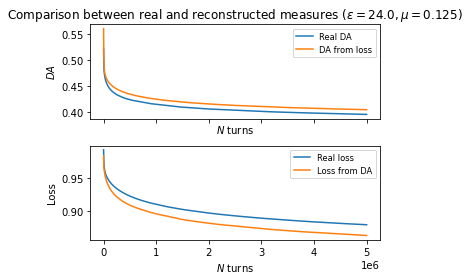

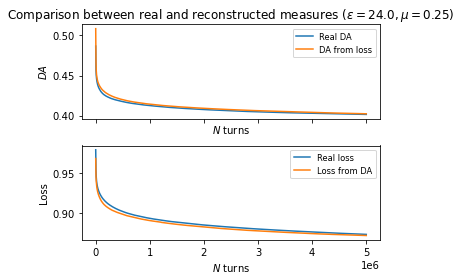

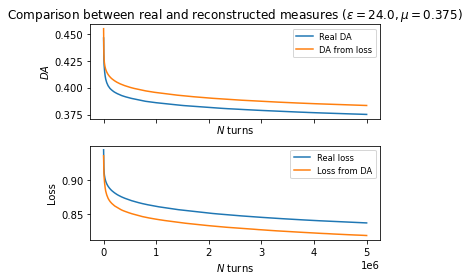

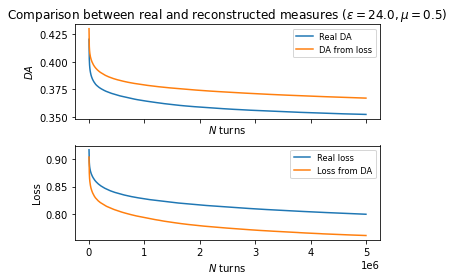

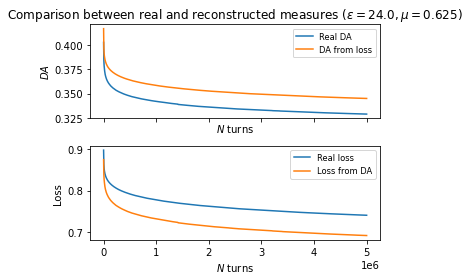

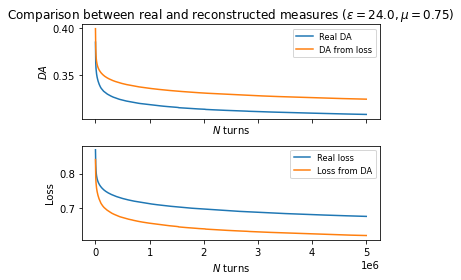

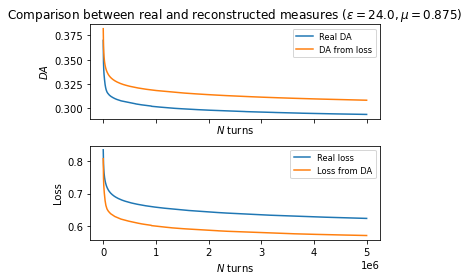

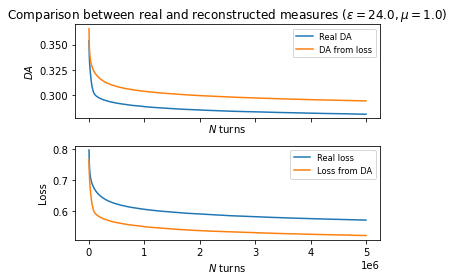

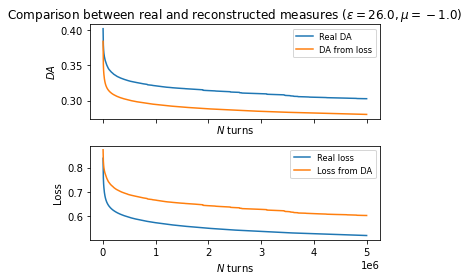

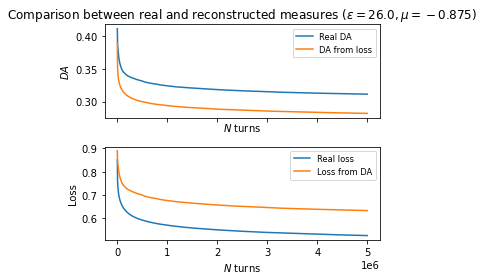

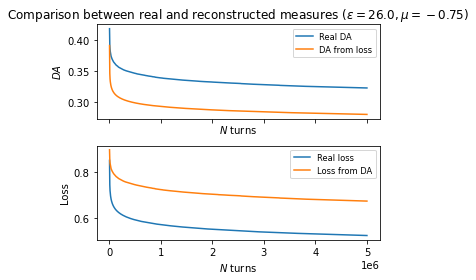

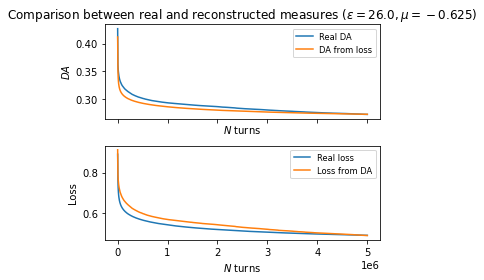

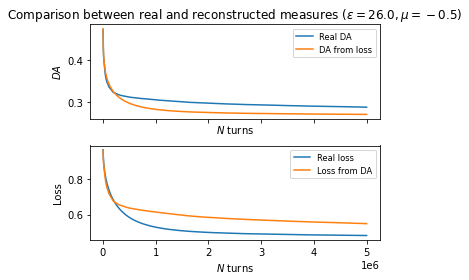

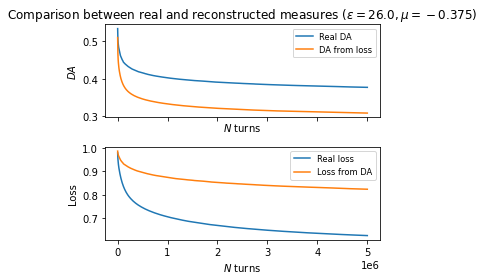

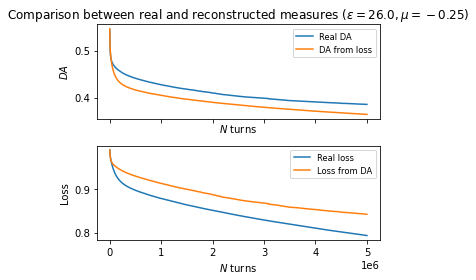

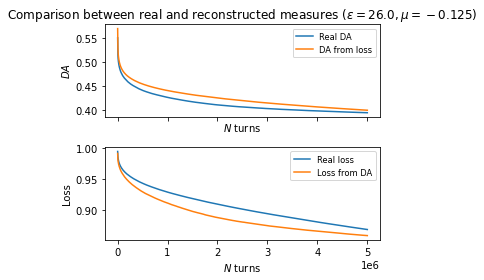

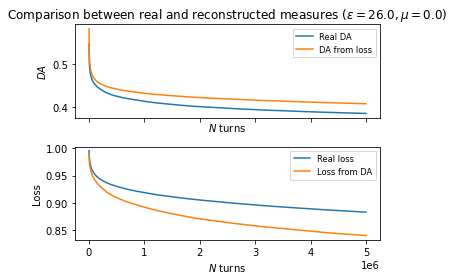

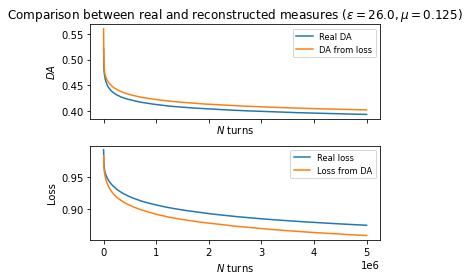

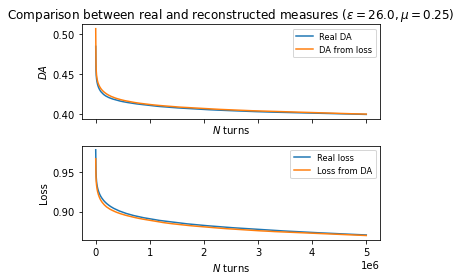

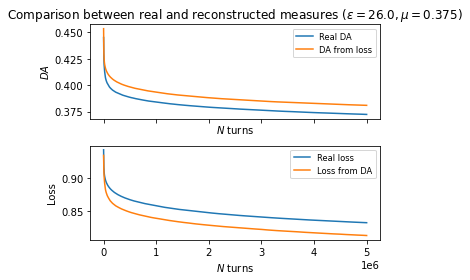

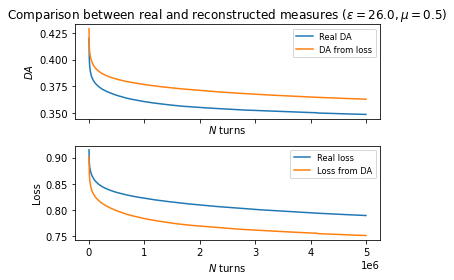

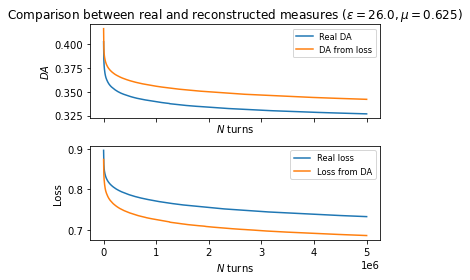

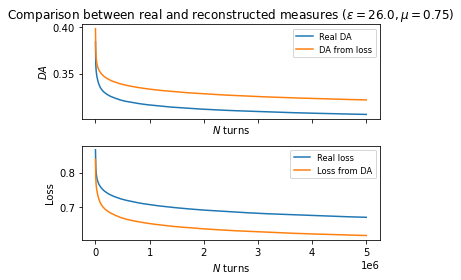

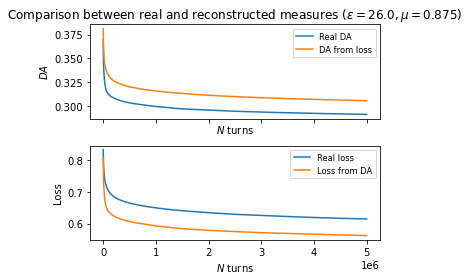

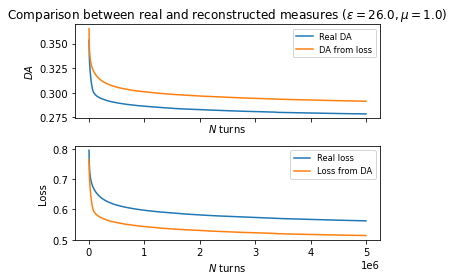

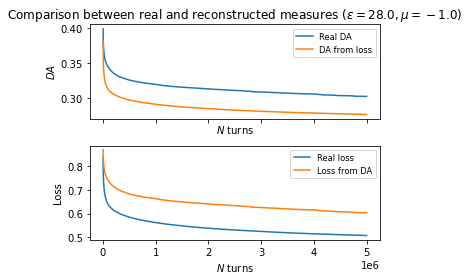

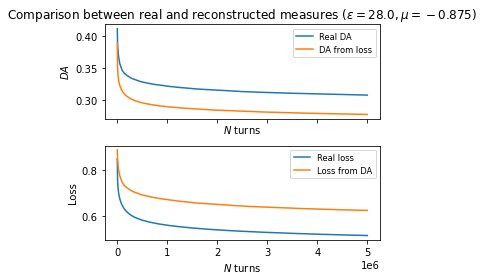

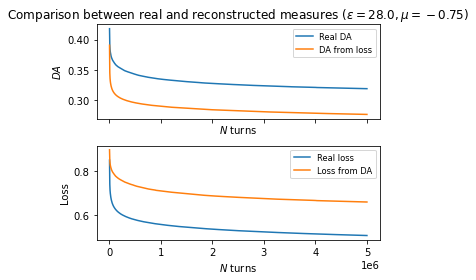

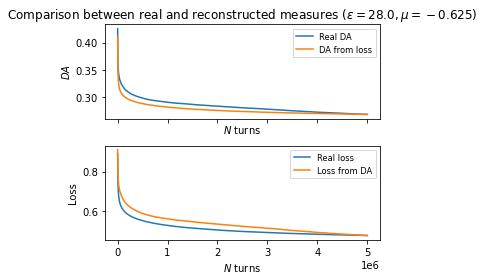

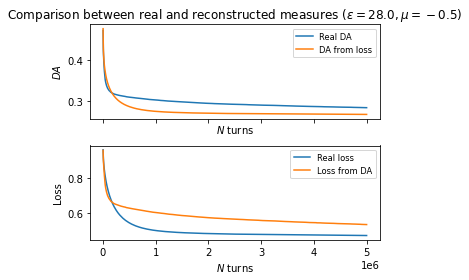

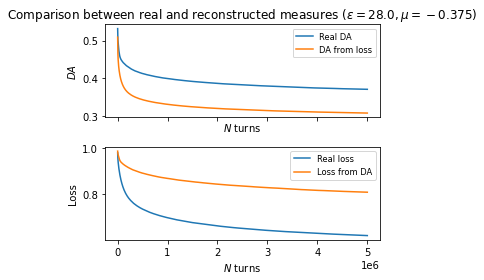

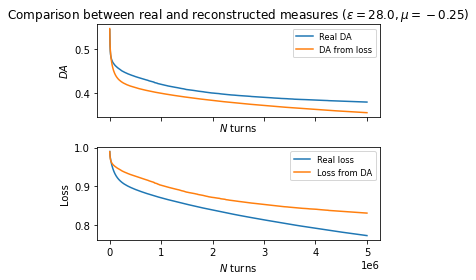

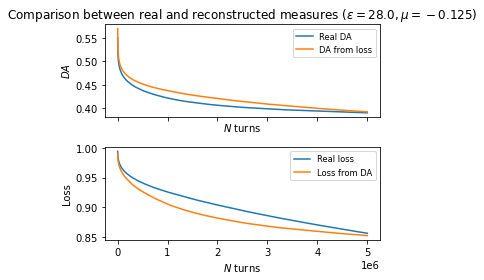

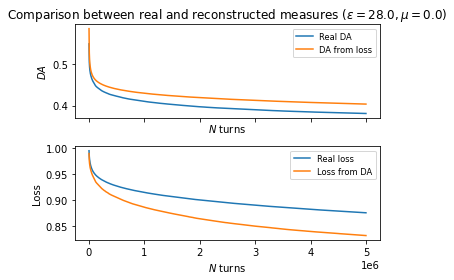

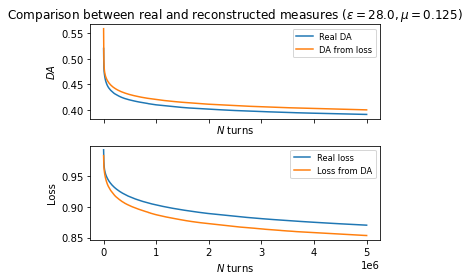

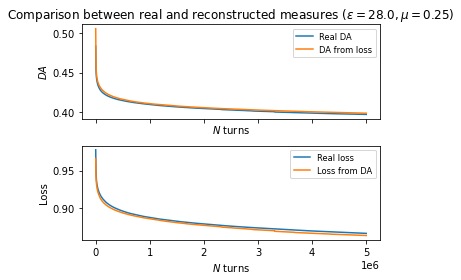

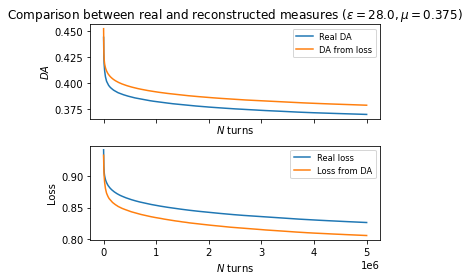

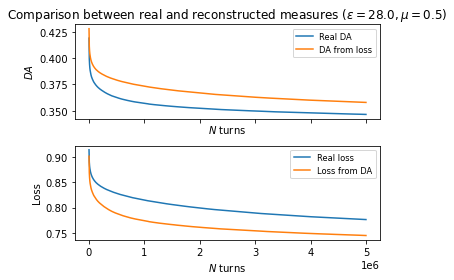

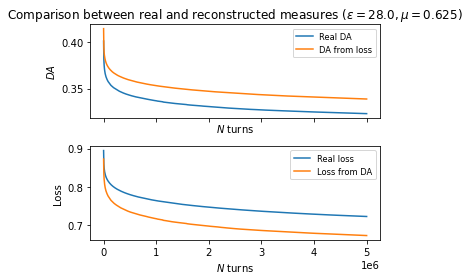

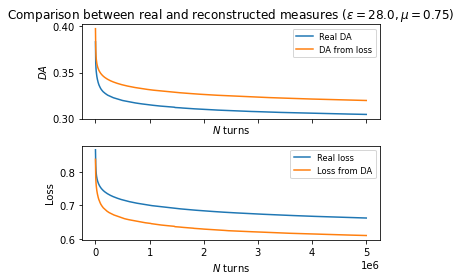

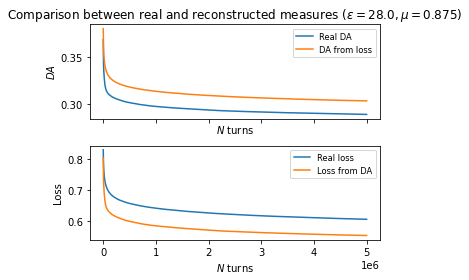

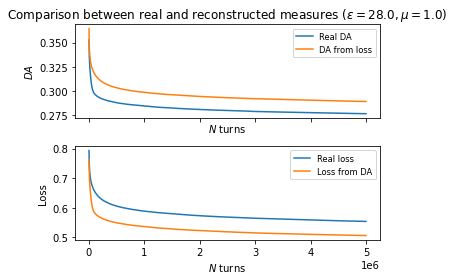

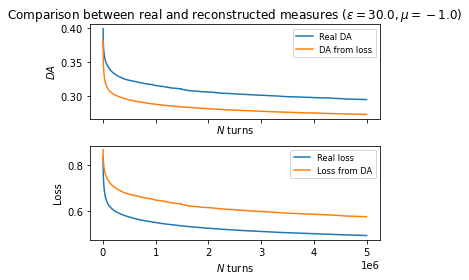

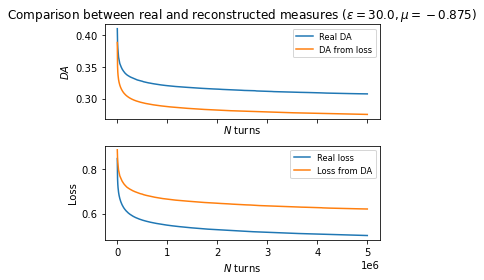

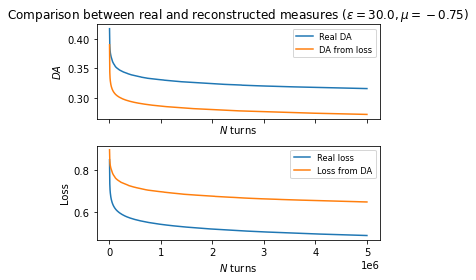

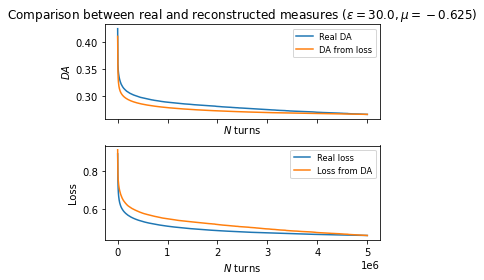

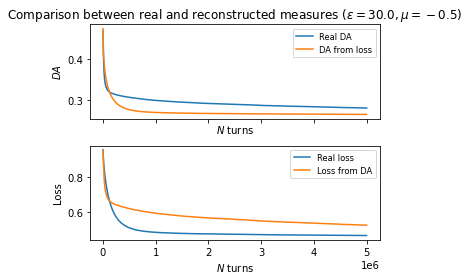

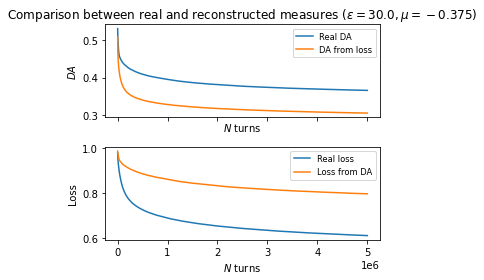

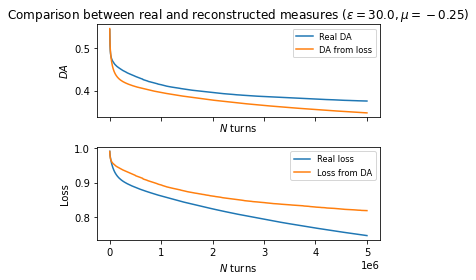

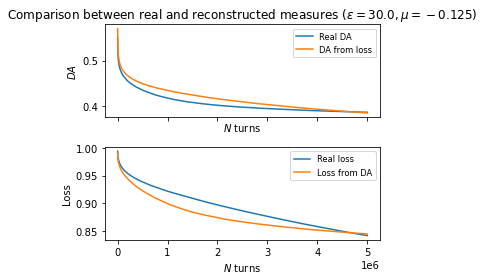

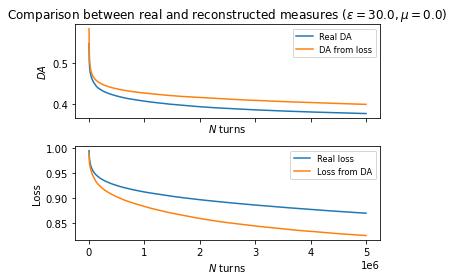

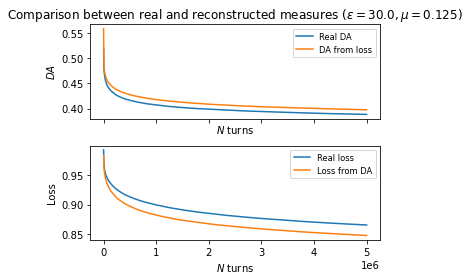

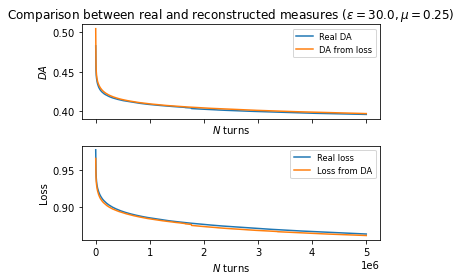

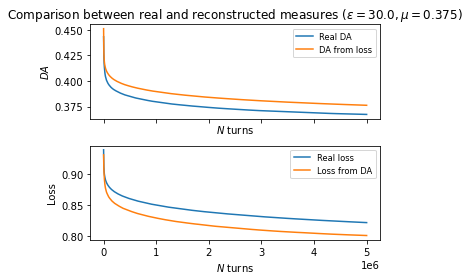

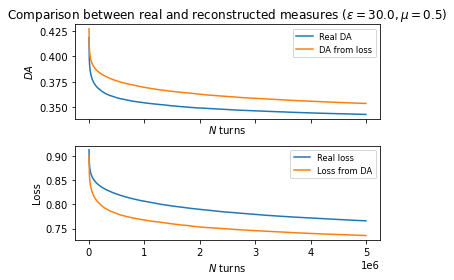

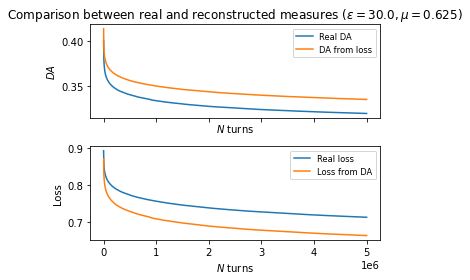

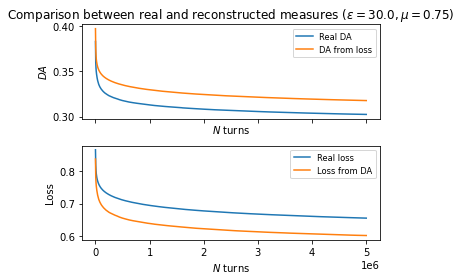

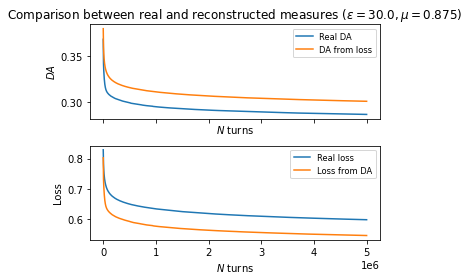

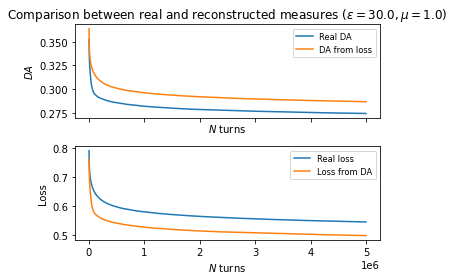

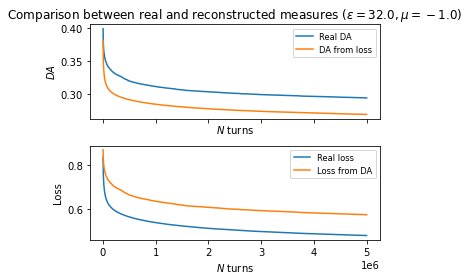

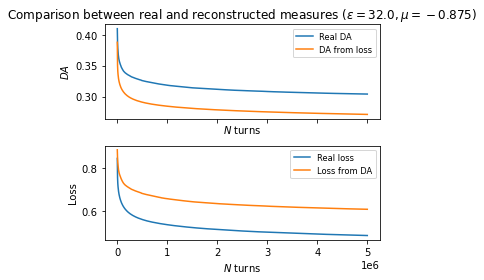

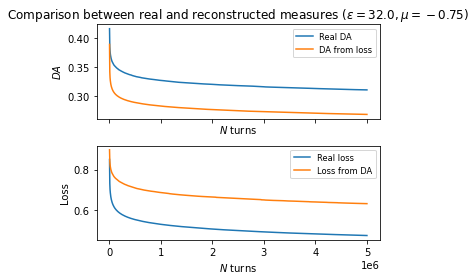

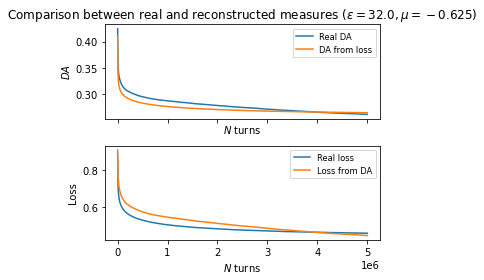

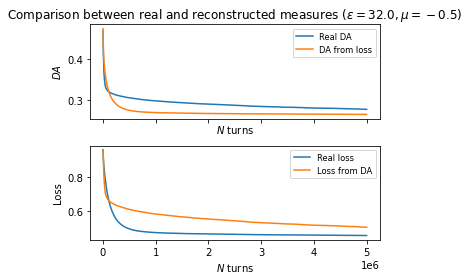

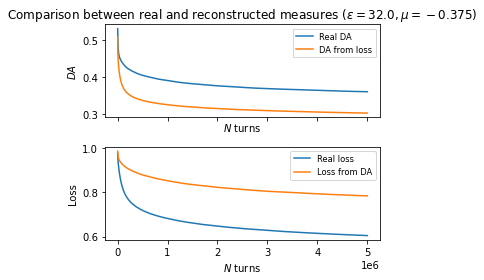

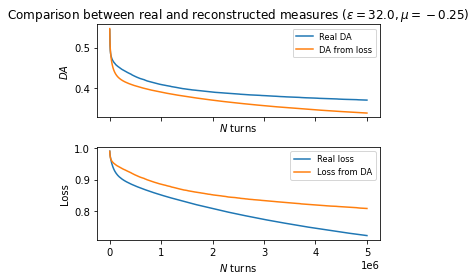

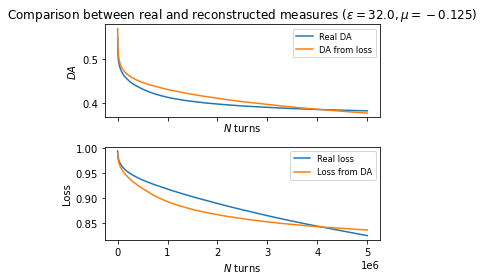

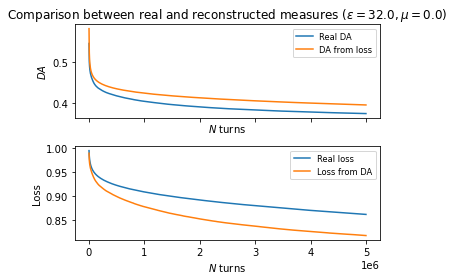

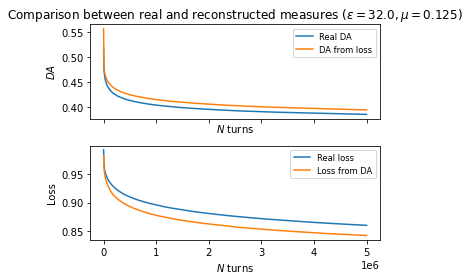

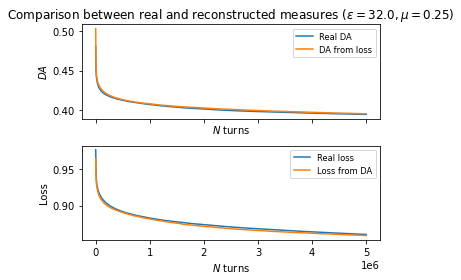

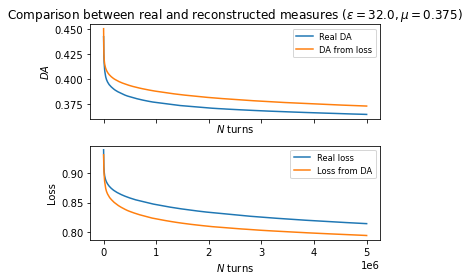

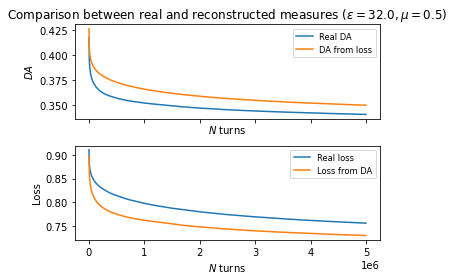

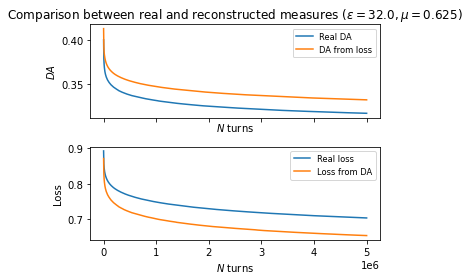

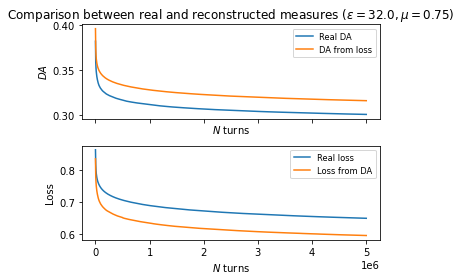

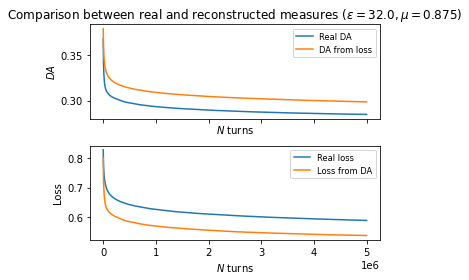

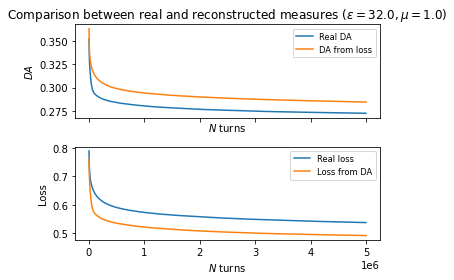

In [22]:
for i in range(len(gaussian_losses)):
    fig, axs = plt.subplots(2, 1, sharex=True)
    
    axs[0].plot(turn_sampling, real_DAs[i], label="Real DA")
    axs[0].plot(turn_sampling, DA_from_loss[i], label="DA from loss")
    axs[0].set_xlabel("$N$ turns")
    axs[0].set_ylabel("$DA$")
    axs[0].legend(fontsize="small")
    
    axs[1].plot(turn_sampling, gaussian_losses[i], label="Real loss")
    axs[1].plot(turn_sampling, loss_from_DA[i], label="Loss from DA")
    axs[1].set_xlabel("$N$ turns")
    axs[1].set_ylabel("Loss")
    axs[1].legend(fontsize="small")
    
    axs[0].set_title("Comparison between real and reconstructed measures $(\\varepsilon={}, \\mu={})$".format(epsilons[i], mus[i]))
    
    plt.tight_layout()
    plt.savefig("../img/octo_real_vs_reconstructed_eps_{}_mu_{}.png".format(epsilons[i], mus[i]), dpi=600)

# General fitting of all the Hénon maps across all models

In [23]:
real_results_model_2 = []
real_finals_model_2 = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_2, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2 = [T[2] for T in TMP]
real_finals_model_2 = [T[3] for T in TMP]

/home/STUDENTI/carlo.montanari3/loss_studies/notebooks/fit_utils.py:161: RuntimeWarning: divide by zero encountered in true_divide
  model = rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))
/home/STUDENTI/carlo.montanari3/loss_studies/notebooks/fit_utils.py:161: RuntimeWarning: divide by zero encountered in true_divide
  model = rho * np.power(k / (2 * np.exp(1)), k) / (np.power(np.log(x / n0), k))
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[i

In [ ]:
with open("../data/octo_henon_fit_2.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2,
        real_finals_model_2,
    ), f)

In [12]:
with open("../data/octo_henon_fit_2.pkl", 'rb') as f:
    real_results_model_2, real_finals_model_2 = pickle.load(f)

In [13]:
k1 = []
k1_err = []
n0_1 = []
n0_1_err = [] 
rho1 = []
rho1_err = []

chi_1 = []
rchi_1 = []

for i, eps in enumerate(epsilons):
    k1.append(real_results_model_2[i].params.get("k").value)
    k1_err.append(real_results_model_2[i].params.get("k").stderr)
    n0_1.append(real_results_model_2[i].params.get("n0").value)
    n0_1_err.append(real_results_model_2[i].params.get("n0").stderr)
    rho1.append(real_results_model_2[i].params.get("rho").value)
    rho1_err.append(real_results_model_2[i].params.get("rho").stderr)
    chi_1.append(real_results_model_2[i].chisqr)
    rchi_1.append(real_results_model_2[i].redchi)

k1 = np.asarray(k1)
k1_err = np.asarray(k1_err)
rho1 = np.asarray(rho1)
rho1_err = np.asarray(rho1_err)
n0_1 = np.asarray(n0_1)
n0_1_err = np.asarray(n0_1_err)
chi_1 = np.asarray(chi_1)
rchi_1 = np.asarray(rchi_1)

In [14]:
real_results_model_2_fixed_n0 = []
real_finals_model_2_fixed_n0 = []

In [15]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_fixed_n0, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_fixed_n0 = [T[2] for T in TMP]
real_finals_model_2_fixed_n0 = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_fix.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_fixed_n0,
        real_finals_model_2_fixed_n0,
    ), f)

In [15]:
with open("../data/octo_henon_fit_2_fix.pkl", 'rb') as f:
    real_results_model_2_fixed_n0, real_finals_model_2_fixed_n0 = pickle.load(f)

In [16]:
k1_fix = []
k1_err_fix = []
rho1_fix = []
rho1_err_fix = []

chi_1_fix = []
rchi_1_fix = []

for i, eps in enumerate(epsilons):
    k1_fix.append(real_results_model_2_fixed_n0[i].params.get("k").value)
    k1_err_fix.append(real_results_model_2_fixed_n0[i].params.get("k").stderr)
    rho1_fix.append(real_results_model_2_fixed_n0[i].params.get("rho").value)
    rho1_err_fix.append(real_results_model_2_fixed_n0[i].params.get("rho").stderr)
    chi_1_fix.append(real_results_model_2_fixed_n0[i].chisqr)
    rchi_1_fix.append(real_results_model_2_fixed_n0[i].redchi)

k1_fix = np.asarray(k1_fix)
k1_err_fix = np.asarray(k1_err_fix)
rho1_fix = np.asarray(rho1_fix)
rho1_err_fix = np.asarray(rho1_err_fix)
chi_1_fix = np.asarray(chi_1_fix)
rchi_1_fix = np.asarray(rchi_1_fix)

In [18]:
real_results_model_4 = []
real_finals_model_4 = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4 = [T[2] for T in TMP]
real_finals_model_4 = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4,
        real_finals_model_4,
    ), f)

In [17]:
with open("../data/octo_henon_fit_4.pkl", 'rb') as f:
    real_results_model_4, real_finals_model_4 = pickle.load(f)

In [18]:
k2 = []
k2_err = []
rho2 = []
rho2_err = []

chi_2 = []
rchi_2 = []

for i, eps in enumerate(epsilons):
    k2.append(real_results_model_4[i].params.get("k").value)
    k2_err.append(real_results_model_4[i].params.get("k").stderr)
    rho2.append(real_results_model_4[i].params.get("rho").value)
    rho2_err.append(real_results_model_4[i].params.get("rho").stderr)
    chi_2.append(real_results_model_4[i].chisqr)
    rchi_2.append(real_results_model_4[i].redchi)

k2 = np.asarray(k2)
k2_err = np.asarray(k2_err)
rho2 = np.asarray(rho2)
rho2_err = np.asarray(rho2_err)
chi_2 = np.asarray(chi_2)
rchi_2 = np.asarray(rchi_2)

In [19]:
real_results_model_4_free = []
real_finals_model_4_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_free = [T[2] for T in TMP]
real_finals_model_4_free = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_free,
        real_finals_model_4_free,
    ), f)

In [20]:
with open("../data/octo_henon_fit_4_free.pkl", 'rb') as f:
    real_results_model_4_free, real_finals_model_4_free = pickle.load(f)

In [21]:
k3 = []
k3_err = []
rho3 = []
rho3_err = []
n0_3 = []
n0_3_err = []

chi_3 = []
rchi_3 = []

for i, eps in enumerate(epsilons):
    k3.append(real_results_model_4_free[i].params.get("k").value)
    k3_err.append(real_results_model_4_free[i].params.get("k").stderr)
    rho3.append(real_results_model_4_free[i].params.get("rho").value)
    rho3_err.append(real_results_model_4_free[i].params.get("rho").stderr)
    n0_3.append(real_results_model_4_free[i].params.get("n0").value)
    n0_3_err.append(real_results_model_4_free[i].params.get("n0").stderr)
    chi_3.append(real_results_model_4_free[i].chisqr)
    rchi_3.append(real_results_model_4_free[i].redchi)

k3 = np.asarray(k3)
k3_err = np.asarray(k3_err)
rho3 = np.asarray(rho3)
rho3_err = np.asarray(rho3_err)
n0_3 = np.asarray(n0_3)
n0_3_err = np.asarray(n0_3_err)
chi_3 = np.asarray(chi_3)
rchi_3 = np.asarray(rchi_3)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], rho1_fix[mus == mu], yerr=rho1_err_fix[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], rho1[mus == mu], yerr=rho1_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], rho2[mus == mu], yerr=rho2_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], rho3[mus == mu], yerr=rho3_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_mu_{}.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], rho1_fix[epsilons == epsilon], yerr=rho1_err_fix[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho1[epsilons == epsilon], yerr=rho1_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], rho2[epsilons == epsilon], yerr=rho2_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho3[epsilons == epsilon], yerr=rho3_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], k1_fix[mus == mu], yerr=k1_err_fix[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], k1[mus == mu], yerr=k1_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], k2[mus == mu], yerr=k2_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], k3[mus == mu], yerr=k3_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_mu_{}.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], k1_fix[epsilons == epsilon], yerr=k1_err_fix[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k1[epsilons == epsilon], yerr=k1_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], k2[epsilons == epsilon], yerr=k2_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k3[epsilons == epsilon], yerr=k3_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$k$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
    
    plt.xscale("log")
    
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_log_eps_{}_mu_{}.png".format(epsilons[i], mus[i]), dpi=600)


In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
        
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_eps_{}_mu_{}.png".format(epsilons[i], mus[i]), dpi=600)


## Same fittings but on DA obtained from losses:

In [ ]:
real_results_model_2_from_loss = []
real_finals_model_2_from_loss = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_2, turn_sampling[::-1], DA_from_loss[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_from_loss = [T[2] for T in TMP]
real_finals_model_2_from_loss = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_from_loss.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_from_loss,
        real_finals_model_2_from_loss,
    ), f)

In [22]:
with open("../data/octo_henon_fit_2_from_loss.pkl", 'rb') as f:
    real_results_model_2_from_loss, real_finals_model_2_from_loss = pickle.load(f)

In [23]:
k1_from_loss = []
k1_err_from_loss = []
n0_1_from_loss = []
n0_1_err_from_loss = [] 
rho1_from_loss = []
rho1_err_from_loss = []

chi_1_from_loss = []
rchi_1_from_loss = []

for i, eps in enumerate(epsilons):
    k1_from_loss.append(real_results_model_2_from_loss[i].params.get("k").value)
    k1_err_from_loss.append(real_results_model_2_from_loss[i].params.get("k").stderr)
    n0_1_from_loss.append(real_results_model_2_from_loss[i].params.get("n0").value)
    n0_1_err_from_loss.append(real_results_model_2_from_loss[i].params.get("n0").stderr)
    rho1_from_loss.append(real_results_model_2_from_loss[i].params.get("rho").value)
    rho1_err_from_loss.append(real_results_model_2_from_loss[i].params.get("rho").stderr)
    chi_1_from_loss.append(real_results_model_2_from_loss[i].chisqr)
    rchi_1_from_loss.append(real_results_model_2_from_loss[i].redchi)

k1_from_loss = np.asarray(k1_from_loss)
k1_err_from_loss = np.asarray(k1_err_from_loss)
rho1_from_loss = np.asarray(rho1_from_loss)
rho1_err_from_loss = np.asarray(rho1_err_from_loss)
n0_1_from_loss = np.asarray(n0_1_from_loss)
n0_1_err_from_loss = np.asarray(n0_1_err_from_loss)
chi_1_from_loss = np.asarray(chi_1_from_loss)
rchi_1_from_loss = np.asarray(rchi_1_from_loss)

In [24]:
real_results_model_2_fixed_n0_from_loss = []
real_finals_model_2_fixed_n0_from_loss = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_fixed_n0, turn_sampling[::-1], DA_from_loss[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_fixed_n0_from_loss = [T[2] for T in TMP]
real_finals_model_2_fixed_n0_from_loss = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_fix_from_loss.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_fixed_n0_from_loss,
        real_finals_model_2_fixed_n0_from_loss,
    ), f)

In [25]:
with open("../data/octo_henon_fit_2_fix_from_loss.pkl", 'rb') as f:
    real_results_model_2_fixed_n0_from_loss, real_finals_model_2_fixed_n0_from_loss = pickle.load(f)

In [26]:
k1_fix_from_loss = []
k1_err_fix_from_loss = []
rho1_fix_from_loss = []
rho1_err_fix_from_loss = []

chi_1_fix_from_loss = []
rchi_1_fix_from_loss = []

for i, eps in enumerate(epsilons):
    k1_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].params.get("k").value)
    k1_err_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].params.get("k").stderr)
    rho1_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].params.get("rho").value)
    rho1_err_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].params.get("rho").stderr)
    chi_1_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].chisqr)
    rchi_1_fix_from_loss.append(real_results_model_2_fixed_n0_from_loss[i].redchi)

k1_fix_from_loss = np.asarray(k1_fix_from_loss)
k1_err_fix_from_loss = np.asarray(k1_err_fix_from_loss)
rho1_fix_from_loss = np.asarray(rho1_fix_from_loss)
rho1_err_fix_from_loss = np.asarray(rho1_err_fix_from_loss)
chi_1_fix_from_loss = np.asarray(chi_1_fix_from_loss)
rchi_1_fix_from_loss = np.asarray(rchi_1_fix_from_loss)

In [27]:
real_results_model_4_from_loss = []
real_finals_model_4_from_loss = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4, turn_sampling[::-1], DA_from_loss[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_from_loss = [T[2] for T in TMP]
real_finals_model_4_from_loss = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_from_loss.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_from_loss,
        real_finals_model_4_from_loss,
    ), f)

In [29]:
with open("../data/octo_henon_fit_4_from_loss.pkl", 'rb') as f:
    real_results_model_4_from_loss, real_finals_model_4_from_loss = pickle.load(f)

In [30]:
k2_from_loss = []
k2_err_from_loss = []
rho2_from_loss = []
rho2_err_from_loss = []

chi_2_from_loss = []
rchi_2_from_loss = []

for i, eps in enumerate(epsilons):
    k2_from_loss.append(real_results_model_4_from_loss[i].params.get("k").value)
    k2_err_from_loss.append(real_results_model_4_from_loss[i].params.get("k").stderr)
    rho2_from_loss.append(real_results_model_4_from_loss[i].params.get("rho").value)
    rho2_err_from_loss.append(real_results_model_4_from_loss[i].params.get("rho").stderr)
    chi_2_from_loss.append(real_results_model_4_from_loss[i].chisqr)
    rchi_2_from_loss.append(real_results_model_4_from_loss[i].redchi)

k2_from_loss = np.asarray(k2_from_loss)
k2_err_from_loss = np.asarray(k2_err_from_loss)
rho2_from_loss = np.asarray(rho2_from_loss)
rho2_err_from_loss = np.asarray(rho2_err_from_loss)
chi_2_from_loss = np.asarray(chi_2_from_loss)
rchi_2_from_loss = np.asarray(rchi_2_from_loss)

In [31]:
real_results_model_4_free_from_loss = []
real_finals_model_4_free_from_loss = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit.fit_model_4_free, turn_sampling[::-1], DA_from_loss[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_free_from_loss = [T[2] for T in TMP]
real_finals_model_4_free_from_loss = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_free_from_loss.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_free_from_loss,
        real_finals_model_4_free_from_loss,
    ), f)

In [32]:
with open("../data/octo_henon_fit_4_free_from_loss.pkl", 'rb') as f:
    real_results_model_4_free_from_loss, real_finals_model_4_free_from_loss = pickle.load(f)

In [33]:
k3_from_loss = []
k3_err_from_loss = []
rho3_from_loss = []
rho3_err_from_loss = []
n0_3_from_loss = []
n0_3_err_from_loss = []

chi_3_from_loss = []
rchi_3_from_loss = []

for i, eps in enumerate(epsilons):
    k3_from_loss.append(real_results_model_4_free_from_loss[i].params.get("k").value)
    k3_err_from_loss.append(real_results_model_4_free_from_loss[i].params.get("k").stderr)
    rho3_from_loss.append(real_results_model_4_free_from_loss[i].params.get("rho").value)
    rho3_err_from_loss.append(real_results_model_4_free_from_loss[i].params.get("rho").stderr)
    n0_3_from_loss.append(real_results_model_4_free_from_loss[i].params.get("n0").value)
    n0_3_err_from_loss.append(real_results_model_4_free_from_loss[i].params.get("n0").stderr)
    chi_3_from_loss.append(real_results_model_4_free_from_loss[i].chisqr)
    rchi_3_from_loss.append(real_results_model_4_free_from_loss[i].redchi)

k3_from_loss = np.asarray(k3_from_loss)
k3_err_from_loss = np.asarray(k3_err_from_loss)
rho3_from_loss = np.asarray(rho3_from_loss)
rho3_err_from_loss = np.asarray(rho3_err_from_loss)
n0_3_from_loss = np.asarray(n0_3_from_loss)
n0_3_err_from_loss = np.asarray(n0_3_err_from_loss)
chi_3_from_loss = np.asarray(chi_3_from_loss)
rchi_3_from_loss = np.asarray(rchi_3_from_loss)

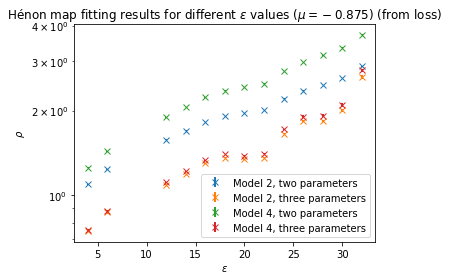

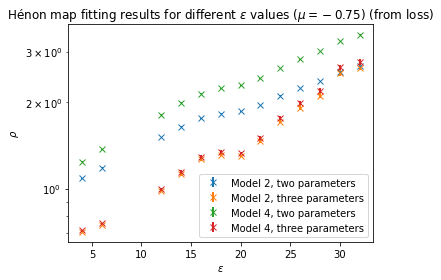

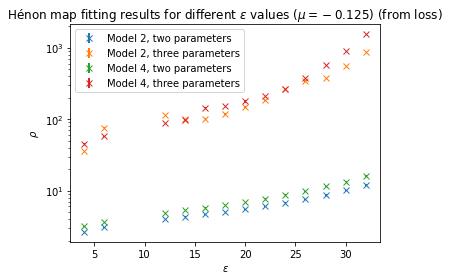

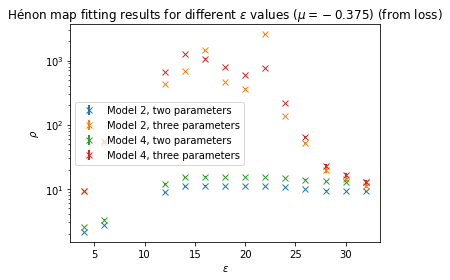

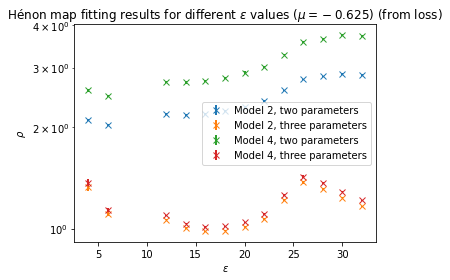

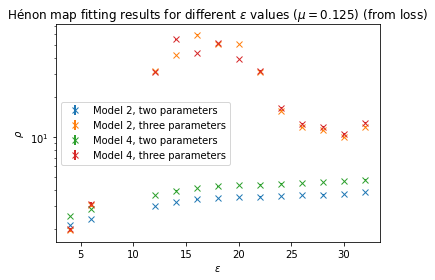

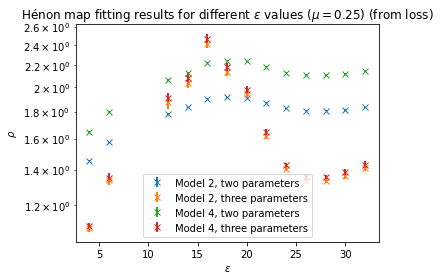

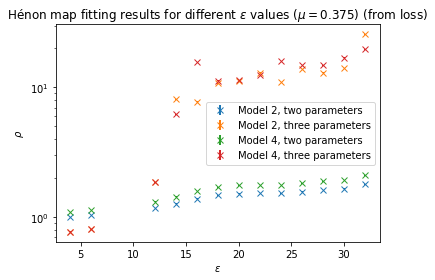

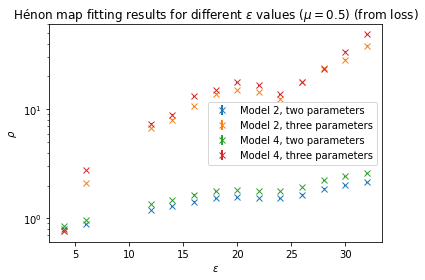

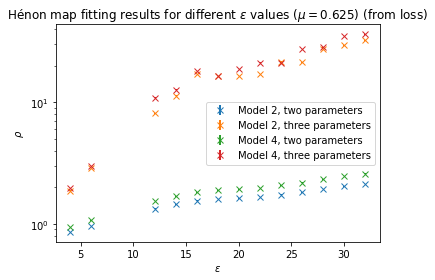

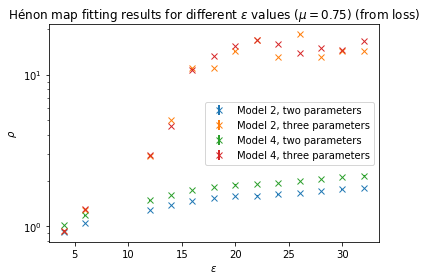

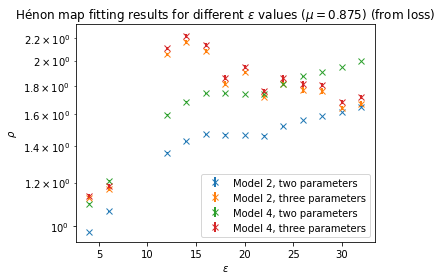

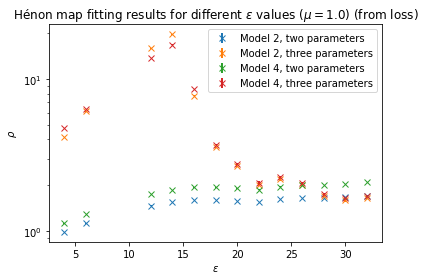

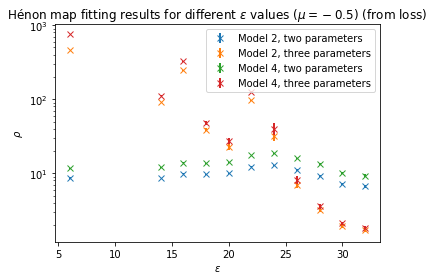

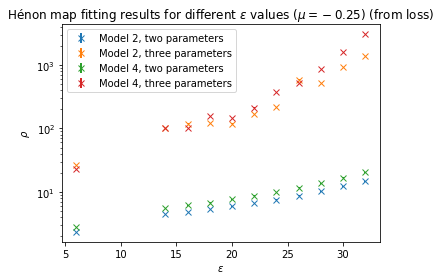

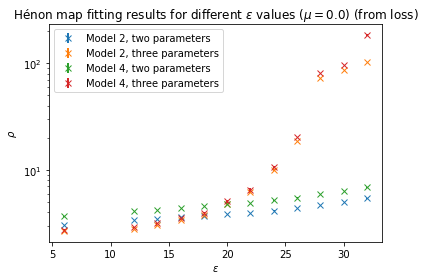

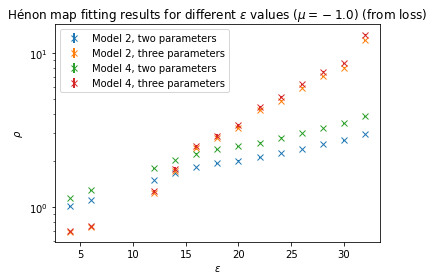

In [33]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], rho1_fix_from_loss[mus == mu], yerr=rho1_err_fix_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], rho1_from_loss[mus == mu], yerr=rho1_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], rho2_from_loss[mus == mu], yerr=rho2_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], rho3_from_loss[mus == mu], yerr=rho3_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$ (from loss)".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_mu_{}_from_loss.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], rho1_fix_from_loss[epsilons == epsilon], yerr=rho1_err_fix_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho1_from_loss[epsilons == epsilon], yerr=rho1_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], rho2_from_loss[epsilons == epsilon], yerr=rho2_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho3_from_loss[epsilons == epsilon], yerr=rho3_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$ (from loss)".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_eps_{}_from_loss.png".format(epsilon), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], k1_fix_from_loss[mus == mu], yerr=k1_err_fix_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], k1_from_loss[mus == mu], yerr=k1_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], k2_from_loss[mus == mu], yerr=k2_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], k3_from_loss[mus == mu], yerr=k3_err_from_loss[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Hénon map fitting results for different $\\epsilon$ values $(\\mu={})$ (from loss)".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_mu_{}_from_loss.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], k1_fix_from_loss[epsilons == epsilon], yerr=k1_err_fix_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k1_from_loss[epsilons == epsilon], yerr=k1_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], k2_from_loss[epsilons == epsilon], yerr=k2_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k3_from_loss[epsilons == epsilon], yerr=k3_err_from_loss[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$k$")
    plt.title("Hénon map fitting results for different $\\mu$ values $(\\varepsilon={})$ (from loss)".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_eps_{}_from_loss.png".format(epsilon), dpi=600)

In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], DA_from_loss[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2_from_loss[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0_from_loss[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_from_loss[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free_from_loss[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
    
    plt.xscale("log")
    
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$ (from loss)".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_log_eps_{}_mu_{}_from_loss.png".format(epsilons[i], mus[i]), dpi=600)


In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], DA_from_loss[i], label="DA")
    plt.plot(turn_sampling[::-1], real_finals_model_2_from_loss[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0_from_loss[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_from_loss[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free_from_loss[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
        
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$ (from loss)".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_eps_{}_mu_{}_from_loss.png".format(epsilons[i], mus[i]), dpi=600)


## General fitting of all the Hénon maps across all models (WITH ERROR ON DATA)

In [ ]:
real_results_model_2_with_err = []
real_finals_model_2_with_err = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit_err, args=(fit.fit_model_2, turn_sampling[::-1], real_DAs[i][::-1], real_DAs_err[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_with_err = [T[2] for T in TMP]
real_finals_model_2_with_err = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_with_err.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_with_err,
        real_finals_model_2_with_err,
    ), f)

In [34]:
with open("../data/octo_henon_fit_2_with_err.pkl", 'rb') as f:
    real_results_model_2_with_err, real_finals_model_2_with_err = pickle.load(f)

In [35]:
k1_with_err = []
k1_err_with_err = []
n0_1_with_err = []
n0_1_err_with_err = [] 
rho1_with_err = []
rho1_err_with_err = []

chi_1_with_err = []
rchi_1_with_err = []

for i, eps in enumerate(epsilons):
    k1_with_err.append(real_results_model_2_with_err[i].params.get("k").value)
    k1_err_with_err.append(real_results_model_2_with_err[i].params.get("k").stderr)
    n0_1_with_err.append(real_results_model_2_with_err[i].params.get("n0").value)
    n0_1_err_with_err.append(real_results_model_2_with_err[i].params.get("n0").stderr)
    rho1_with_err.append(real_results_model_2_with_err[i].params.get("rho").value)
    rho1_err_with_err.append(real_results_model_2_with_err[i].params.get("rho").stderr)
    chi_1_with_err.append(real_results_model_2_with_err[i].chisqr)
    rchi_1_with_err.append(real_results_model_2_with_err[i].redchi)

k1_with_err = np.asarray(k1_with_err)
k1_err_with_err = np.asarray(k1_err_with_err)
rho1_with_err = np.asarray(rho1_with_err)
rho1_err_with_err = np.asarray(rho1_err_with_err)
n0_1_with_err = np.asarray(n0_1_with_err)
n0_1_err_with_err = np.asarray(n0_1_err_with_err)
chi_1_with_err = np.asarray(chi_1_with_err)
rchi_1_with_err = np.asarray(rchi_1_with_err)

In [36]:
real_results_model_2_fixed_n0_with_err = []
real_finals_model_2_fixed_n0_with_err = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit_err, args=(fit_model_2_fixed_n0, turn_sampling[::-1], real_DAs[i][::-1], real_DAs_err[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_2_fixed_n0_with_err = [T[2] for T in TMP]
real_finals_model_2_fixed_n0_with_err = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_fix_with_err.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_fixed_n0_with_err,
        real_finals_model_2_fixed_n0_with_err,
    ), f)

In [37]:
with open("../data/octo_henon_fit_2_fix_with_err.pkl", 'rb') as f:
    real_results_model_2_fixed_n0_with_err, real_finals_model_2_fixed_n0_with_err = pickle.load(f)

In [38]:
k1_fix_with_err = []
k1_err_fix_with_err = []
rho1_fix_with_err = []
rho1_err_fix_with_err = []

chi_1_fix_with_err = []
rchi_1_fix_with_err = []

for i, eps in enumerate(epsilons):
    k1_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].params.get("k").value)
    k1_err_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].params.get("k").stderr)
    rho1_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].params.get("rho").value)
    rho1_err_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].params.get("rho").stderr)
    chi_1_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].chisqr)
    rchi_1_fix_with_err.append(real_results_model_2_fixed_n0_with_err[i].redchi)

k1_fix_with_err = np.asarray(k1_fix_with_err)
k1_err_fix_with_err = np.asarray(k1_err_fix_with_err)
rho1_fix_with_err = np.asarray(rho1_fix_with_err)
rho1_err_fix_with_err = np.asarray(rho1_err_fix_with_err)
chi_1_fix_with_err = np.asarray(chi_1_fix_with_err)
rchi_1_fix_with_err = np.asarray(rchi_1_fix_with_err)

In [ ]:
real_results_model_4_with_err = []
real_finals_model_4_with_err = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit_err, args=(fit.fit_model_4, turn_sampling[::-1], real_DAs[i][::-1], real_DAs_err[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_with_err = [T[2] for T in TMP]
real_finals_model_4_with_err = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_with_err.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_with_err,
        real_finals_model_4_with_err,
    ), f)

In [39]:
with open("../data/octo_henon_fit_4_with_err.pkl", 'rb') as f:
    real_results_model_4_with_err, real_finals_model_4_with_err = pickle.load(f)

In [40]:
k2_with_err = []
k2_err_with_err = []
rho2_with_err = []
rho2_err_with_err = []

chi_2_with_err = []
rchi_2_with_err = []

for i, eps in enumerate(epsilons):
    k2_with_err.append(real_results_model_4_with_err[i].params.get("k").value)
    k2_err_with_err.append(real_results_model_4_with_err[i].params.get("k").stderr)
    rho2_with_err.append(real_results_model_4_with_err[i].params.get("rho").value)
    rho2_err_with_err.append(real_results_model_4_with_err[i].params.get("rho").stderr)
    chi_2_with_err.append(real_results_model_4_with_err[i].chisqr)
    rchi_2_with_err.append(real_results_model_4_with_err[i].redchi)

k2_with_err = np.asarray(k2_with_err)
k2_err_with_err = np.asarray(k2_err_with_err)
rho2_with_err = np.asarray(rho2_with_err)
rho2_err_with_err = np.asarray(rho2_err_with_err)
chi_2_with_err = np.asarray(chi_2_with_err)
rchi_2_with_err = np.asarray(rchi_2_with_err)

In [ ]:
real_results_model_4_free_with_err = []
real_finals_model_4_free_with_err = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit_err, args=(fit.fit_model_4_free, turn_sampling[::-1], real_DAs[i][::-1], real_DAs[i][::-1], epsilons[i], mus[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

real_results_model_4_free_with_err = [T[2] for T in TMP]
real_finals_model_4_free_with_err = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_free_with_err.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_free_with_err,
        real_finals_model_4_free_with_err,
    ), f)

In [41]:
with open("../data/octo_henon_fit_4_free_with_err.pkl", 'rb') as f:
    real_results_model_4_free_with_err, real_finals_model_4_free_with_err = pickle.load(f)

In [42]:
k3_with_err = []
k3_err_with_err = []
rho3_with_err = []
rho3_err_with_err = []
n0_3_with_err = []
n0_3_err_with_err = []

chi_3_with_err = []
rchi_3_with_err = []

for i, eps in enumerate(epsilons):
    k3_with_err.append(real_results_model_4_free_with_err[i].params.get("k").value)
    k3_err_with_err.append(real_results_model_4_free_with_err[i].params.get("k").stderr)
    rho3_with_err.append(real_results_model_4_free_with_err[i].params.get("rho").value)
    rho3_err_with_err.append(real_results_model_4_free_with_err[i].params.get("rho").stderr)
    n0_3_with_err.append(real_results_model_4_free_with_err[i].params.get("n0").value)
    n0_3_err_with_err.append(real_results_model_4_free_with_err[i].params.get("n0").stderr)
    chi_3_with_err.append(real_results_model_4_free_with_err[i].chisqr)
    rchi_3_with_err.append(real_results_model_4_free_with_err[i].redchi)

k3_with_err = np.asarray(k3_with_err)
k3_err_with_err = np.asarray(k3_err_with_err)
rho3_with_err = np.asarray(rho3_with_err)
rho3_err_with_err = np.asarray(rho3_err_with_err)
n0_3_with_err = np.asarray(n0_3_with_err)
n0_3_err_with_err = np.asarray(n0_3_err_with_err)
chi_3_with_err = np.asarray(chi_3_with_err)
rchi_3_with_err = np.asarray(rchi_3_with_err)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], rho1_fix_with_err[mus == mu], yerr=rho1_err_fix_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], rho1_with_err[mus == mu], yerr=rho1_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], rho2_with_err[mus == mu], yerr=rho2_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], rho3_with_err[mus == mu], yerr=rho3_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results (with errors) for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_mu_{}_with_err.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], rho1_fix_with_err[epsilons == epsilon], yerr=rho1_err_fix_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho1_with_err[epsilons == epsilon], yerr=rho1_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], rho2_with_err[epsilons == epsilon], yerr=rho2_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], rho3_with_err[epsilons == epsilon], yerr=rho3_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.yscale("log")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\rho$")
    plt.title("Hénon map fitting results (with errors) for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_rho_values_henon_err_eps_{}_with_err.png".format(epsilon), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.errorbar(epsilons[mus == mu], k1_fix_with_err[mus == mu], yerr=k1_err_fix_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(epsilons[mus == mu], k1_with_err[mus == mu], yerr=k1_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(epsilons[mus == mu], k2_with_err[mus == mu], yerr=k2_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(epsilons[mus == mu], k3_with_err[mus == mu], yerr=k3_err_with_err[mus == mu], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Hénon map fitting results (with error) for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_mu_{}_with_err.png".format(mu), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):
    plt.figure()
    plt.errorbar(mus[epsilons == epsilon], k1_fix_with_err[epsilons == epsilon], yerr=k1_err_fix_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k1_with_err[epsilons == epsilon], yerr=k1_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 2, three parameters")
    plt.errorbar(mus[epsilons == epsilon], k2_with_err[epsilons == epsilon], yerr=k2_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, two parameters")
    plt.errorbar(mus[epsilons == epsilon], k3_with_err[epsilons == epsilon], yerr=k3_err_with_err[epsilons == epsilon], linewidth=0, elinewidth=2, marker="x", label="Model 4, three parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$k$")
    plt.title("Hénon map fitting results (with error) for different $\\mu$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()
    plt.savefig("../img/octo_k_values_henon_err_eps_{}_with_err.png".format(epsilon), dpi=600)

In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.fill_between(turn_sampling[::], real_DAs[i] - real_DAs_err[i], real_DAs[i] + real_DAs_err[i], color="C0", alpha=0.3)
    
    plt.plot(turn_sampling[::-1], real_finals_model_2_with_err[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0_with_err[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_with_err[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free_with_err[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
    
    plt.xscale("log")
    
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_log_eps_{}_mu_{}_with_err.png".format(epsilons[i], mus[i]), dpi=600)


In [ ]:
for i in tqdm(range(len(epsilons))):
    plt.figure()
    plt.plot(turn_sampling[::], real_DAs[i], label="DA")
    plt.fill_between(turn_sampling[::], real_DAs[i] - real_DAs_err[i], real_DAs[i] + real_DAs_err[i], color="C0", alpha=0.3)
    
    plt.plot(turn_sampling[::-1], real_finals_model_2_with_err[i], label="model 2, 3 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_2_fixed_n0_with_err[i], label="model 2, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_with_err[i], label="model 4, 2 pars")
    plt.plot(turn_sampling[::-1], real_finals_model_4_free_with_err[i], label="model 4, 3 pars")
    
    plt.xlabel("$N$ turns")
    plt.ylabel("$DA$")
        
    plt.legend(fontsize="x-small")
    plt.title("$\\varepsilon={}, \\mu={}$".format(epsilons[i], mus[i]))
    plt.savefig("../img/octo_henon_da_fit_eps_{}_mu_{}_with_err.png".format(epsilons[i], mus[i]), dpi=600)


### New fitting models

In [ ]:
def model_2_bis(params, x, data):
    b_tilde = params["b_tilde"]
    B = params["B"]
    N_0 = params["N_0"]
    k = params["k"]
    temp = np.power(B * np.log(x / N_0), k)
    temp[np.isnan(temp)] = 0.0
    model = b_tilde / temp
    if np.any(np.isnan(model)):
        print(b_tilde, B, N_0, k)
    return model - data

def model_4_bis(params, x, data):
    b_tilde = params["b_tilde"]
    B = params["B"]
    N_0 = params["N_0"]
    k = params["k"]
    lambert = lambertw(
        -(2 / (k * B)) * np.power(x / N_0, - 2 / k), -1
    )
    lambert[np.isnan(lambert)] = -np.inf
    model = b_tilde / np.power(- (k * B / 2) * np.real(lambert), k)
    
    if np.any(np.isnan(model)):
        print(b_tilde, B, N_0, k)
        try:
            print(params["delta"])
        except:
            pass
    #print(model)
    return model - data

In [ ]:
def fit_model_2_bis(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("B", value=1, min=0, vary=True)
    params.add("N_0", expr="7 * sqrt(6) / 48 * (b_tilde ** (1/2))")
    params.add("k", value=1, min=0, vary=True)
    minner = Minimizer(model_2_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_2_bis_free(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("B", value=1, min=0, vary=True)
    params.add("N_0", value=1, min=0, max=turns.min() * 1.0, vary=True)
    params.add("k", value=1, min=0, vary=True)
    minner = Minimizer(model_2_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_4_bis(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("delta", value=0.2, min=0.0, max=1/np.e, vary=True)
    params.add("N_0", expr="7 * sqrt(6) / 48 * (b_tilde ** (1/2))")
    params.add("k", value=0.5, min=0.1, max=3, vary=True)
    params.add("B", expr="(2/(k*delta)) * (1000 / N_0) ** (-2/k)")
    minner = Minimizer(model_4_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

def fit_model_4_bis_free(turns, DA):
    params = Parameters()
    params.add("b_tilde", value=1, min=0, vary=True)
    params.add("delta", value=0.2, min=0.0, max=1/np.e, vary=True)
    params.add("N_0", value=1, min=0, max=turns.min() * 1.0, vary=True)
    params.add("k", value=0.5, min=0.1, max=3, vary=True)
    params.add("B", expr="(2/(k*delta)) * (1000 / N_0) ** (-2/k)")
    minner = Minimizer(model_4_bis, params, fcn_args=(turns, DA))
    result = minner.minimize(method="basinhopping")
    final = DA + result.residual
    return result, final

In [ ]:
real_results_model_2_bis = []
real_finals_model_2_bis = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_bis, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_2_bis = [T[1] for T in TMP]
real_finals_model_2_bis = [T[2] for T in TMP]

In [ ]:
for i, eps in tqdm(list(enumerate(epsilons))):
    turns = turn_sampling[::-1]
    real_DA = real_DAs[i][::-1]
    
    result, final = fit_model_2_bis(turns, real_DA)
    real_results_model_2_bis.append(result)
    real_finals_model_2_bis.append(final)

In [ ]:
with open("../data/octo_henon_fit_2_new.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_bis,
        real_finals_model_2_bis
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2_new.pkl", 'rb') as f:
    real_results_model_2_bis, real_finals_model_2_bis = pickle.load(f)

In [ ]:
k4 = []
k4_err = []
b_tilde4 = []
b_tilde4_err = []
B4 = []
B4_err = []
N_0_4 = []
N_0_4_err = []

chi_4 = []
rchi_4 = []

for i, eps in enumerate(epsilons):
    k4.append(real_results_model_2_bis[i].params.get("k").value)
    k4_err.append(real_results_model_2_bis[i].params.get("k").stderr)
    b_tilde4.append(real_results_model_2_bis[i].params.get("b_tilde").value)
    b_tilde4_err.append(real_results_model_2_bis[i].params.get("b_tilde").stderr)
    B4.append(real_results_model_2_bis[i].params.get("B").value)
    B4_err.append(real_results_model_2_bis[i].params.get("B").stderr)
    N_0_4.append(real_results_model_2_bis[i].params.get("N_0").value)
    N_0_4_err.append(real_results_model_2_bis[i].params.get("N_0").stderr)
    chi_4.append(real_results_model_2_bis[i].chisqr)
    rchi_4.append(real_results_model_2_bis[i].redchi)
    

In [ ]:
real_results_model_4_bis = []
real_finals_model_4_bis = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_4_bis, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_4_bis = [T[1] for T in TMP]
real_finals_model_4_bis = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_new.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_bis,
        real_finals_model_4_bis
    ), f)

In [ ]:
with open("../data/octo_henon_fit_4_new.pkl", 'rb') as f:
    real_results_model_4_bis, real_finals_model_4_bis = pickle.load(f)

In [ ]:
k5 = []
k5_err = []
b_tilde5 = []
b_tilde5_err = []
B5 = []
B5_err = []
N_0_5 = []
N_0_5_err = []

chi_5 = []
rchi_5 = []

for i, eps in enumerate(epsilons):
    k5.append(real_results_model_4_bis[i].params.get("k").value)
    k5_err.append(real_results_model_4_bis[i].params.get("k").stderr)
    b_tilde5.append(real_results_model_4_bis[i].params.get("b_tilde").value)
    b_tilde5_err.append(real_results_model_4_bis[i].params.get("b_tilde").stderr)
    B5.append(real_results_model_4_bis[i].params.get("B").value)
    B5_err.append(real_results_model_4_bis[i].params.get("B").stderr)
    N_0_5.append(real_results_model_4_bis[i].params.get("N_0").value)
    N_0_5_err.append(real_results_model_4_bis[i].params.get("N_0").stderr)
    chi_5.append(real_results_model_4_bis[i].chisqr)
    rchi_5.append(real_results_model_4_bis[i].redchi)
    

In [ ]:
real_results_model_2_bis_free = []
real_finals_model_2_bis_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_2_bis_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_final), key=lambda x: x[0])

real_results_model_2_bis_free = [T[1] for T in TMP]
real_finals_model_2_bis_free = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_2_new_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_2_bis_free,
        real_finals_model_2_bis_free
    ), f)

In [ ]:
with open("../data/octo_henon_fit_2_new_free.pkl", 'rb') as f:
    real_results_model_2_bis_free, real_finals_model_2_bis_free = pickle.load(f)

In [ ]:
k6 = []
k6_err = []
b_tilde6 = []
b_tilde6_err = []
B6 = []
B6_err = []
N_0_6 = []
N_0_6_err = []

chi_6 = []
rchi_6 = []

for i, eps in enumerate(epsilons):
    k6.append(real_results_model_2_bis_free[i].params.get("k").value)
    k6_err.append(real_results_model_2_bis_free[i].params.get("k").stderr)
    b_tilde6.append(real_results_model_2_bis_free[i].params.get("b_tilde").value)
    b_tilde6_err.append(real_results_model_2_bis_free[i].params.get("b_tilde").stderr)
    B6.append(real_results_model_2_bis_free[i].params.get("B").value)
    B6_err.append(real_results_model_2_bis_free[i].params.get("B").stderr)
    N_0_6.append(real_results_model_2_bis_free[i].params.get("N_0").value)
    N_0_6_err.append(real_results_model_2_bis_free[i].params.get("N_0").stderr)
    chi_6.append(real_results_model_2_bis_free[i].chisqr)
    rchi_6.append(real_results_model_2_bis_free[i].redchi)
    

In [ ]:
real_results_model_4_bis_free = []
real_finals_model_4_bis_free = []

In [ ]:
temp_result = []
temp_final = []
temp_eps = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(wrap_fit, args=(fit_model_4_bis_free, turn_sampling[::-1], real_DAs[i][::-1], epsilons[i]), callback=log_result) for i in range(len(real_DAs))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_result, temp_eps), key=lambda x: x[0])

real_results_model_4_bis_free = [T[1] for T in TMP]
real_finals_model_4_bis_free = [T[2] for T in TMP]

In [ ]:
with open("../data/octo_henon_fit_4_new_free.pkl", 'wb') as f:
    pickle.dump((
        real_results_model_4_bis_free,
        real_finals_model_4_bis_free
    ), f)

In [ ]:
with open("../data/octo_henonocto_henon_fit_4_new_free.pkl", 'rb') as f:
    real_results_model_4_bis_free, real_finals_model_4_bis_free = pickle.load(f)

In [ ]:
k7 = []
k7_err = []
b_tilde7 = []
b_tilde7_err = []
B7 = []
B7_err = []
N_0_7 = []
N_0_7_err = []

chi_7 = []
rchi_7 = []

for i, eps in enumerate(epsilons):
    k7.append(real_results_model_4_bis_free[i].params.get("k").value)
    k7_err.append(real_results_model_4_bis_free[i].params.get("k").stderr)
    b_tilde7.append(real_results_model_4_bis_free[i].params.get("b_tilde").value)
    b_tilde7_err.append(real_results_model_4_bis_free[i].params.get("b_tilde").stderr)
    B7.append(real_results_model_4_bis_free[i].params.get("B").value)
    B7_err.append(real_results_model_4_bis_free[i].params.get("B").stderr)
    N_0_7.append(real_results_model_4_bis_free[i].params.get("N_0").value)
    N_0_7_err.append(real_results_model_4_bis_free[i].params.get("N_0").stderr)
    chi_7.append(real_results_model_4_bis_free[i].chisqr)
    rchi_7.append(real_results_model_4_bis_free[i].redchi)
    

In [ ]:
plt.figure()

plt.scatter(epsilons, chi_1_fix, marker="x", label="Model 2, two parameters")
plt.scatter(epsilons, chi_1, marker="x", label="Model 2, three parameters")
plt.scatter(epsilons, chi_2, marker="x", label="Model 4, two parameters")
plt.scatter(epsilons, chi_3, marker="x", label="Model 4, three parameters")
plt.scatter(epsilons, chi_4, marker="x", label="Model 2 new, n0 fixed")
#plt.scatter(epsilons, chi_5, marker="x", label="Model 4 new, n0 fixed")
plt.scatter(epsilons, chi_6, marker="x", label="Model 2 new, n0 free")
plt.scatter(epsilons, chi_7, marker="x", label="Model 4 new, n0 free")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\chi^2$")
plt.title("$\\chi^2$ of various fitting models for different $\\varepsilon$")
plt.tight_layout()

In [ ]:
plt.figure()

plt.scatter(epsilons, rchi_1_fix, marker="x", label="Model 2, two parameters")
plt.scatter(epsilons, rchi_1, marker="x", label="Model 2, three parameters")
plt.scatter(epsilons, rchi_2, marker="x", label="Model 4, two parameters")
plt.scatter(epsilons, rchi_3, marker="x", label="Model 4, three parameters")
plt.scatter(epsilons, rchi_4, marker="x", label="Model 2 new, n0 fixed")
#plt.scatter(epsilons, rchi_5, marker="x", label="Model 4 new, n0 fixed")
plt.scatter(epsilons, rchi_6, marker="x", label="Model 2 new, n0 free")
plt.scatter(epsilons, rchi_7, marker="x", label="Model 4 new, n0 free")

plt.legend(fontsize="small")
plt.xlabel("$\\varepsilon$")
plt.ylabel("Reduced $\\chi^2$")
plt.title("Reduced $\\chi^2$ of various fitting models for different $\\varepsilon$")
plt.tight_layout()

## BIG PHAT PLOTS

In [ ]:
for mu in tqdm(mu_set):
    plt.figure()
    b_mask = (mus == mu)
    
    plt.errorbar(epsilons[b_mask], k1_fix[b_mask], yerr=k1_err_fix[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, two parameters, original DA")    
    plt.errorbar(epsilons[b_mask], k1_fix_from_loss[b_mask], yerr=k1_err_fix_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, two parameters, DA from loss")
    
    plt.errorbar(epsilons[b_mask], k2[b_mask], yerr=k2_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, two parameters, original DA")
    plt.errorbar(epsilons[b_mask], k2_from_loss[b_mask], yerr=k2_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, two parameters, DA from loss")
    
    plt.legend(fontsize="small")
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison in $\\kappa$ values between different DA kinds $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_different_da_comparison_k_2_pars_mu_{}.png".format(mu), dpi=600)
    #plt.close()

In [ ]:
for mu in tqdm(mu_set):
    plt.figure()
    b_mask = (mus == mu)
    
    plt.errorbar(epsilons[b_mask], k1[b_mask], yerr=k1_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, three parameters, original DA")
    plt.errorbar(epsilons[b_mask], k1_from_loss[b_mask], yerr=k1_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, three parameters, DA from loss")
    
    plt.errorbar(epsilons[b_mask], k3[b_mask], yerr=k3_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, three parameters, original DA")
    plt.errorbar(epsilons[b_mask], k3_from_loss[b_mask], yerr=k3_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, three parameters, DA from loss")
    
    plt.legend(fontsize="small")
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison in $\\kappa$ values between different DA kinds $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_different_da_comparison_k_3_pars_mu_{}.png".format(mu), dpi=600)
    #plt.close()

In [ ]:
for mu in tqdm(mu_set):
    plt.figure()
    b_mask = (mus == mu)
    
    plt.errorbar(epsilons[b_mask], rho1_fix[b_mask], yerr=rho1_err_fix[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, two parameters, original DA")    
    plt.errorbar(epsilons[b_mask], rho1_fix_from_loss[b_mask], yerr=rho1_err_fix_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, two parameters, DA from loss")
    
    plt.errorbar(epsilons[b_mask], rho2[b_mask], yerr=rho2_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, two parameters, original DA")
    plt.errorbar(epsilons[b_mask], rho2_from_loss[b_mask], yerr=rho2_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, two parameters, DA from loss")
    
    plt.legend(fontsize="small")
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.title("Comparison in $\\rho$ values between different DA kinds $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_different_da_comparison_rho_2_pars_mu_{}.png".format(mu), dpi=600)
    #plt.close()

In [ ]:
for mu in tqdm(mu_set):
    plt.figure()
    b_mask = (mus == mu)
    
    plt.errorbar(epsilons[b_mask], rho1[b_mask], yerr=rho1_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, three parameters, original DA")
    plt.errorbar(epsilons[b_mask], rho1_from_loss[b_mask], yerr=rho1_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 2, three parameters, DA from loss")
    
    plt.errorbar(epsilons[b_mask], rho3[b_mask], yerr=rho3_err[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, three parameters, original DA")
    plt.errorbar(epsilons[b_mask], rho3_from_loss[b_mask], yerr=rho3_err_from_loss[b_mask], marker="x", linewidth=0, elinewidth=2, label="Model 3, three parameters, DA from loss")
    
    plt.legend(fontsize="small")
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\rho$")
    plt.yscale("log")
    plt.title("Comparison in $\\kappa$ values between different DA kinds $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_different_da_comparison_rho_3_pars_mu_{}.png".format(mu), dpi=600)
    #plt.close()

## Fokker-Planck stuff

In [38]:
I_max = (cut_point+0.1)**2 / 2
I = np.linspace(0, I_max, 1000)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

### All

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            turn_sampling[::-1],
            gaussian_losses[i][::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_standard = [T[2] for T in TMP]
finals_standard = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit.pkl", 'wb') as f:
    pickle.dump((results_standard, finals_standard), f)

In [34]:
with open("../data/octo_fp_henon_fit.pkl", 'rb') as f:
    results_standard, finals_standard = pickle.load(f)

In [67]:
eps_fp = []
k_fp = []
k_err_fp = []
I_star_fp = []
I_star_err_fp = []

chi_fp = []
rchi_fp = []

for i, result in enumerate(results_standard):
    k_fp.append(result.params.get("k").value)
    k_err_fp.append(result.params.get("k").stderr)
    I_star_fp.append(result.params.get("I_star").value)
    I_star_err_fp.append(result.params.get("I_star").stderr)
    eps_fp.append(epsilons[i])
    chi_fp.append(result.chisqr)
    rchi_fp.append(result.redchi)

In [68]:
eps_fp = np.asarray(eps_fp)
k_fp = np.asarray(k_fp)
k_err_fp = np.asarray(k_err_fp)
I_star_fp = np.asarray(I_star_fp)
I_star_err_fp = np.asarray(I_star_err_fp)

chi_fp = np.asarray(chi_fp)
rchi_fp = np.asarray(rchi_fp)

### No begin

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[turn_sampling > 10000])[::-1],
            (gaussian_losses[i][turn_sampling > 10000])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_beg = [T[2] for T in TMP]
finals_no_beg = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_beg.pkl", 'wb') as f:
    pickle.dump((results_no_beg, finals_no_beg), f)

In [35]:
with open("../data/octo_fp_henon_fit_no_beg.pkl", 'rb') as f:
    results_no_beg, finals_no_beg = pickle.load(f)

### No end

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end = [T[2] for T in TMP]
finals_no_end = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end.pkl", 'wb') as f:
    pickle.dump((results_no_end, finals_no_end), f)

In [39]:
with open("../data/octo_fp_henon_fit_no_end.pkl", 'rb') as f:
    results_no_end, finals_no_end = pickle.load(f)

In [40]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end[i].params,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            2,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end = [T[2] for T in TMP]

/home/STUDENTI/carlo.montanari3/python_packages/crank_nicolson_numba/crank_nicolson_numba/nekhoroshev.py:300: RuntimeWarning: overflow encountered in power
  * np.exp(- 2 * np.power(self.I_star / x[mask], self.alpha))


In [41]:
eps_fp_no_end = []
k_fp_no_end = []
k_err_fp_no_end = []
I_star_fp_no_end = []
I_star_err_fp_no_end = []

chi_fp_no_end = []
rchi_fp_no_end = []

chi_fp_no_end_reconstructed = []

for i, result in enumerate(results_no_end):
    k_fp_no_end.append(result.params.get("k").value)
    k_err_fp_no_end.append(result.params.get("k").stderr)
    I_star_fp_no_end.append(result.params.get("I_star").value)
    I_star_err_fp_no_end.append(result.params.get("I_star").stderr)
    eps_fp_no_end.append(epsilons[i])
    chi_fp_no_end.append(result.chisqr)
    rchi_fp_no_end.append(result.redchi)
    chi_fp_no_end_reconstructed.append(chi2(finals_interpolated_no_end[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[len(turn_sampling)//2:])[::-1], finals_no_end[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_easy_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end medium...

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_medium = [T[2] for T in TMP]
finals_no_end_medium = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium.pkl", 'wb') as f:
    pickle.dump((results_no_end_medium, finals_no_end_medium), f)

In [42]:
with open("../data/octo_fp_henon_fit_no_end_medium.pkl", 'rb') as f:
    results_no_end_medium, finals_no_end_medium = pickle.load(f)

In [43]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_medium[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            5,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_medium = [T[2] for T in TMP]

/home/STUDENTI/carlo.montanari3/python_packages/crank_nicolson_numba/crank_nicolson_numba/nekhoroshev.py:300: RuntimeWarning: overflow encountered in power
  * np.exp(- 2 * np.power(self.I_star / x[mask], self.alpha))


In [44]:
eps_fp_no_end_medium = []
k_fp_no_end_medium = []
k_err_fp_no_end_medium = []
I_star_fp_no_end_medium = []
I_star_err_fp_no_end_medium = []

chi_fp_no_end_medium = []
rchi_fp_no_end_medium = []

chi_fp_no_end_medium_reconstructed = []

for i, result in enumerate(results_no_end_medium):
    k_fp_no_end_medium.append(result.params.get("k").value)
    k_err_fp_no_end_medium.append(result.params.get("k").stderr)
    I_star_fp_no_end_medium.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_medium.append(result.params.get("I_star").stderr)
    eps_fp_no_end_medium.append(epsilons[i])
    chi_fp_no_end_medium.append(result.chisqr)
    rchi_fp_no_end_medium.append(result.redchi)
    chi_fp_no_end_medium_reconstructed.append(chi2(finals_interpolated_no_end_medium[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_medium[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 8:])[::-1], finals_no_end_medium[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_medium_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end extreme!

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_extreme = [T[2] for T in TMP]
finals_no_end_extreme = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme.pkl", 'wb') as f:
    pickle.dump((results_no_end_extreme, finals_no_end_extreme), f)

In [45]:
with open("../data/octo_fp_henon_fit_no_end_extreme.pkl", 'rb') as f:
    results_no_end_extreme, finals_no_end_extreme = pickle.load(f)

In [46]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_extreme[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            10,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_extreme = [T[2] for T in TMP]

/home/STUDENTI/carlo.montanari3/python_packages/crank_nicolson_numba/crank_nicolson_numba/nekhoroshev.py:300: RuntimeWarning: overflow encountered in power
  * np.exp(- 2 * np.power(self.I_star / x[mask], self.alpha))


In [47]:
eps_fp_no_end_extreme = []
k_fp_no_end_extreme = []
k_err_fp_no_end_extreme = []
I_star_fp_no_end_extreme = []
I_star_err_fp_no_end_extreme = []

chi_fp_no_end_extreme = []
rchi_fp_no_end_extreme = []

chi_fp_no_end_extreme_reconstructed = []

for i, result in enumerate(results_no_end_extreme):
    k_fp_no_end_extreme.append(result.params.get("k").value)
    k_err_fp_no_end_extreme.append(result.params.get("k").stderr)
    I_star_fp_no_end_extreme.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_extreme.append(result.params.get("I_star").stderr)
    eps_fp_no_end_extreme.append(epsilons[i])
    chi_fp_no_end_extreme.append(result.chisqr)
    rchi_fp_no_end_extreme.append(result.redchi)
    chi_fp_no_end_extreme_reconstructed.append(chi2(finals_interpolated_no_end_extreme[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_extreme[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 9:])[::-1], finals_no_end_extreme[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_extreme_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

## Fokker-Planck But POLYNOMIAL!

In [ ]:
I_max = (cut_point+0.1)**2 / 2
I = np.linspace(0, I_max, 1000)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

### All

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly,
            turn_sampling[::-1],
            gaussian_losses[i][::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_standard_poly = [T[2] for T in TMP]
finals_standard_poly = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_poly.pkl", 'wb') as f:
    pickle.dump((results_standard_poly, finals_standard_poly), f)

In [48]:
with open("../data/octo_fp_henon_fit_poly.pkl", 'rb') as f:
    results_standard_poly, finals_standard_poly = pickle.load(f)

In [49]:
eps_fp_standard_poly = []
exponent_fp_standard_poly = []
exponent_err_fp_standard_poly = []

chi_fp_standard_poly = []
rchi_fp_standard_poly = []

for i, result in enumerate(results_standard_poly):
    exponent_fp_standard_poly.append(result.params.get("exponent").value)
    exponent_err_fp_standard_poly.append(result.params.get("exponent").stderr)
    eps_fp_standard_poly.append(epsilons[i])
    chi_fp_standard_poly.append(result.chisqr)
    rchi_fp_standard_poly.append(result.redchi)

In [50]:
eps_fp_standard_poly = np.asarray(eps_fp_standard_poly)
exponent_fp_standard_poly = np.asarray(exponent_fp_standard_poly)
exponent_err_fp_standard_poly = np.asarray(exponent_err_fp_standard_poly)

chi_fp_standard_poly = np.asarray(chi_fp_standard_poly)
rchi_fp_standard_poly = np.asarray(rchi_fp_standard_poly)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_standard_poly[index], label="FP fitting result", c="C1")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_fitting_standard_eps_{}_mu_{}_poly.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No begin

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly,
            (turn_sampling[turn_sampling > 10000])[::-1],
            (gaussian_losses[i][turn_sampling > 10000])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_beg_poly = [T[2] for T in TMP]
finals_no_beg_poly = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_beg_poly.pkl", 'wb') as f:
    pickle.dump((results_no_beg_poly, finals_no_beg_poly), f)

In [51]:
with open("../data/octo_fp_henon_fit_no_beg_poly.pkl", 'rb') as f:
    results_no_beg_poly, finals_no_beg_poly = pickle.load(f)

### No end

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_poly = [T[2] for T in TMP]
finals_no_end_poly = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_poly.pkl", 'wb') as f:
    pickle.dump((results_no_end_poly, finals_no_end_poly), f)

In [52]:
with open("../data/octo_fp_henon_fit_no_end_poly.pkl", 'rb') as f:
    results_no_end_poly, finals_no_end_poly = pickle.load(f)

In [53]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly,
        args=(
            results_no_end_poly[i].params,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            2,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_poly = [T[2] for T in TMP]

In [54]:
eps_fp_no_end_poly = []
exponent_fp_no_end_poly = []
exponent_err_fp_no_end_poly = []

chi_fp_no_end_poly = []
rchi_fp_no_end_poly = []

chi_fp_no_end_reconstructed_poly = []

for i, result in enumerate(results_no_end_poly):
    exponent_fp_no_end_poly.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_poly.append(result.params.get("exponent").stderr)
    eps_fp_no_end_poly.append(epsilons[i])
    chi_fp_no_end_poly.append(result.chisqr)
    rchi_fp_no_end_poly.append(result.redchi)
    chi_fp_no_end_reconstructed_poly.append(chi2(finals_interpolated_no_end_poly[i], gaussian_losses[i][::-1]))

In [55]:
eps_fp_no_end_poly = np.asarray(eps_fp_no_end_poly)
exponent_fp_no_end_poly = np.asarray(exponent_fp_no_end_poly)
exponent_err_fp_no_end_poly = np.asarray(exponent_err_fp_no_end_poly)

chi_fp_no_end_poly = np.asarray(chi_fp_no_end_poly)
rchi_fp_no_end_poly = np.asarray(rchi_fp_no_end_poly)

chi_fp_no_end_reconstructed_poly = np.asarray(chi_fp_no_end_reconstructed_poly)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_poly[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[len(turn_sampling)//2:])[::-1], finals_no_end_poly[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_easy_eps_{}_mu_{}_poly.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end medium...

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_medium_poly = [T[2] for T in TMP]
finals_no_end_medium_poly = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium_poly.pkl", 'wb') as f:
    pickle.dump((results_no_end_medium_poly, finals_no_end_medium_poly), f)

In [56]:
with open("../data/octo_fp_henon_fit_no_end_medium_poly.pkl", 'rb') as f:
    results_no_end_medium_poly, finals_no_end_medium_poly = pickle.load(f)

In [57]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly,
        args=(
            results_no_end_medium_poly[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            5,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_medium_poly = [T[2] for T in TMP]

In [58]:
eps_fp_no_end_medium_poly = []
exponent_fp_no_end_medium_poly = []
exponent_err_fp_no_end_medium_poly = []

chi_fp_no_end_medium_poly = []
rchi_fp_no_end_medium_poly = []

chi_fp_no_end_medium_reconstructed_poly = []

for i, result in enumerate(results_no_end_medium_poly):
    exponent_fp_no_end_medium_poly.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_medium_poly.append(result.params.get("exponent").stderr)
    eps_fp_no_end_medium_poly.append(epsilons[i])
    chi_fp_no_end_medium_poly.append(result.chisqr)
    rchi_fp_no_end_medium_poly.append(result.redchi)
    chi_fp_no_end_medium_reconstructed_poly.append(chi2(finals_interpolated_no_end_medium_poly[i], gaussian_losses[i][::-1]))

In [59]:
eps_fp_no_end_medium_poly = np.asarray(eps_fp_no_end_medium_poly)
exponent_fp_no_end_medium_poly = np.asarray(exponent_fp_no_end_medium_poly)
exponent_err_fp_no_end_medium_poly = np.asarray(exponent_err_fp_no_end_medium_poly)

chi_fp_no_end_medium_poly = np.asarray(chi_fp_no_end_medium_poly)
rchi_fp_no_end_medium_poly = np.asarray(rchi_fp_no_end_medium_poly)

chi_fp_no_end_medium_reconstructed_poly = np.asarray(chi_fp_no_end_medium_reconstructed_poly)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_medium_poly[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 8:])[::-1], finals_no_end_medium_poly[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_medium_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end extreme!

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_extreme_poly = [T[2] for T in TMP]
finals_no_end_extreme_poly = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme_poly.pkl", 'wb') as f:
    pickle.dump((results_no_end_extreme_poly, finals_no_end_extreme_poly), f)

In [60]:
with open("../data/octo_fp_henon_fit_no_end_extreme_poly.pkl", 'rb') as f:
    results_no_end_extreme_poly, finals_no_end_extreme_poly = pickle.load(f)

In [61]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly,
        args=(
            results_no_end_extreme_poly[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            10,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_extreme_poly = [T[2] for T in TMP]

In [62]:
eps_fp_no_end_extreme_poly = []
exponent_fp_no_end_extreme_poly = []
exponent_err_fp_no_end_extreme_poly = []

chi_fp_no_end_extreme_poly = []
rchi_fp_no_end_extreme_poly = []

chi_fp_no_end_extreme_reconstructed_poly = []

for i, result in enumerate(results_no_end_extreme_poly):
    exponent_fp_no_end_extreme_poly.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_extreme_poly.append(result.params.get("exponent").stderr)
    eps_fp_no_end_extreme_poly.append(epsilons[i])
    chi_fp_no_end_extreme_poly.append(result.chisqr)
    rchi_fp_no_end_extreme_poly.append(result.redchi)
    chi_fp_no_end_extreme_reconstructed_poly.append(chi2(finals_interpolated_no_end_extreme_poly[i], gaussian_losses[i][::-1]))

In [63]:
eps_fp_no_end_extreme_poly = np.asarray(eps_fp_no_end_extreme_poly)
exponent_fp_no_end_extreme_poly = np.asarray(exponent_fp_no_end_extreme_poly)
exponent_err_fp_no_end_extreme_poly = np.asarray(exponent_err_fp_no_end_extreme_poly)

chi_fp_no_end_extreme_poly = np.asarray(chi_fp_no_end_extreme_poly)
rchi_fp_no_end_extreme_poly = np.asarray(rchi_fp_no_end_extreme_poly)

chi_fp_no_end_extreme_reconstructed_poly = np.asarray(chi_fp_no_end_extreme_reconstructed_poly)

In [77]:
for index in tqdm(range(len(gaussian_losses))):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_extreme_poly[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 9:])[::-1], finals_no_end_extreme_poly[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_extreme_eps_{}_mu_{}_poly.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

## Fokker-Planck But POLYNOMIAL I_STAR!

In [72]:
I_max = (cut_point+0.1)**2 / 2
I = np.linspace(0, I_max, 1000)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

### All

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly_istar,
            turn_sampling[::-1],
            gaussian_losses[i][::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_standard_poly_istar = [T[2] for T in TMP]
finals_standard_poly_istar = [T[3] for T in TMP]

/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/STUDENTI/carlo.montanari3/anaconda3/lib/python3.8/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/home/STUDENTI/c

In [ ]:
with open("../data/octo_fp_henon_fit_poly_istar.pkl", 'wb') as f:
    pickle.dump((results_standard_poly_istar, finals_standard_poly_istar), f)

In [27]:
with open("../data/octo_fp_henon_fit_poly_istar.pkl", 'rb') as f:
    results_standard_poly_istar, finals_standard_poly_istar = pickle.load(f)

In [ ]:
eps_fp_standard_poly_istar = []
exponent_fp_standard_poly_istar = []
exponent_err_fp_standard_poly_istar = []

chi_fp_standard_poly_istar = []
rchi_fp_standard_poly_istar = []

for i, result in enumerate(results_standard_poly_istar):
    exponent_fp_standard_poly_istar.append(result.params.get("exponent").value)
    exponent_err_fp_standard_poly_istar.append(result.params.get("exponent").stderr)
    eps_fp_standard_poly_istar.append(epsilons[i])
    chi_fp_standard_poly_istar.append(result.chisqr)
    rchi_fp_standard_poly_istar.append(result.redchi)

In [ ]:
eps_fp_standard_poly_istar = np.asarray(eps_fp_standard_poly_istar)
exponent_fp_standard_poly_istar = np.asarray(exponent_fp_standard_poly_istar)
exponent_err_fp_standard_poly_istar = np.asarray(exponent_err_fp_standard_poly_istar)

chi_fp_standard_poly_istar = np.asarray(chi_fp_standard_poly_istar)
rchi_fp_standard_poly_istar = np.asarray(rchi_fp_standard_poly_istar)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_standard_poly_istar[index], label="FP fitting result", c="C1")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly istar)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_fitting_standard_eps_{}_mu_{}_poly_istar.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly_istar,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_poly_istar = [T[2] for T in TMP]
finals_no_end_poly_istar = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_poly_istar.pkl", 'wb') as f:
    pickle.dump((results_no_end_poly_istar, finals_no_end_poly_istar), f)

In [29]:
with open("../data/octo_fp_henon_fit_no_end_poly_istar.pkl", 'rb') as f:
    results_no_end_poly_istar, finals_no_end_poly_istar = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly_istar,
        args=(
            results_no_end_poly_istar[i].params,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (gaussian_losses[i][len(turn_sampling)//2:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            2,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_poly_istar = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_poly_istar = []
exponent_fp_no_end_poly_istar = []
exponent_err_fp_no_end_poly_istar = []

chi_fp_no_end_poly_istar = []
rchi_fp_no_end_poly_istar = []

chi_fp_no_end_reconstructed_poly_istar = []

for i, result in enumerate(results_no_end_poly_istar):
    exponent_fp_no_end_poly_istar.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_poly_istar.append(result.params.get("exponent").stderr)
    eps_fp_no_end_poly_istar.append(epsilons[i])
    chi_fp_no_end_poly_istar.append(result.chisqr)
    rchi_fp_no_end_poly_istar.append(result.redchi)
    chi_fp_no_end_reconstructed_poly_istar.append(chi2(finals_interpolated_no_end_poly_istar[i], gaussian_losses[i][::-1]))

In [ ]:
eps_fp_no_end_poly_istar = np.asarray(eps_fp_no_end_poly_istar)
exponent_fp_no_end_poly_istar = np.asarray(exponent_fp_no_end_poly_istar)
exponent_err_fp_no_end_poly_istar = np.asarray(exponent_err_fp_no_end_poly_istar)

chi_fp_no_end_poly_istar = np.asarray(chi_fp_no_end_poly_istar)
rchi_fp_no_end_poly_istar = np.asarray(rchi_fp_no_end_poly_istar)

chi_fp_no_end_reconstructed_poly_istar = np.asarray(chi_fp_no_end_reconstructed_poly_istar)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_poly_istar[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[len(turn_sampling)//2:])[::-1], finals_no_end_poly_istar[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly istar)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_easy_eps_{}_mu_{}_poly_istar.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end medium...

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly_istar,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_medium_poly_istar = [T[2] for T in TMP]
finals_no_end_medium_poly_istar = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium_poly_istar.pkl", 'wb') as f:
    pickle.dump((results_no_end_medium_poly_istar, finals_no_end_medium_poly_istar), f)

In [32]:
with open("../data/octo_fp_henon_fit_no_end_medium_poly_istar.pkl", 'rb') as f:
    results_no_end_medium_poly_istar, finals_no_end_medium_poly_istar = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly_istar,
        args=(
            results_no_end_medium_poly_istar[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 8:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            5,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_medium_poly_istar = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_medium_poly_istar = []
exponent_fp_no_end_medium_poly_istar = []
exponent_err_fp_no_end_medium_poly_istar = []

chi_fp_no_end_medium_poly_istar = []
rchi_fp_no_end_medium_poly_istar = []

chi_fp_no_end_medium_reconstructed_poly_istar = []

for i, result in enumerate(results_no_end_medium_poly_istar):
    exponent_fp_no_end_medium_poly_istar.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_medium_poly_istar.append(result.params.get("exponent").stderr)
    eps_fp_no_end_medium_poly_istar.append(epsilons[i])
    chi_fp_no_end_medium_poly_istar.append(result.chisqr)
    rchi_fp_no_end_medium_poly_istar.append(result.redchi)
    chi_fp_no_end_medium_reconstructed_poly_istar.append(chi2(finals_interpolated_no_end_medium_poly_istar[i], gaussian_losses[i][::-1]))

In [ ]:
eps_fp_no_end_medium_poly_istar = np.asarray(eps_fp_no_end_medium_poly_istar)
exponent_fp_no_end_medium_poly_istar = np.asarray(exponent_fp_no_end_medium_poly_istar)
exponent_err_fp_no_end_medium_poly_istar = np.asarray(exponent_err_fp_no_end_medium_poly_istar)

chi_fp_no_end_medium_poly_istar = np.asarray(chi_fp_no_end_medium_poly_istar)
rchi_fp_no_end_medium_poly_istar = np.asarray(rchi_fp_no_end_medium_poly_istar)

chi_fp_no_end_medium_reconstructed_poly_istar = np.asarray(chi_fp_no_end_medium_reconstructed_poly_istar)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_medium_poly_istar[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 8:])[::-1], finals_no_end_medium_poly_istar[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4}) (poly istar)$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_medium_eps_{}_mu_{}_poly_istar.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end extreme!

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit_poly,
        args=(
            fit.autofit_fp_poly_istar,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            I0,
            I_max,
            3.0,
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_extreme_poly_istar = [T[2] for T in TMP]
finals_no_end_extreme_poly_istar = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme_poly_istar.pkl", 'wb') as f:
    pickle.dump((results_no_end_extreme_poly_istar, finals_no_end_extreme_poly_istar), f)

In [35]:
with open("../data/octo_fp_henon_fit_no_end_extreme_poly_istar.pkl", 'rb') as f:
    results_no_end_extreme_poly_istar, finals_no_end_extreme_poly_istar = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_poly_istar,
        args=(
            results_no_end_extreme_poly_istar[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (gaussian_losses[i][(len(turn_sampling)//10) * 9:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            10,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_extreme_poly_istar = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_extreme_poly_istar = []
exponent_fp_no_end_extreme_poly_istar = []
exponent_err_fp_no_end_extreme_poly_istar = []

chi_fp_no_end_extreme_poly_istar = []
rchi_fp_no_end_extreme_poly_istar = []

chi_fp_no_end_extreme_reconstructed_poly_istar = []

for i, result in enumerate(results_no_end_extreme_poly_istar):
    exponent_fp_no_end_extreme_poly_istar.append(result.params.get("exponent").value)
    exponent_err_fp_no_end_extreme_poly_istar.append(result.params.get("exponent").stderr)
    eps_fp_no_end_extreme_poly_istar.append(epsilons[i])
    chi_fp_no_end_extreme_poly_istar.append(result.chisqr)
    rchi_fp_no_end_extreme_poly_istar.append(result.redchi)
    chi_fp_no_end_extreme_reconstructed_poly_istar.append(chi2(finals_interpolated_no_end_extreme_poly_istar[i], gaussian_losses[i][::-1]))

In [ ]:
eps_fp_no_end_extreme_poly_istar = np.asarray(eps_fp_no_end_extreme_poly_istar)
exponent_fp_no_end_extreme_poly_istar = np.asarray(exponent_fp_no_end_extreme_poly_istar)
exponent_err_fp_no_end_extreme_poly_istar = np.asarray(exponent_err_fp_no_end_extreme_poly_istar)

chi_fp_no_end_extreme_poly_istar = np.asarray(chi_fp_no_end_extreme_poly_istar)
rchi_fp_no_end_extreme_poly_istar = np.asarray(rchi_fp_no_end_extreme_poly_istar)

chi_fp_no_end_extreme_reconstructed_poly_istar = np.asarray(chi_fp_no_end_extreme_reconstructed_poly_istar)

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], gaussian_losses[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_extreme_poly_istar[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 9:])[::-1], finals_no_end_extreme_poly_istar[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (poly istar)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_extreme_eps_{}_mu_{}_poly_istar.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

## BIG PHAT PLOTS

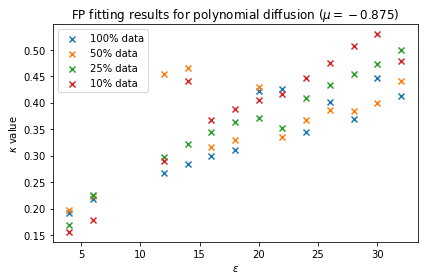

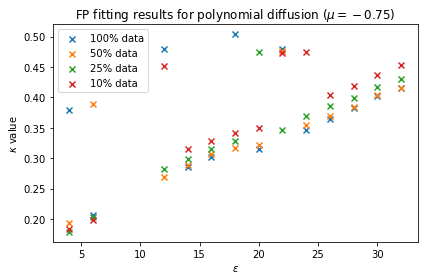

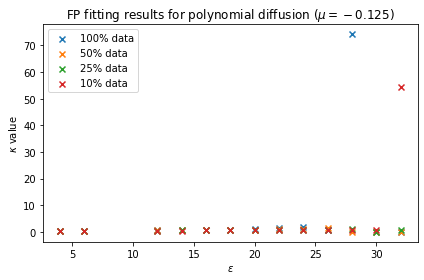

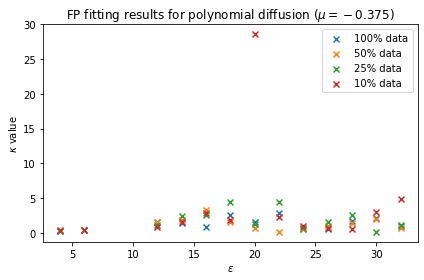

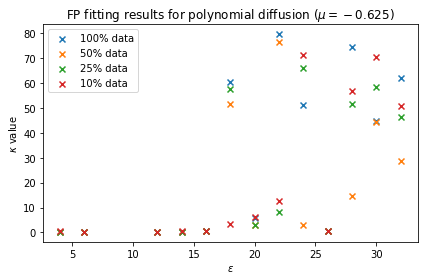

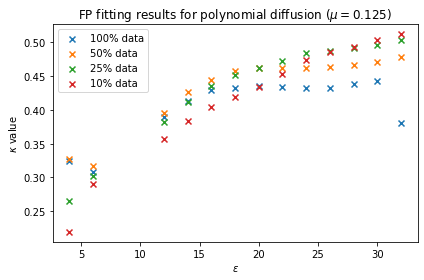

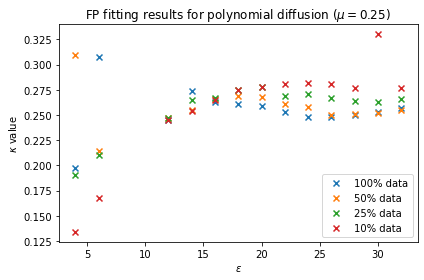

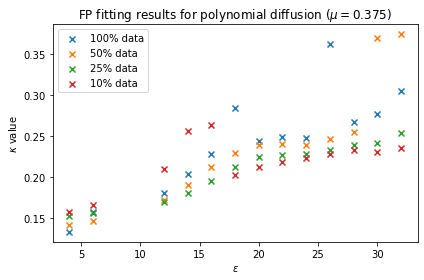

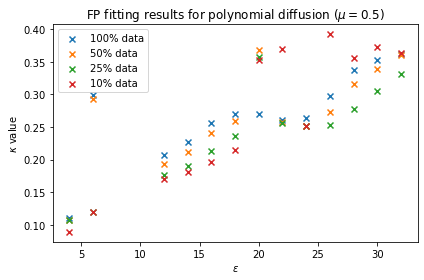

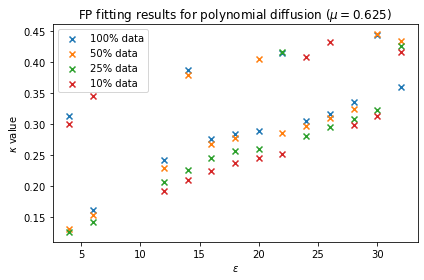

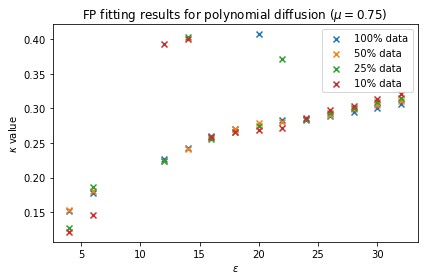

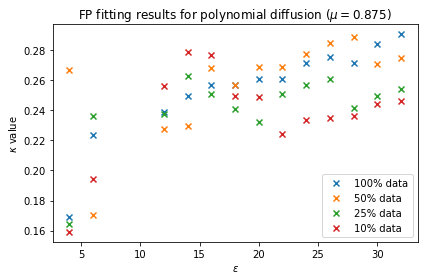

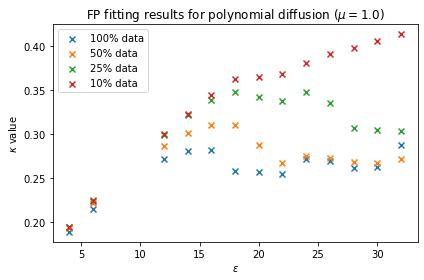

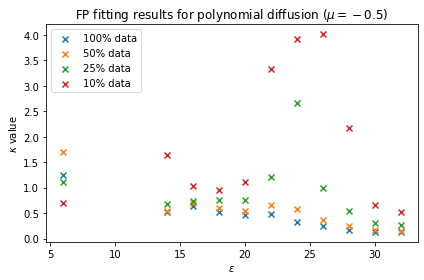

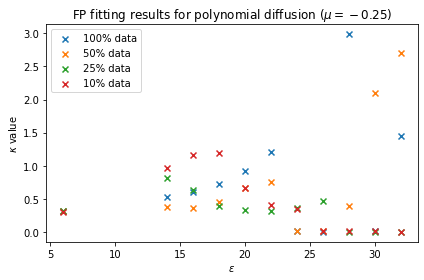

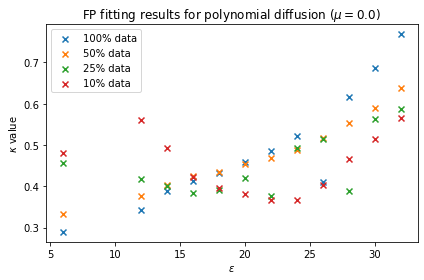

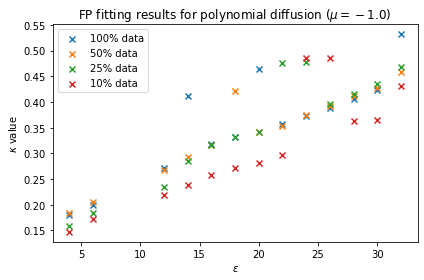

In [71]:
for mu in mu_set:
    plt.figure()
    
    plt.scatter(epsilons[mus==mu], k_fp[mus==mu], marker="x", label="100% data")
    plt.scatter(epsilons[mus==mu], np.asarray(k_fp_no_end)[mus==mu], marker="x", label="50% data")
    plt.scatter(epsilons[mus==mu], np.asarray(k_fp_no_end_medium)[mus==mu], marker="x", label="25% data")
    plt.scatter(epsilons[mus==mu], np.asarray(k_fp_no_end_extreme)[mus==mu], marker="x", label="10% data")
    
    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$ value")
    plt.title("FP fitting results for polynomial diffusion $(\\mu={})$".format(mu))
    
    plt.tight_layout()
    plt.savefig("../img/octo_fp_fitting_values_mu_{}.png".format(mu), dpi=600)

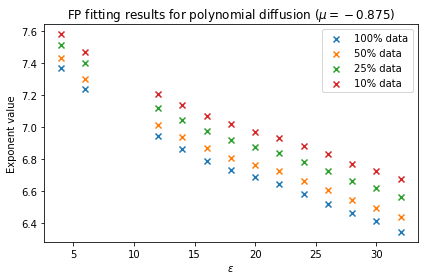

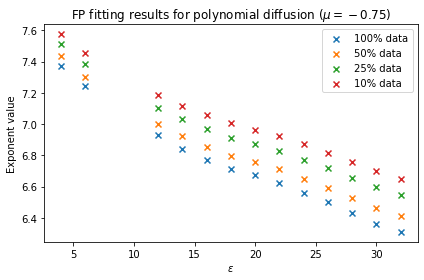

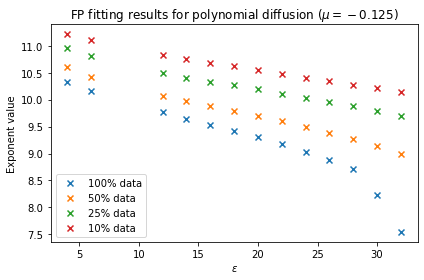

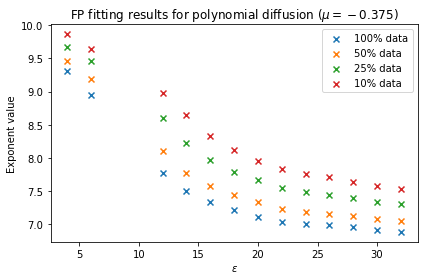

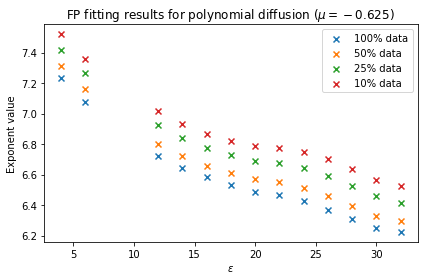

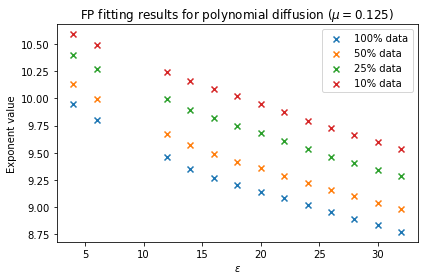

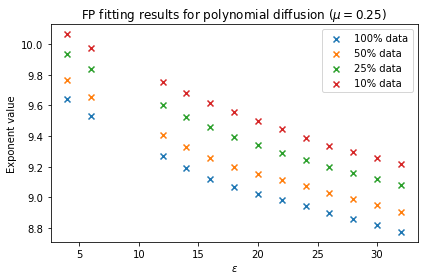

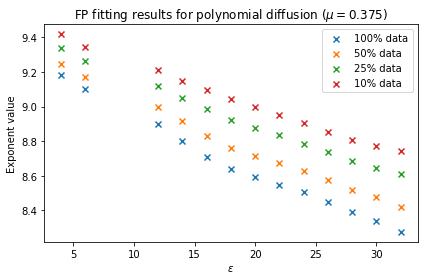

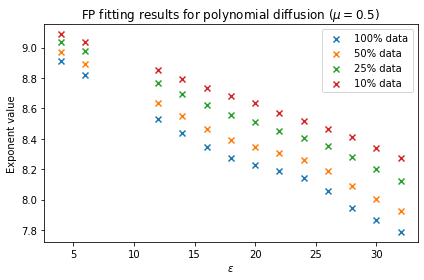

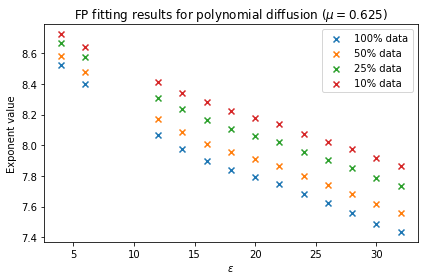

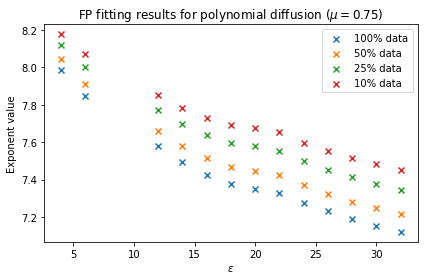

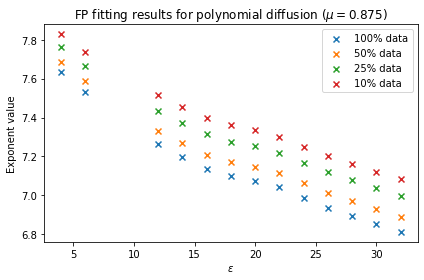

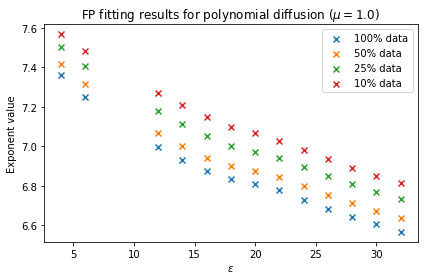

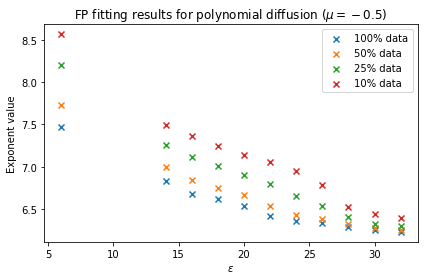

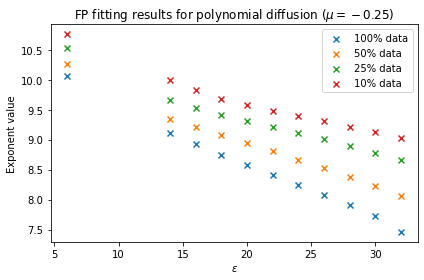

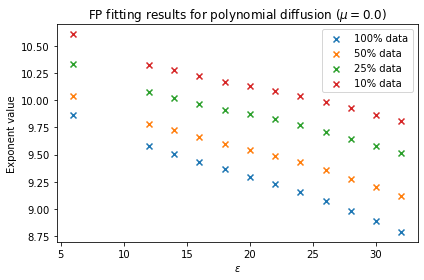

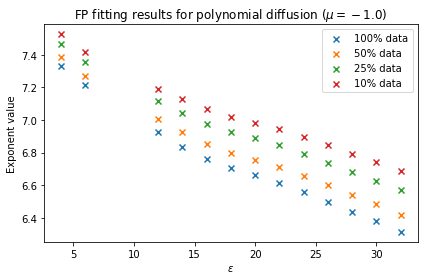

In [65]:
for mu in mu_set:
    plt.figure()
    
    plt.scatter(epsilons[mus==mu], exponent_fp_standard_poly[mus==mu], marker="x", label="100% data")
    plt.scatter(epsilons[mus==mu], exponent_fp_no_end_poly[mus==mu], marker="x", label="50% data")
    plt.scatter(epsilons[mus==mu], exponent_fp_no_end_medium_poly[mus==mu], marker="x", label="25% data")
    plt.scatter(epsilons[mus==mu], exponent_fp_no_end_extreme_poly[mus==mu], marker="x", label="10% data")
    
    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("Exponent value")
    plt.title("FP fitting results for polynomial diffusion $(\\mu={})$".format(mu))
    
    plt.tight_layout()
    plt.savefig("../img/octo_fp_poly_fitting_values_mu_{}.png".format(mu), dpi=600)

In [ ]:
chi_fp_no_end_reconstructed = np.asarray(chi_fp_no_end_reconstructed)
chi_fp_no_end_reconstructed_poly = np.asarray(chi_fp_no_end_reconstructed_poly)
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_reconstructed[mus == mu], marker="x", label="FP, Nekhoroshev")
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_reconstructed_poly[mus == mu], marker="x", label="FP, Polynomial")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\chi^2$")
    plt.title("FP extrapolation results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_fp_extrapolation_comparison_mu_{}.png".format(mu), dpi=600)

In [ ]:
chi_fp_no_end_medium_reconstructed = np.asarray(chi_fp_no_end_medium_reconstructed)
chi_fp_no_end_medium_reconstructed_poly = np.asarray(chi_fp_no_end_medium_reconstructed_poly)
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_medium_reconstructed[mus == mu], marker="x", label="FP, Nekhoroshev")
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_medium_reconstructed_poly[mus == mu], marker="x", label="FP, Polynomial")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\chi^2$")
    plt.title("FP extrapolation results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_fp_extrapolation_comparison_medium_mu_{}.png".format(mu), dpi=600)

In [ ]:
chi_fp_no_end_extreme_reconstructed = np.asarray(chi_fp_no_end_extreme_reconstructed)
chi_fp_no_end_extreme_reconstructed_poly = np.asarray(chi_fp_no_end_extreme_reconstructed_poly)
for i, mu in enumerate(mu_set):
    plt.figure()
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_extreme_reconstructed[mus == mu], marker="x", label="FP, Nekhoroshev")
    plt.scatter(epsilons[mus == mu], chi_fp_no_end_extreme_reconstructed_poly[mus == mu], marker="x", label="FP, Polynomial")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\chi^2$")
    plt.title("FP extrapolation results for different $\\epsilon$ values $(\\mu={})$".format(mu))
    plt.tight_layout()
    plt.savefig("../img/octo_fp_extrapolation_comparison_extreme_mu_{}.png".format(mu), dpi=600)

## Fokker-Planck stuff (but with reconstructed loss)

In [ ]:
I_max = (cut_point+0.1)**2 / 2
I = np.linspace(0, I_max, 1000)
I0 = I * np.exp(-(I/sigma**2))
I0 /= integrate.trapz(I0, I)

### All

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            turn_sampling[::-1],
            loss_from_DA[i][::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_standard_from_da = [T[2] for T in TMP]
finals_standard_from_da = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_from_da.pkl", 'wb') as f:
    pickle.dump((results_standard_from_da, finals_standard_from_da), f)

In [65]:
with open("../data/octo_fp_henon_fit_from_da.pkl", 'rb') as f:
    results_standard_from_da, finals_standard_from_da = pickle.load(f)

### No end

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (loss_from_DA[i][len(turn_sampling)//2:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_from_da = [T[2] for T in TMP]
finals_no_end_from_da = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_from_da.pkl", 'wb') as f:
    pickle.dump((results_no_end_from_da, finals_no_end_from_da), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_from_da.pkl", 'rb') as f:
    results_no_end_from_da, finals_no_end_from_da = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_from_da[i].params,
            (turn_sampling[len(turn_sampling)//2:])[::-1],
            (loss_from_DA[i][len(turn_sampling)//2:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            2,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_from_da = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_from_da = []
k_fp_no_end_from_da = []
k_err_fp_no_end_from_da = []
I_star_fp_no_end_from_da = []
I_star_err_fp_no_end_from_da = []

chi_fp_no_end_from_da = []
rchi_fp_no_end_from_da = []

chi_fp_no_end_reconstructed_from_da = []

for i, result in enumerate(results_no_end_from_da):
    k_fp_no_end_from_da.append(result.params.get("k").value)
    k_err_fp_no_end_from_da.append(result.params.get("k").stderr)
    I_star_fp_no_end_from_da.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_from_da.append(result.params.get("I_star").stderr)
    eps_fp_no_end_from_da.append(epsilons[i])
    chi_fp_no_end_from_da.append(result.chisqr)
    rchi_fp_no_end_from_da.append(result.redchi)
    chi_fp_no_end_reconstructed_from_da.append(chi2(finals_interpolated_no_end_from_da[i], loss_from_DA[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], loss_from_DA[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_from_da[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[len(turn_sampling)//2:])[::-1], finals_no_end_from_da[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (from DA)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_easy_eps_{}_mu_{}_from_da.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end medium...

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (loss_from_DA[i][(len(turn_sampling)//10) * 8:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_medium_from_da = [T[2] for T in TMP]
finals_no_end_medium_from_da = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium_from_da.pkl", 'wb') as f:
    pickle.dump((results_no_end_medium_from_da, finals_no_end_medium_from_da), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_medium_from_da.pkl", 'rb') as f:
    results_no_end_medium_from_da, finals_no_end_medium_from_da = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_medium_from_da[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 8:])[::-1],
            (loss_from_DA[i][(len(turn_sampling)//10) * 8:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            5,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_medium_from_da = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_medium_from_da = []
k_fp_no_end_medium_from_da = []
k_err_fp_no_end_medium_from_da = []
I_star_fp_no_end_medium_from_da = []
I_star_err_fp_no_end_medium_from_da = []

chi_fp_no_end_medium_from_da = []
rchi_fp_no_end_medium_from_da = []

chi_fp_no_end_medium_reconstructed_from_da = []

for i, result in enumerate(results_no_end_medium_from_da):
    k_fp_no_end_medium_from_da.append(result.params.get("k").value)
    k_err_fp_no_end_medium_from_da.append(result.params.get("k").stderr)
    I_star_fp_no_end_medium_from_da.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_medium_from_da.append(result.params.get("I_star").stderr)
    eps_fp_no_end_medium_from_da.append(epsilons[i])
    chi_fp_no_end_medium_from_da.append(result.chisqr)
    rchi_fp_no_end_medium_from_da.append(result.redchi)
    chi_fp_no_end_medium_reconstructed_from_da.append(chi2(finals_interpolated_no_end_medium_from_da[i], loss_from_DA[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], loss_from_DA[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_medium[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 8:])[::-1], finals_no_end_medium[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (from DA)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_medium_eps_{}_mu_{}_from_da.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### No end extreme!

In [ ]:
temp_result = []
temp_final = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_result.append(result[0])
    temp_final.append(result[1])
    temp_eps.append(result[2])
    temp_mus.append(result[3])
    
with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp_fit,
        args=(
            fit.autofit_fp,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (loss_from_DA[i][(len(turn_sampling)//10) * 9:])[::-1],
            I0,
            I_max,
            k3[i],
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_result, temp_final), key=lambda x: x[0] * 1000 + x[1])

results_no_end_extreme_from_da = [T[2] for T in TMP]
finals_no_end_extreme_from_da = [T[3] for T in TMP]

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme_from_da.pkl", 'wb') as f:
    pickle.dump((results_no_end_extreme_from_da, finals_no_end_extreme_from_da), f)

In [ ]:
with open("../data/octo_fp_henon_fit_no_end_extreme_from_da.pkl", 'rb') as f:
    results_no_end_extreme_from_da, finals_no_end_extreme_from_da = pickle.load(f)

In [ ]:
temp_data = []
temp_eps = []
temp_mus = []

def log_result(result):
    temp_data.append(result[0])
    temp_eps.append(result[1])
    temp_mus.append(result[2])

with multiprocessing.Pool(PROCESSES) as pool:
    results = [pool.apply_async(
        wrap_fp,
        args=(
            results_no_end_extreme_from_da[i].params,
            (turn_sampling[(len(turn_sampling)//10) * 9:])[::-1],
            (loss_from_DA[i][(len(turn_sampling)//10) * 9:])[::-1],
            1.0,
            I0,
            I_max,
            1,
            10,
            len(turn_sampling),
            epsilons[i],
            mus[i]),
        callback=log_result) for i in range(len(gaussian_losses))]
    pool.close()
    pool.join()
    
TMP = sorted(zip(temp_eps, temp_mus, temp_data), key=lambda x: x[0] * 1000 + x[1])

finals_interpolated_no_end_extreme_from_da = [T[2] for T in TMP]

In [ ]:
eps_fp_no_end_extreme_from_da = []
k_fp_no_end_extreme_from_da = []
k_err_fp_no_end_extreme_from_da = []
I_star_fp_no_end_extreme_from_da = []
I_star_err_fp_no_end_extreme_from_da = []

chi_fp_no_end_extreme_from_da = []
rchi_fp_no_end_extreme_from_da = []

chi_fp_no_end_extreme_reconstructed_from_da = []

for i, result in enumerate(results_no_end_extreme_from_da):
    k_fp_no_end_extreme_from_da.append(result.params.get("k").value)
    k_err_fp_no_end_extreme_from_da.append(result.params.get("k").stderr)
    I_star_fp_no_end_extreme_from_da.append(result.params.get("I_star").value)
    I_star_err_fp_no_end_extreme_from_da.append(result.params.get("I_star").stderr)
    eps_fp_no_end_extreme_from_da.append(epsilons[i])
    chi_fp_no_end_extreme_from_da.append(result.chisqr)
    rchi_fp_no_end_extreme_from_da.append(result.redchi)
    chi_fp_no_end_extreme_reconstructed_from_da.append(chi2(finals_interpolated_no_end_extreme[i], gaussian_losses[i][::-1]))

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()

    plt.scatter(turn_sampling[::-1], loss_from_DA[index][::-1], s=1, label="loss data", marker="x")
    plt.plot(turn_sampling[::-1], finals_interpolated_no_end_extreme_from_da[index], label="FP fitting result brought forward", c="C1")
    plt.plot((turn_sampling[(len(turn_sampling)//10) * 9:])[::-1], finals_no_end_extreme_from_da[index], label="FP fitting result", c="C2")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.4})$ (from DA)".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_interp_no_end_extreme_eps_{}_mu_{}_from_da.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

### Plots FP

In [ ]:
for index in range(len(gaussian_losses)):
    plt.figure()
    plt.plot(turn_sampling[::-1], gaussian_losses[index][::-1], label="loss data")
    plt.plot(turn_sampling[::-1], finals_standard[index], label="FP fitting")

    plt.legend()
    plt.xlabel("$N$ turns")
    plt.ylabel("Losses")
    plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4}, \\mu={:.5})$".format(sigma, epsilons[index], mus[index]))

    plt.tight_layout()

    plt.savefig("../img/octo_fp_henon_fitting_all_eps_{}_mu_{}.png".format(epsilons[index], mus[index]), dpi=600)
    plt.close()

In [ ]:
index = 0
plt.figure()
plt.plot(turn_sampling[::-1], gaussian_losses[index][::-1], label="loss data")
plt.plot(turn_sampling[::-1], finals_standard[index], label="FP fitting")

plt.legend()
plt.xlabel("$N$ turns")
plt.ylabel("Losses")
plt.title("Hénon map with gaussian weights $(\\sigma={:.2}, \\varepsilon={:.4})$".format(sigma, epsilons[index]))

plt.tight_layout()

In [ ]:
eps_fp = []
k_fp = []
k_err_fp = []
I_star_fp = []
I_star_err_fp = []

chi_fp = []
rchi_fp = []

chi_fp_reconstructed = []

for i, result in enumerate(results_standard):
    k_fp.append(result.params.get("k").value)
    k_err_fp.append(result.params.get("k").stderr)
    I_star_fp.append(result.params.get("I_star").value)
    I_star_err_fp.append(result.params.get("I_star").stderr)
    eps_fp.append(epsilons[i])
    chi_fp.append(result.chisqr)
    rchi_fp.append(result.redchi)
    chi_fp_reconstructed.append(chi2(finals_standard[i], gaussian_losses[i][::-1]))

In [ ]:
eps_fp_no_beg = []
k_fp_no_beg = []
k_err_fp_no_beg = []
I_star_fp_no_beg = []
I_star_err_fp_no_beg = []

chi_fp_no_beg = []
rchi_fp_no_beg = []

for i, result in enumerate(results_no_beg):
    k_fp_no_beg.append(result.params.get("k").value)
    k_err_fp_no_beg.append(result.params.get("k").stderr)
    I_star_fp_no_beg.append(result.params.get("I_star").value)
    I_star_err_fp_no_beg.append(result.params.get("I_star").stderr)
    eps_fp_no_beg.append(epsilons[i])
    chi_fp_no_beg.append(result.chisqr)
    rchi_fp_no_beg.append(result.redchi)

In [ ]:
k_fp = np.asarray(k_fp)
k_fp_no_end = np.asarray(k_fp_no_end)
k_fp_no_end_medium = np.asarray(k_fp_no_end_medium)
k_fp_no_end_extreme = np.asarray(k_fp_no_end_extreme)

In [ ]:
for i, epsilon in enumerate(epsilon_set):

    plt.figure()

    plt.scatter(mus[epsilons == epsilon], k_fp[epsilons == epsilon], marker="x", label="FP all data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end[epsilons == epsilon], marker="x", label="FP 50% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_medium[epsilons == epsilon], marker="x", label="FP 20% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_extreme[epsilons == epsilon], marker="x", label="FP 10% data")
    plt.scatter(mus[epsilons == epsilon], k2[epsilons == epsilon], marker="x", label="Model 4, two parameters")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()

    #plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_with_model4_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i, epsilon in enumerate(epsilon_set):

    plt.figure()

    plt.scatter(mus[epsilons == epsilon], k_fp[epsilons == epsilon], marker="x", label="FP all data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end[epsilons == epsilon], marker="x", label="FP 50% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_medium[epsilons == epsilon], marker="x", label="FP 20% data")
    plt.scatter(mus[epsilons == epsilon], k_fp_no_end_extreme[epsilons == epsilon], marker="x", label="FP 10% data")

    plt.legend()
    plt.xlabel("$\\mu$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\varepsilon={})$".format(epsilon))
    plt.tight_layout()

    plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_log_eps_{}.png".format(epsilon), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):

    plt.figure()

    plt.scatter(epsilons[mus == mu], k_fp[mus == mu], marker="x", label="FP all data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end[mus == mu], marker="x", label="FP 50% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_medium[mus == mu], marker="x", label="FP 20% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_extreme[mus == mu], marker="x", label="FP 10% data")
    plt.scatter(epsilons[mus == mu], k2[mus == mu], marker="x", label="Model 4, two parameters")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\mu={})$".format(mu))
    plt.tight_layout()

    #plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_with_model4_mu_{}.png".format(mu), dpi=600)

In [ ]:
for i, mu in enumerate(mu_set):

    plt.figure()

    plt.scatter(epsilons[mus == mu], k_fp[mus == mu], marker="x", label="FP all data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end[mus == mu], marker="x", label="FP 50% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_medium[mus == mu], marker="x", label="FP 20% data")
    plt.scatter(epsilons[mus == mu], k_fp_no_end_extreme[mus == mu], marker="x", label="FP 10% data")

    plt.legend()
    plt.xlabel("$\\varepsilon$")
    plt.ylabel("$\\kappa$")
    plt.title("Comparison between $\\kappa$ values $(\\mu={})$".format(mu))
    plt.tight_layout()

    plt.yscale("log")

    plt.savefig("../img/octo_fp_variants_henon_k_log_mu_{}.png".format(mu), dpi=600)